# Exploratory Data Analysis on my Spotify Data

Earlier title: Playing around with my Spotify Data (nicely this time)

This data has been lying around and bugging me since January. Today I got frustrated and am staring this project now, taking inspiration from this article/blog: https://medium.com/swlh/analysis-of-my-spotify-streaming-history-57a6088c3d3.

I thought I'd make a project where I could tell which songs would be skipped and how long would it be listened to. I think I'll try to do it afterwards (relating to the valence, danceability(?), etc.). 

I will be mentioning the date and time when I start and finish for the day, just to see if I am consistent with this project.

I started this project at 9:05 PM on 17/03/2024.
I will be considering it done at 6:11 PM on 26/06/2024. **Not yet vmro**<br> GET THE GENRES<br>
ig now it's done? `11:47 PM`, same day~

## Getting the data into a workable form

The data currently is in .json format. I need to convert it to a dataframe and then work on it. I'll be back after learning how to do it.

I am back, turns out it is the same as how you would get data from a csv file. There are 5 total .json files that contain the information, so I'll be first naming the DataFrames as df1, df2, etc. Then I'll be combining the DataFrames into one and be working on it.

In [1]:
%%time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pytz import timezone
import matplotlib.font_manager as fm
from matplotlib import cm

df1 = pd.read_json("Streaming_History_Audio_2020-2021_0.json")
df2 = pd.read_json("Streaming_History_Audio_2021-2022_1.json")
df3 = pd.read_json("Streaming_History_Audio_2022-2023_2.json")
df4 = pd.read_json("Streaming_History_Audio_2023_3.json")
df5 = pd.read_json("Streaming_History_Audio_2023_4.json")
df1.shape, df2.shape, df3.shape, df4.shape, df5.shape

CPU times: total: 3.25 s
Wall time: 6.68 s


((15678, 21), (15600, 21), (15893, 21), (16603, 21), (3619, 21))

* `df.append` was removed from pandas and now you need to work with `pd.concat`
* using `pd.concat`, we can concatenate all 5 dataframes at once, so we'll concatenate after getting all the dataframes.

In [2]:
data = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
data.shape

(67393, 21)

## Data Cleaning

In [3]:
data = data.loc[data.ms_played>=16969]

## Manipulation

Now, we have the data ready.
* Get the timestamp to work as dates and time.
* Convert the date and time to IST.
* I'll be removing:
    * the columns which I think will not give any insights.
    * empty rows
    * streams where I did not listen to the track

And finally, separating the podcast data with the song data.

In [4]:
data.columns

Index(['ts', 'username', 'platform', 'ms_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')

**Converting `ts` column to datetime and to IST**

In [5]:
data.ts = pd.to_datetime(data.ts)

In [6]:
# from pytz import timezone

utc = timezone("UTC")
ist = timezone("Asia/Kolkata")

In [7]:
data.ts = data.ts.dt.tz_convert(ist)
data.ts

0       2020-05-23 21:34:26+05:30
1       2020-05-23 21:38:29+05:30
2       2020-05-23 21:40:53+05:30
7       2020-05-25 21:34:53+05:30
9       2020-05-26 23:39:12+05:30
                   ...           
67387   2023-11-16 16:23:28+05:30
67388   2023-11-16 16:36:19+05:30
67390   2023-11-16 19:59:27+05:30
67391   2023-11-16 20:03:50+05:30
67392   2023-11-17 00:59:42+05:30
Name: ts, Length: 45331, dtype: datetime64[ns, Asia/Kolkata]

**Adding relevant time columns**

In [8]:
data["year"] = data.ts.dt.year
data["day"] = data.ts.dt.day
data["month"] = data.ts.dt.month
data["dayofyear"] = data.ts.dt.dayofyear
data["dayofweek"] = data.ts.dt.dayofweek

**Getting the null columns and dealing with them**

In [10]:
data.isna().sum()

ts                                       0
username                                 0
platform                                 0
ms_played                                0
conn_country                             0
ip_addr_decrypted                        0
user_agent_decrypted                     0
master_metadata_track_name             274
master_metadata_album_artist_name      274
master_metadata_album_album_name       274
spotify_track_uri                      274
episode_name                         45074
episode_show_name                    45074
spotify_episode_uri                  45074
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                              27481
offline                                  0
offline_timestamp                        0
incognito_mode                           0
year                                     0
day                                      0
month      

**Separating the song and podcast data**

In [11]:
podcast_index = list(data.index[data.master_metadata_track_name.isna()])
podcast = data.loc[podcast_index]
podcast = podcast.reset_index(drop=True)
podcast.head(1)

ts                   username  \
0 2020-05-25 21:34:53+05:30  c25l5ml3rqujqvi8z0jm607g7   

                                         platform  ms_played conn_country  \
0  Android OS 9 API 28 (Xiaomi, Redmi Note 8 Pro)     123631           IN   

  ip_addr_decrypted user_agent_decrypted master_metadata_track_name  \
0   169.149.227.166              unknown                       None   

  master_metadata_album_artist_name master_metadata_album_album_name  ...  \
0                              None                             None  ...   

  shuffle skipped offline offline_timestamp incognito_mode  year  day month  \
0   False     NaN   False     1590313544995          False  2020   25     5   

   dayofyear  dayofweek  
0        146          0  

[1 rows x 26 columns]

> we had to change the index for this to start from 0 (using reset_index)

In [12]:
song = data.drop(podcast_index)
song = song.reset_index(drop=True)

> now we have two seaprate dataframes for song and podcast data

In [14]:
song.drop(["spotify_episode_uri", "episode_show_name", "episode_name"], axis=1, inplace=True)

In [16]:
podcast.drop(["master_metadata_track_name", 
              "master_metadata_album_artist_name", 
              "master_metadata_album_album_name", 
              "spotify_track_uri"], axis=1, inplace=True)

> there are 94 values for the episode details which are empty, i first need to check which those are. there is not a better way to look at this data than to make a csv file.

In [17]:
podcast.to_csv("podcast_data.csv")

> okay, i have checked and the rows where episode details are empty seem to be unsuccessful attempts to start a podcast episode (with ms_played=0), so, we can remove them without any other changes.

In [18]:
no_episode = list(podcast.index[podcast.episode_name.isna()])
podcast = podcast.drop(no_episode)
podcast.shape

(257, 22)

### making song-artist column

In [20]:
song["song-artist"] = song["master_metadata_track_name"] + " - " + song["master_metadata_album_artist_name"]

### Data cleaning contd.: separating for years

In [21]:
song["timeofday"] = song.ts.dt.time

song["hourofday"] = song.ts.dt.hour

In [22]:
df2020 = song.loc[song.year == 2020]
df2021 = song.loc[song.year == 2021]
df2022 = song.loc[song.year == 2022]
df2023 = song.loc[song.year == 2023]

Now, this is big:<br>
* I will be doing this because during the year 2023, I slept with songs on and these songs kept running, disturbing the order of the streams of these year.
* I will try to remove these streams, using mentioned criteria: (I did my best to include all cases where I think the streams were recorded when i was sleeping)
    * streams **after 3 AM** and **before 6 AM**
    * streams recorded on my **android device**

In [23]:
three_am_2023 = df2023.loc[((df2023.hourofday >=3) & (df2023.hourofday <=6)) & (song.platform=="android")]

In [24]:
three_am_2023.to_csv("3 am songs.csv")

#### After checking the csv, I decided to keep these dates' streams, they seemed legit
Preserved 28-01-2023 and 22-09-2023

In [167]:
to_drop = df2023.loc[((df2023.hourofday >=3) & (df2023.hourofday <=6)) & (song.platform=="android")]
drop = list(to_drop.index)

In [26]:
sep22 = list(df2023.loc[(df2023.dayofyear == 265)].index)
jan28 = list(df2023.loc[(df2023.dayofyear == 28)].index)
drop1 = [x for x in drop if x not in (sep22 + jan28)]
df20231 = df2023.copy()
df20231.drop(drop1, inplace=True)

#### filter this data for the song df

In [27]:
song_filter = song.copy()
song_filter.drop(drop1, inplace=True)

In [28]:
song.shape, song_filter.shape

((45057, 26), (44152, 26))

In [168]:
45057-44152

905

SO, as can be seen **905 streams were removed** from the dataframe which were distorting all the stats of 2023.

### Plots for frequency and minutes played
**First setting the font (Malgun Gothic) so that Korean (and a large chunk of Japanese) letters can be shown in the plots**, also importing colour map `spring`

In [29]:
# import matplotlib.font_manager as fm
# from matplotlib import cm
cmap = cm.spring

font_path = fm.findfont("Malgun Gothic")
malgun_font = fm.FontProperties(fname=font_path, size=18)

In [30]:
def makeplot(dt, col):
    '''
    makes plot for a given dictionary's dataframes' columns, such as year and month according to both: minutes played and no. of times played
    dt: dictionary with the name of the dataframes as the keys and the values as dataframes
    col: list of columns of the dataframe you want to make the plots for
    '''
    for key, val in dt.items():
        for x in col:
            fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,16))

            ax[0].bar(list(set(val[x])) , (val.groupby(x)["ms_played"].sum())/(60*1000),
                       color="skyblue")
            ax[0].set(xlabel=f"{x}",
                       ylabel="Minutes Played",
                       title=f"Minutes Played for {x} (for {key} data)")

            ax[1].bar(list(set(val[x])) , val[x].value_counts().sort_index(),
                     color="springgreen")
            ax[1].set(xlabel=f"{x}",
                      ylabel="Frequency",
                      title=f"No. of tracks played for {x} (for {key} data)")

In [31]:
def makeplot_20(dt, what, x):
    '''
    makes plot for the top 20 artists/frames according to both minutes played and no. of times played
    dt: dictionary that conatains dataframes
    what: to specify if plot is for artists or for tracks
    x: choose one of two: 'Minutes Played', 'No. of Times Played'
    '''
    for key, values in dt.items():
        sorted_df = values.sort_values(by=x, ascending=False)

        norm = plt.Normalize(min(sorted_df[x].head(20)), 
                         max(sorted_df[x].head(20)))

        plt.figure(figsize=(18,10))

        plt.barh(y=sorted_df[f"{what} Name"].head(20), 
            width=sorted_df[x].head(20),
            color=cmap(norm(sorted_df[x].head(20))))

        plt.xlabel(x, fontproperties=malgun_font)
        plt.title(f"Top 20 Most Played {what}s (by {x}) for {key}", fontproperties=malgun_font)
        plt.gca().invert_yaxis()
        plt.yticks(range(len(sorted_df[f"{what} Name"].head(20))),  # number of ticks
                       sorted_df[f"{what} Name"].head(20).tolist(),  # tick labels
                       fontproperties=malgun_font)
        plt.bar_label(plt.gca().containers[0], fontproperties=malgun_font)
        plt.show()

#### some explanation for the following plots (minutes played and frequency of tracks and podcasts)
1. Minutes Played for year (for lifetime podcast data): i started listening to podcasts in 2023, August to be precise
2. freq for same: same expl
<br>
3. Minutes Played for month (for lifetime podcast data): interesting story: i had eye flu, couldn't see any screens or study, was bored of listening to songs all day and found the horror podcast: **Kowabana: 'True' Japanese Scary Horror Stories** and just binge listened (if that's a term) for 2-3 days straight. It was a great experience, having my eyes closed and imagining all kinds of scary things.
4. freq for same: not that much of a difference (ofc, those stories were 40-50 minutes long)
<br>
5. Minutes Played for year (for lifetime song data): just started off in September of 2020, before that, 5-10 songs was all I listened to. AND VMRO I DISCOVERED K-POP. that changed pretty much everything in this aspect. 2021 was all kpop and other korean songs. 2022 saw the JEE and Attack on titan and hans zimmer soundtracks to focus on the exam. 2023: i had bought premium at this point and in college i couldn't listen to songs that much and also didn't study and some credit goes to some stability i got from getting into a good college
6. freq: shows the same trend as the minute counterpart
7. others provide no particular insight

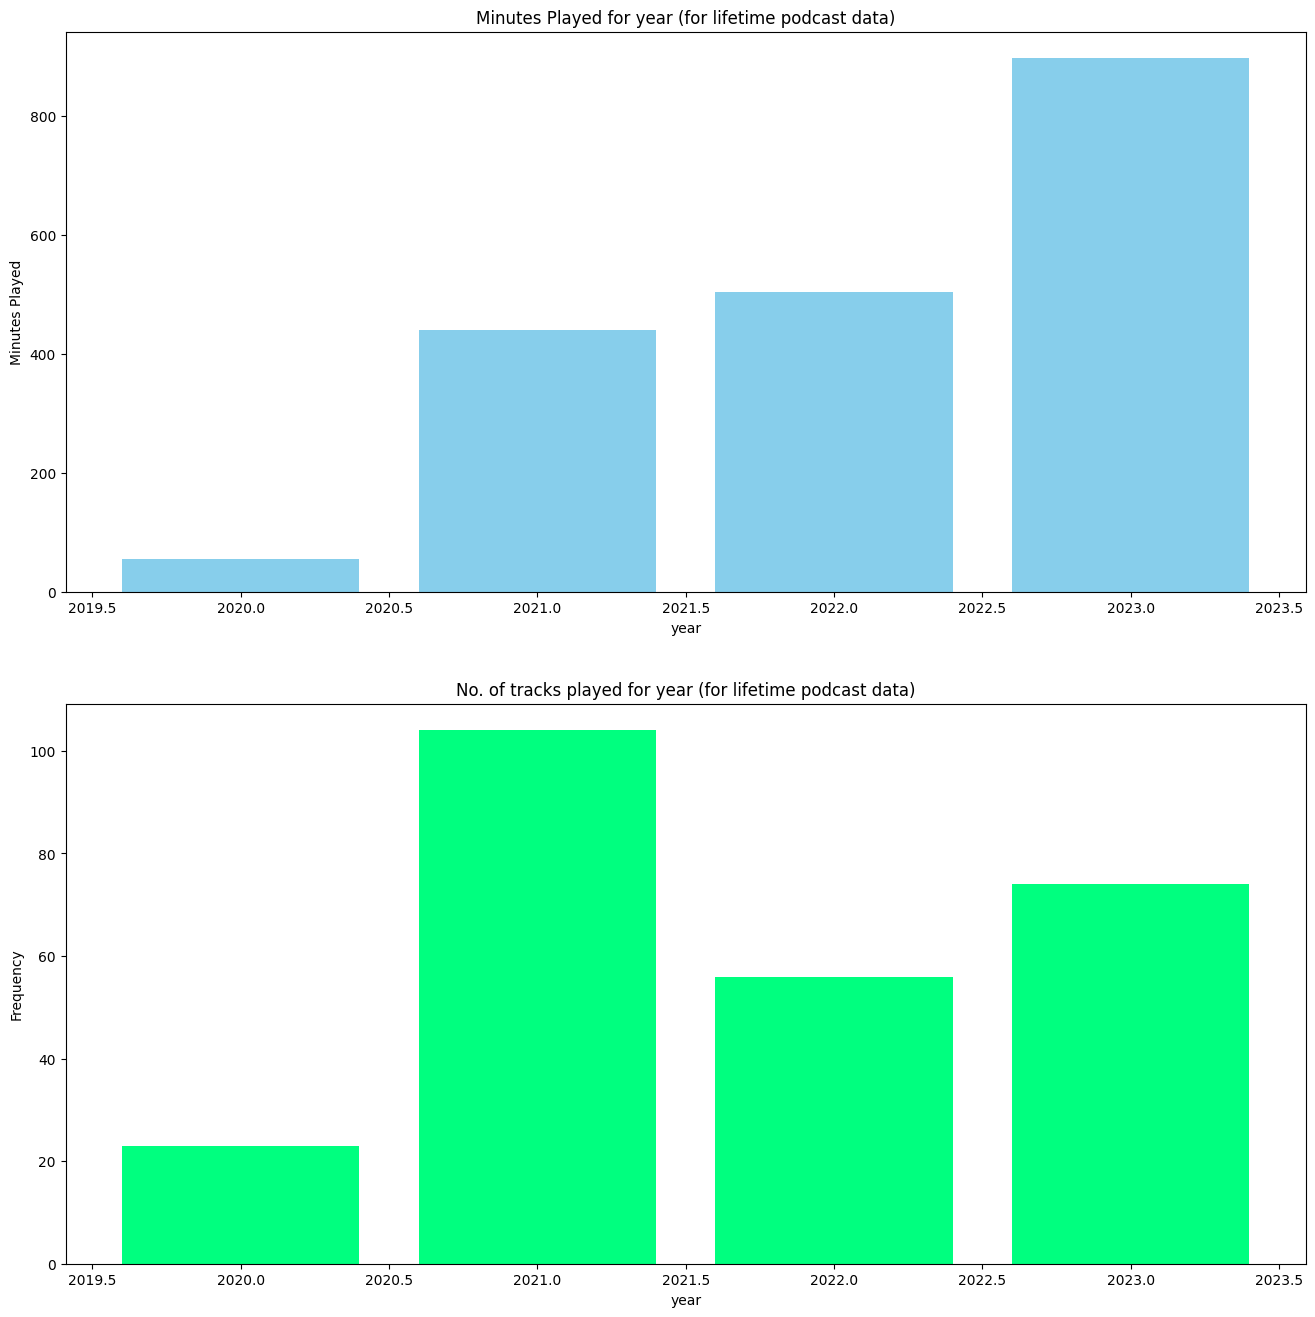

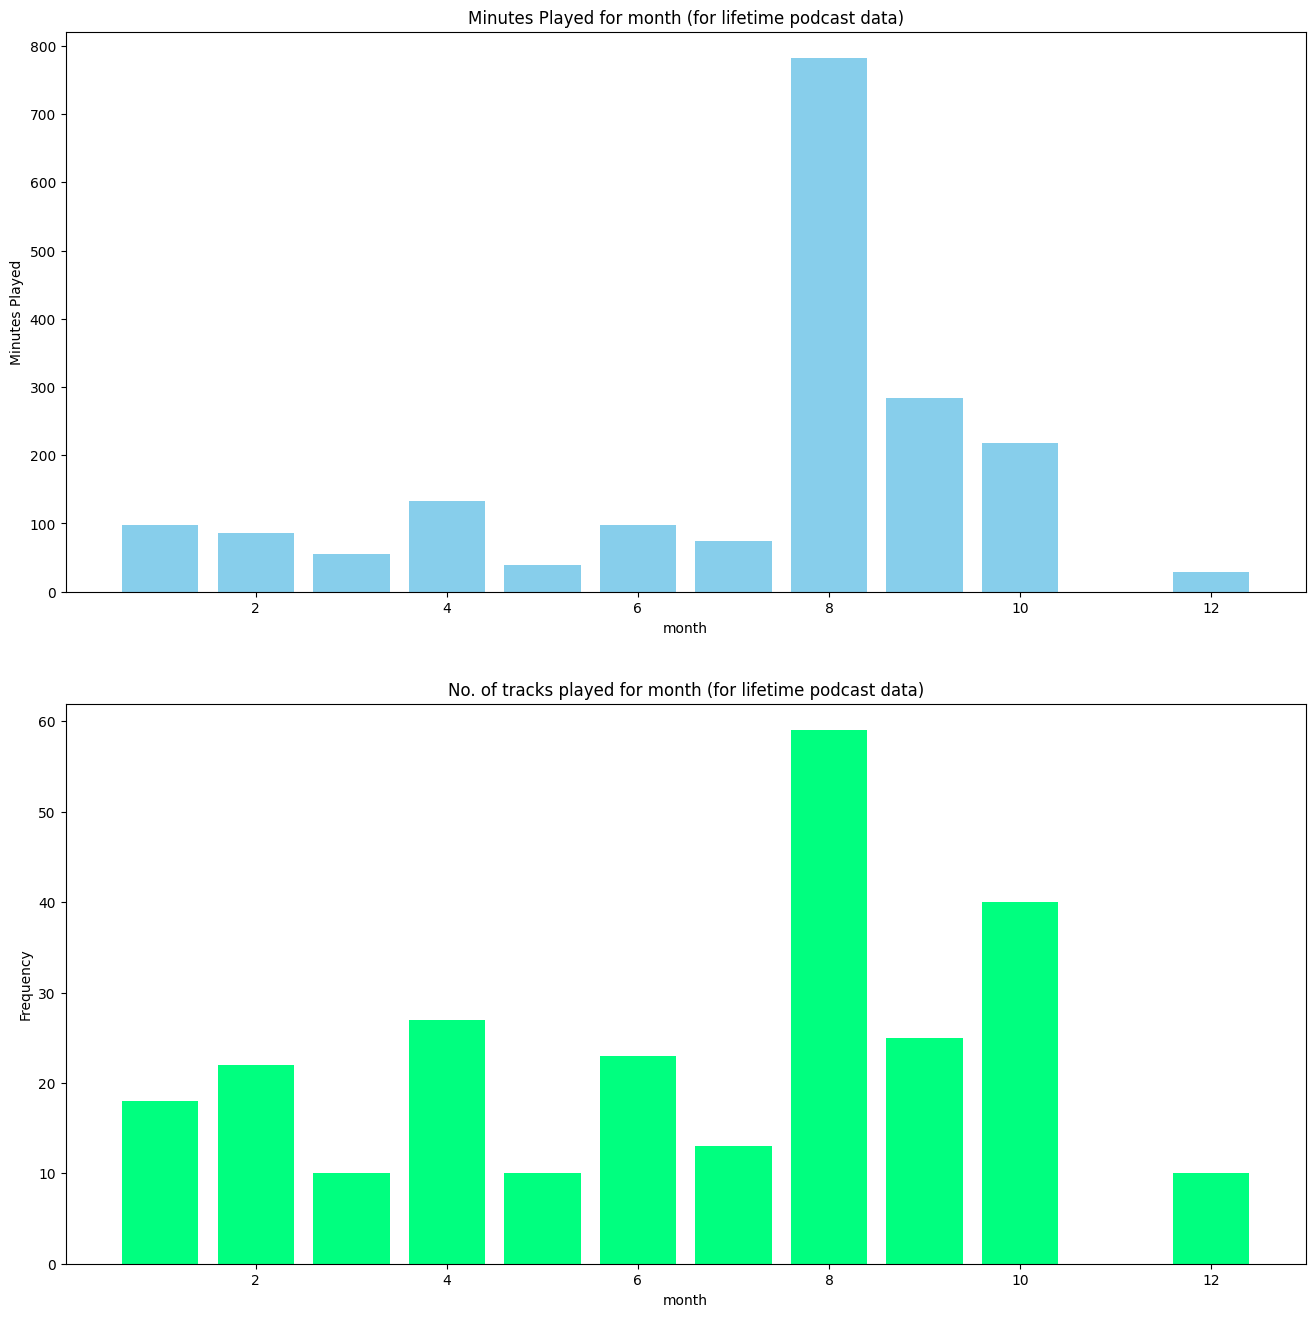

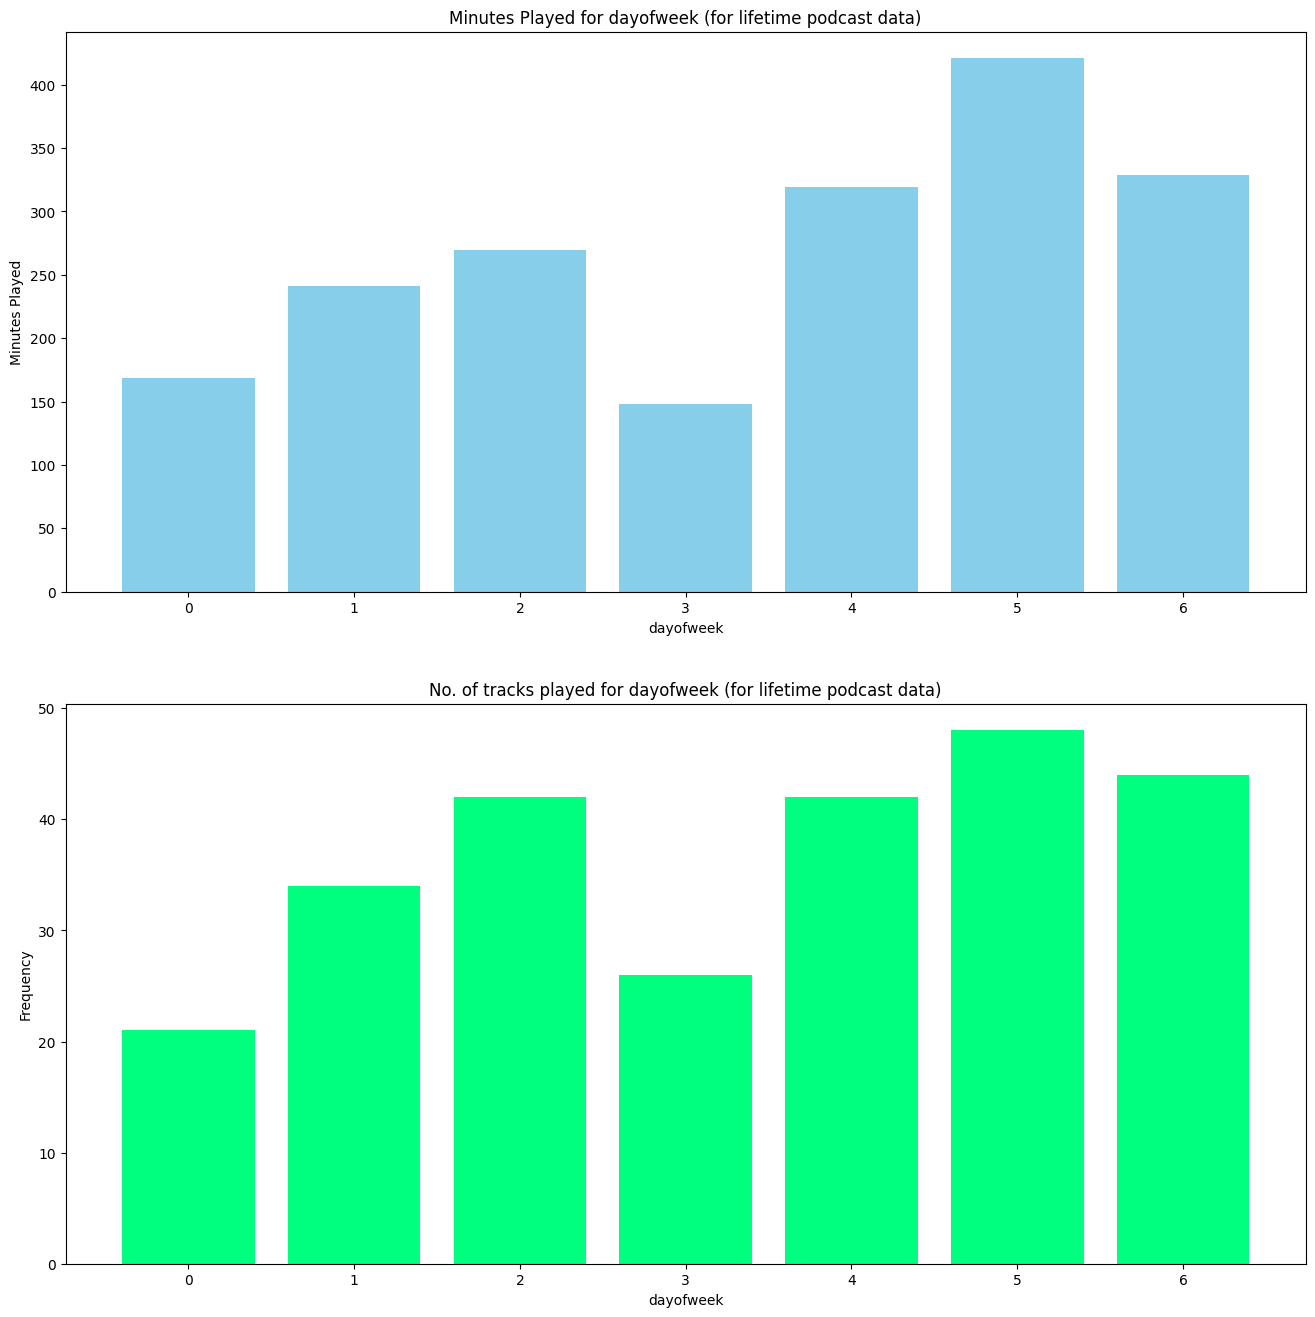

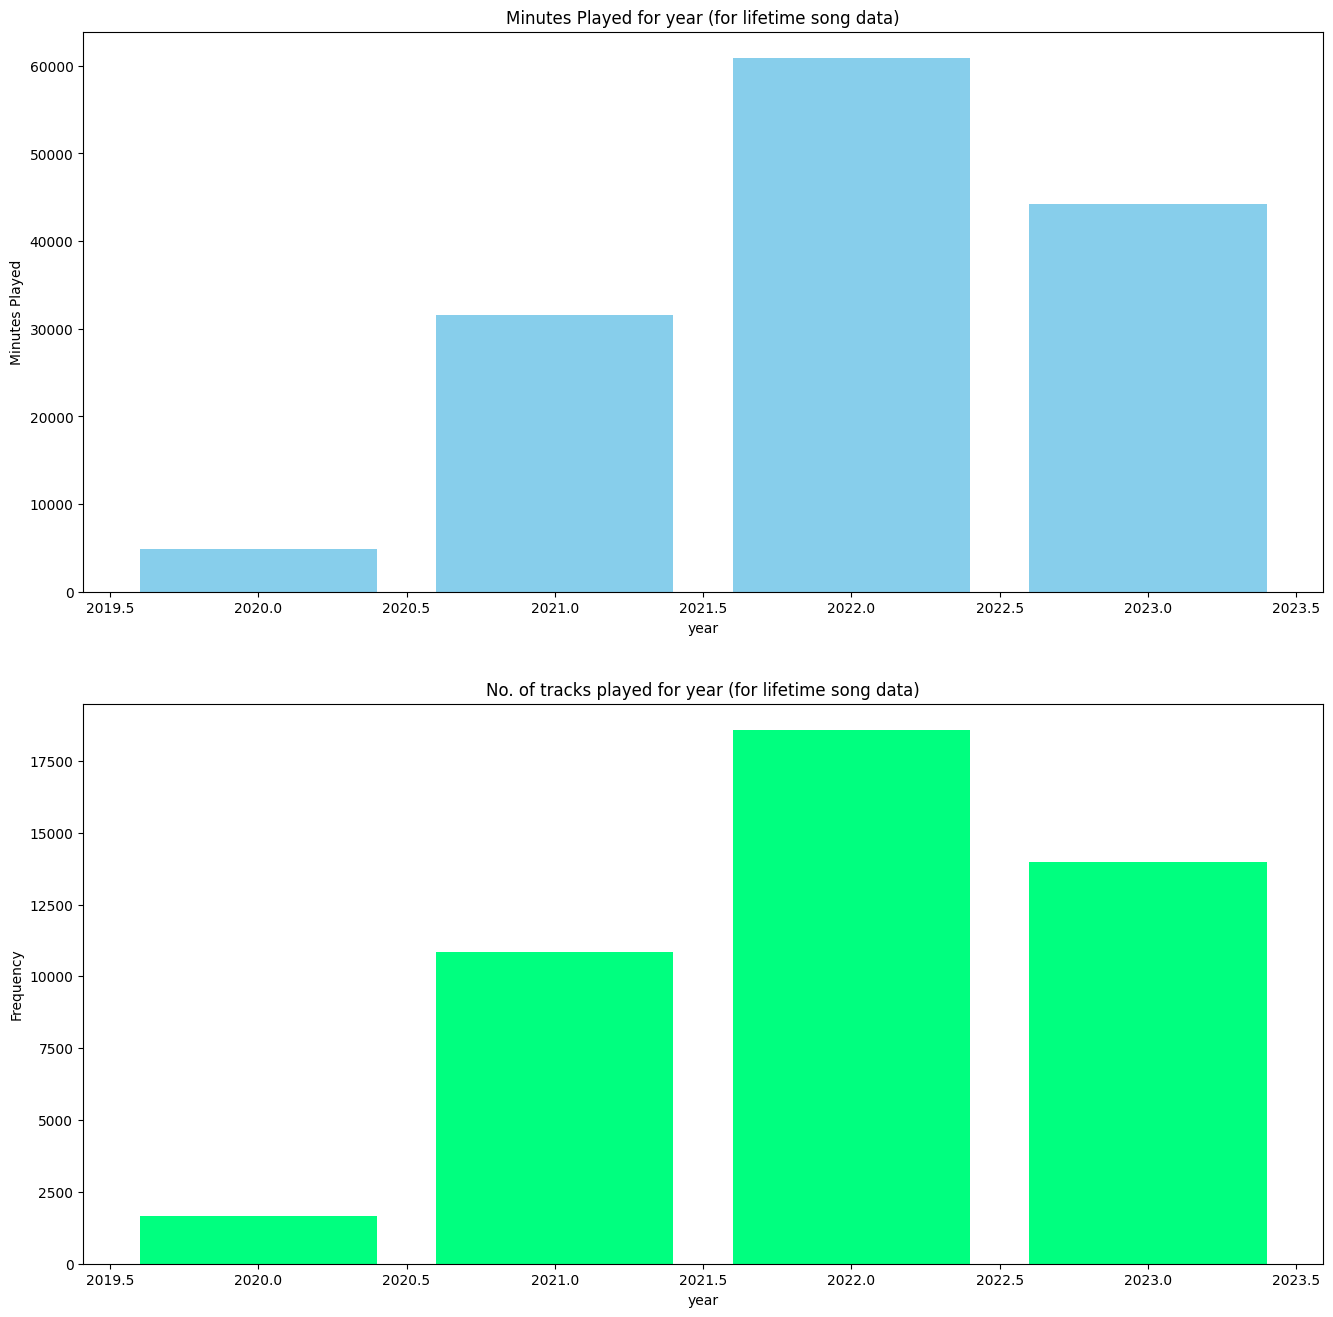

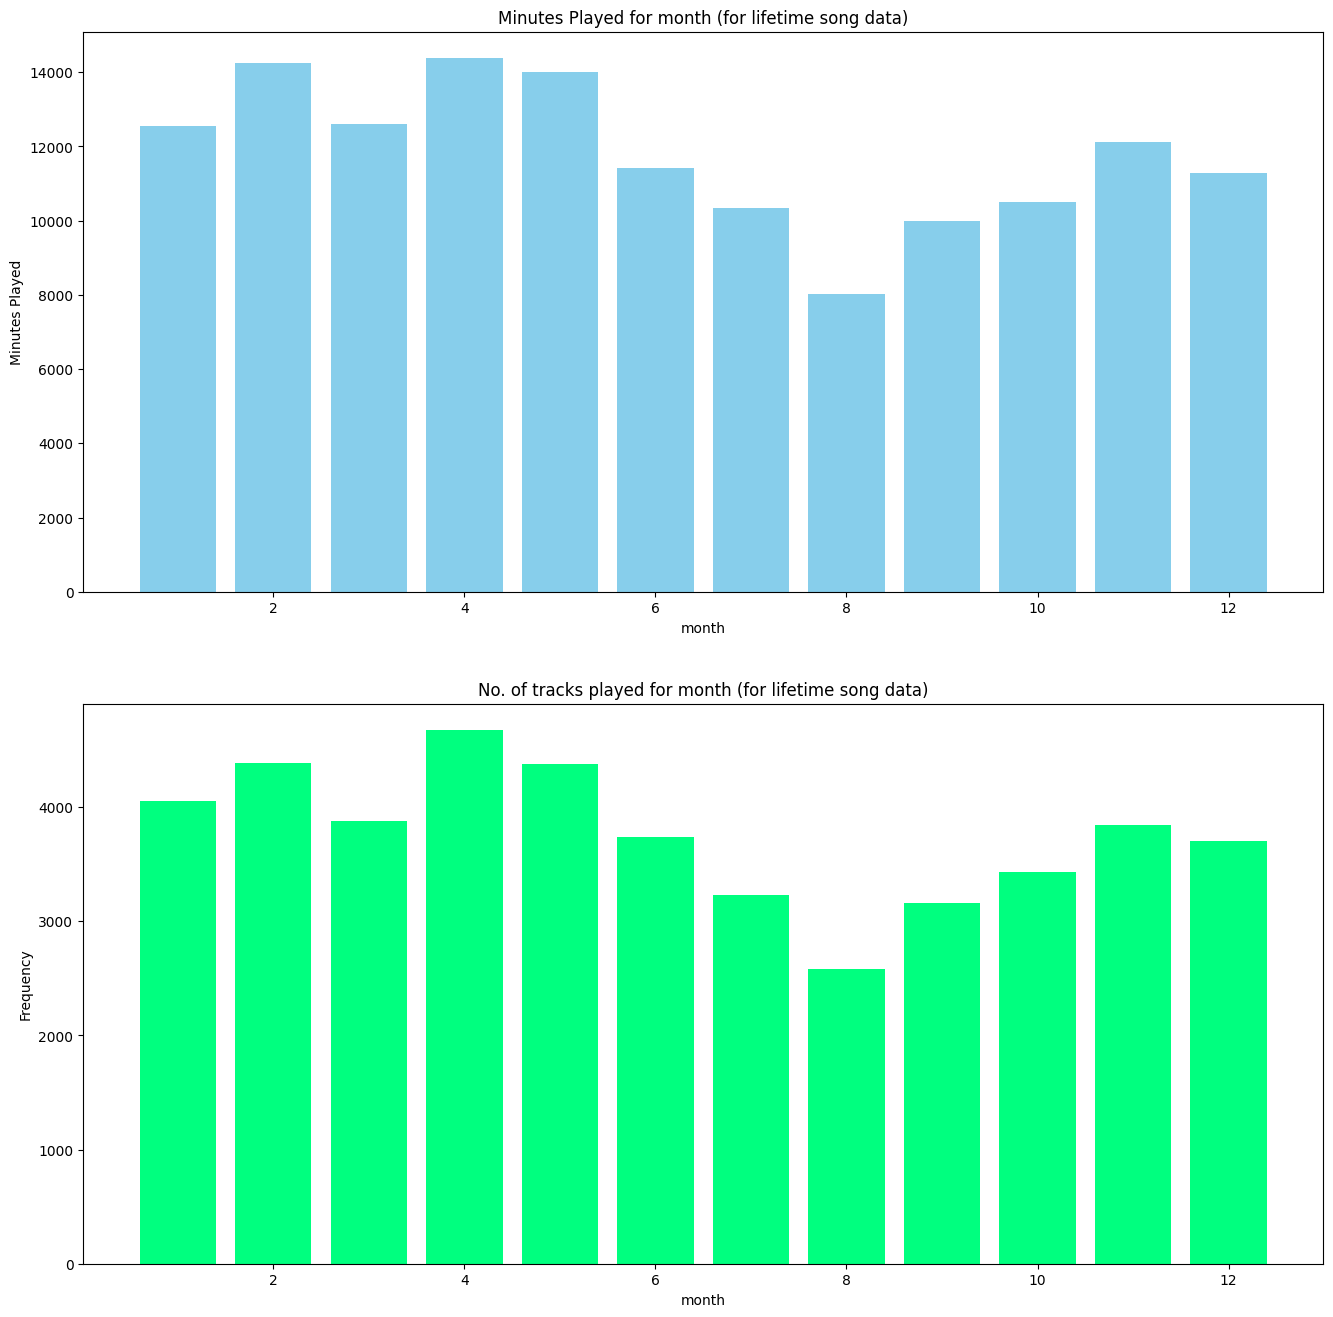

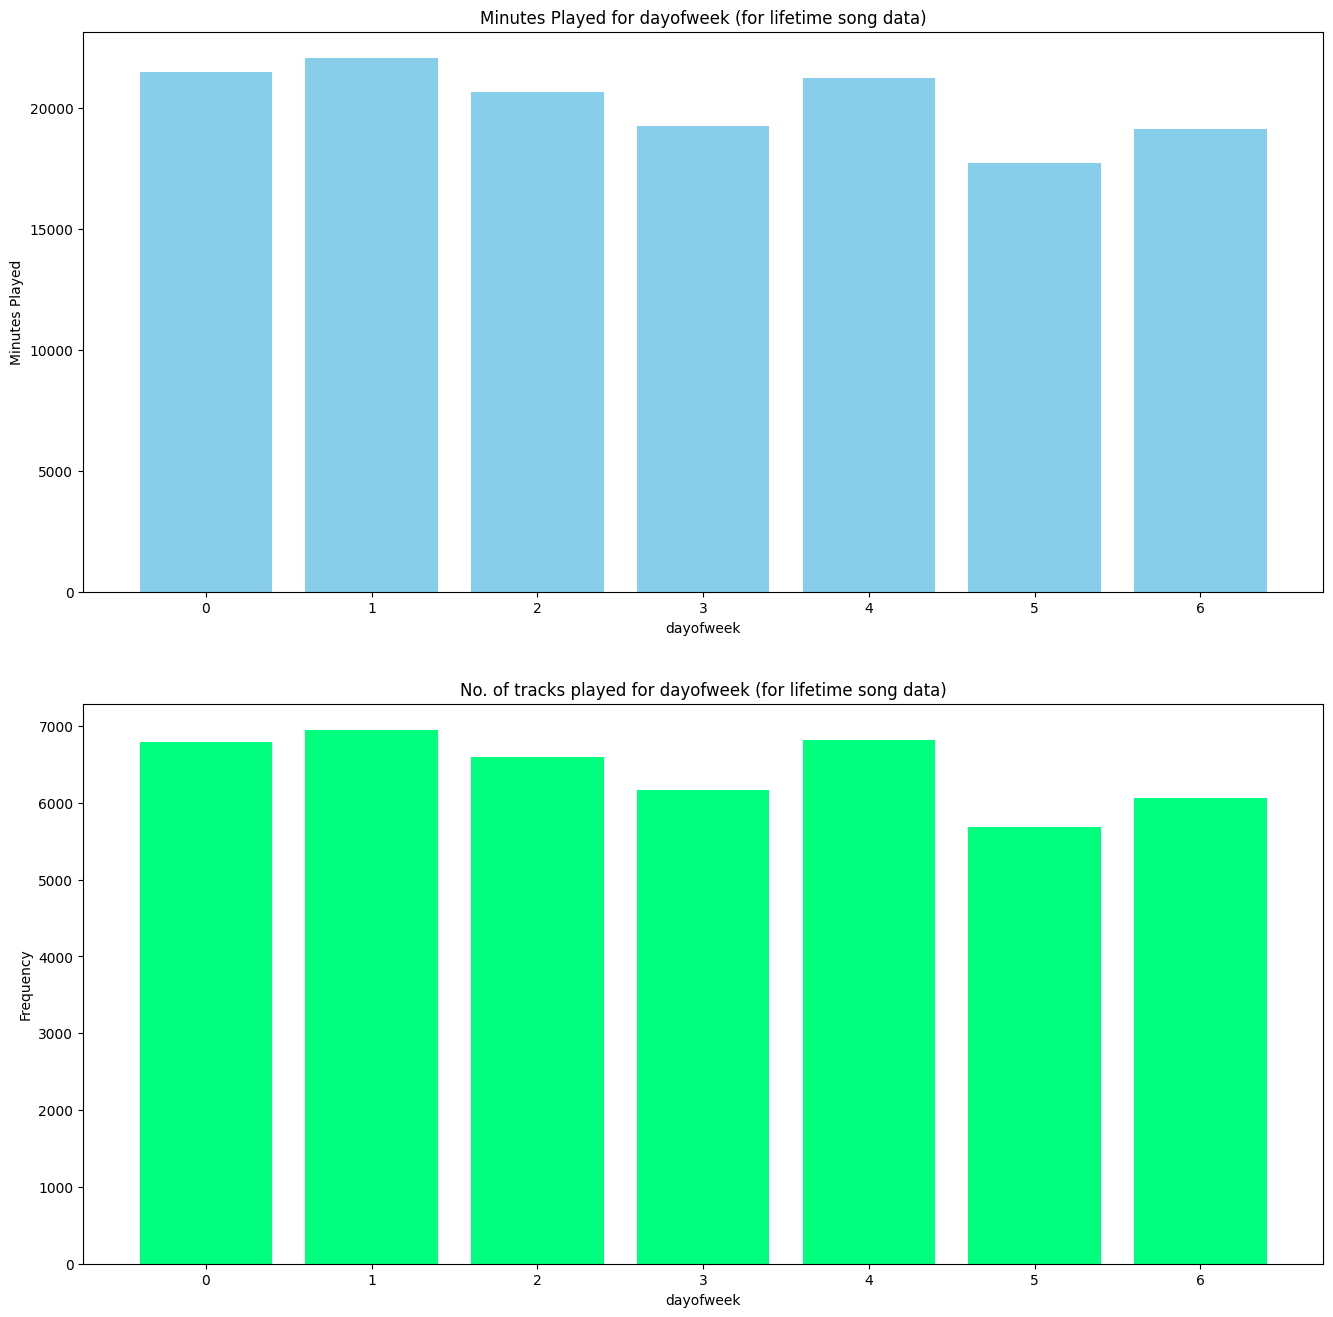

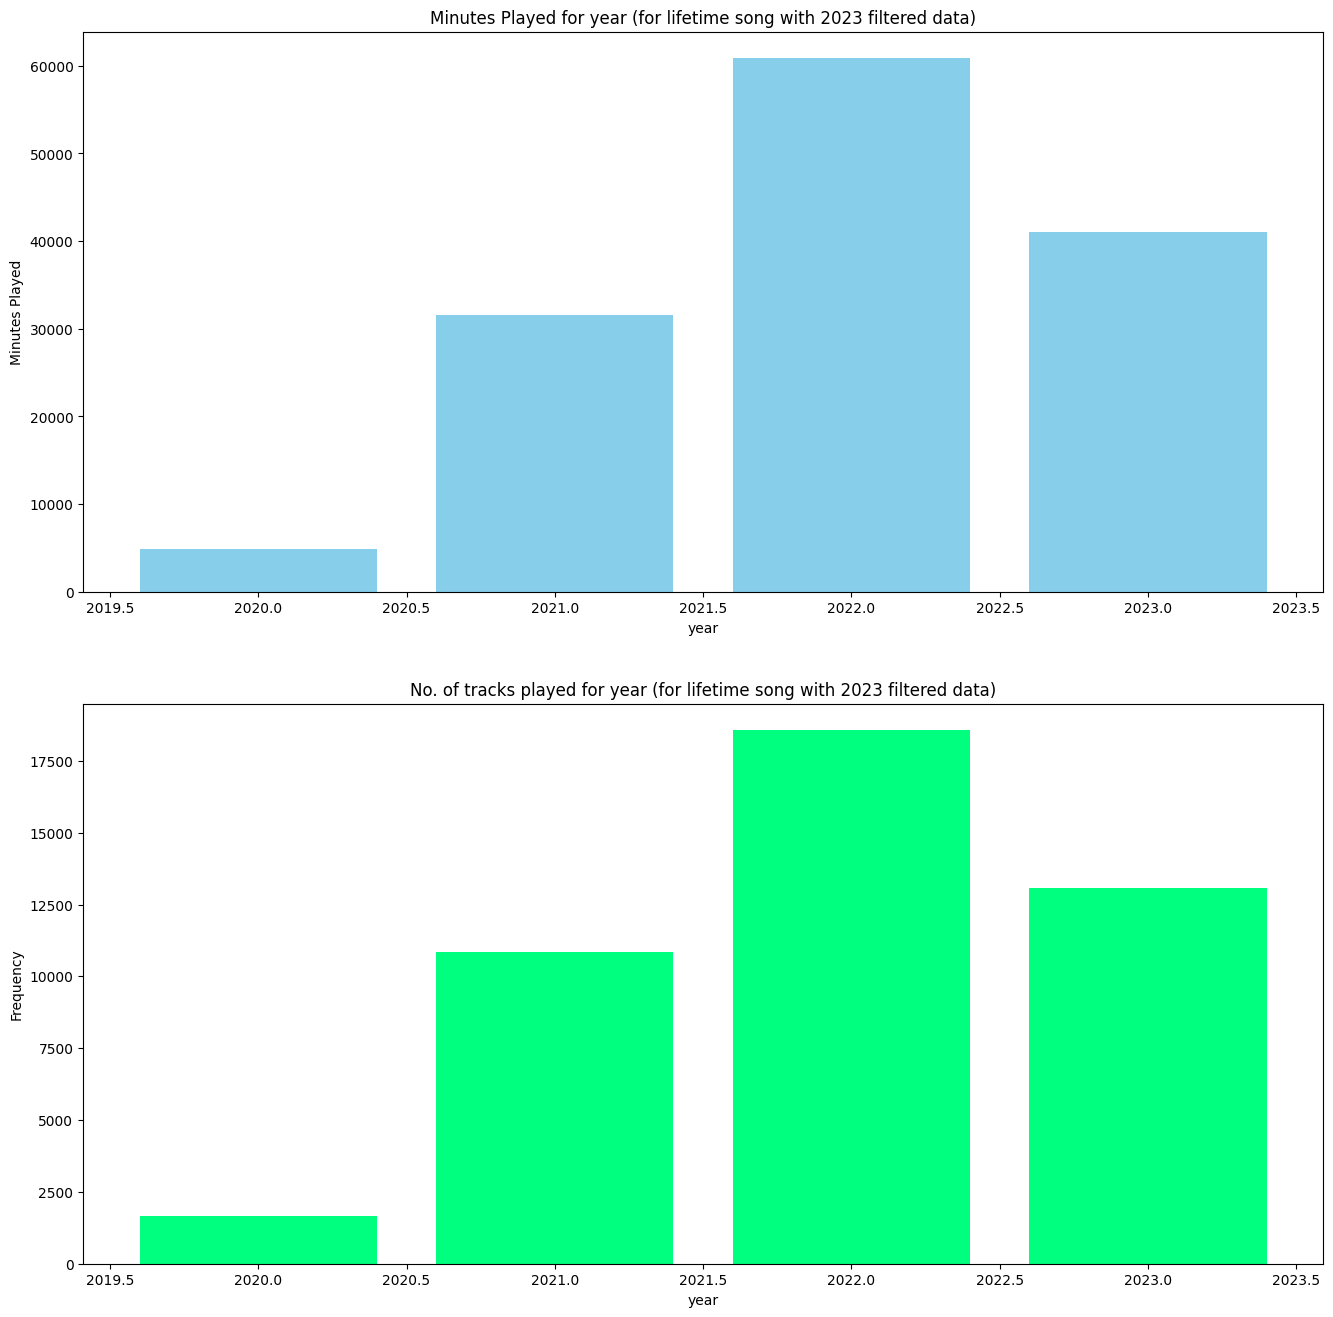

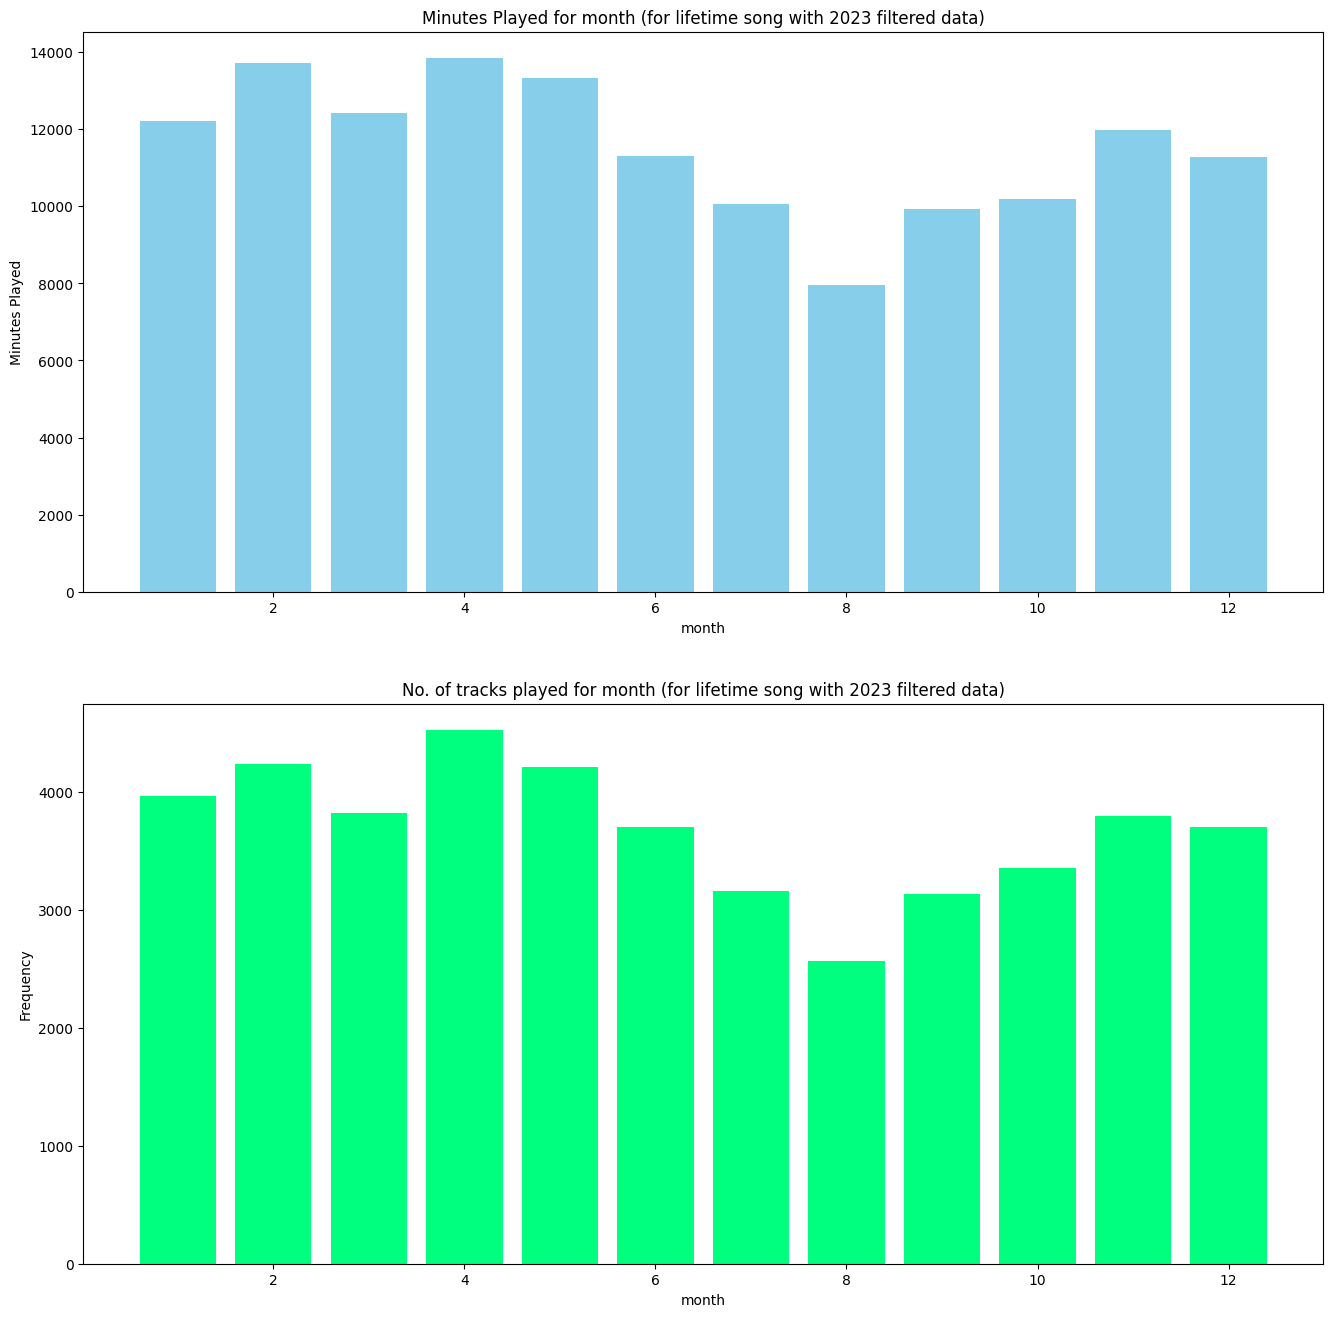

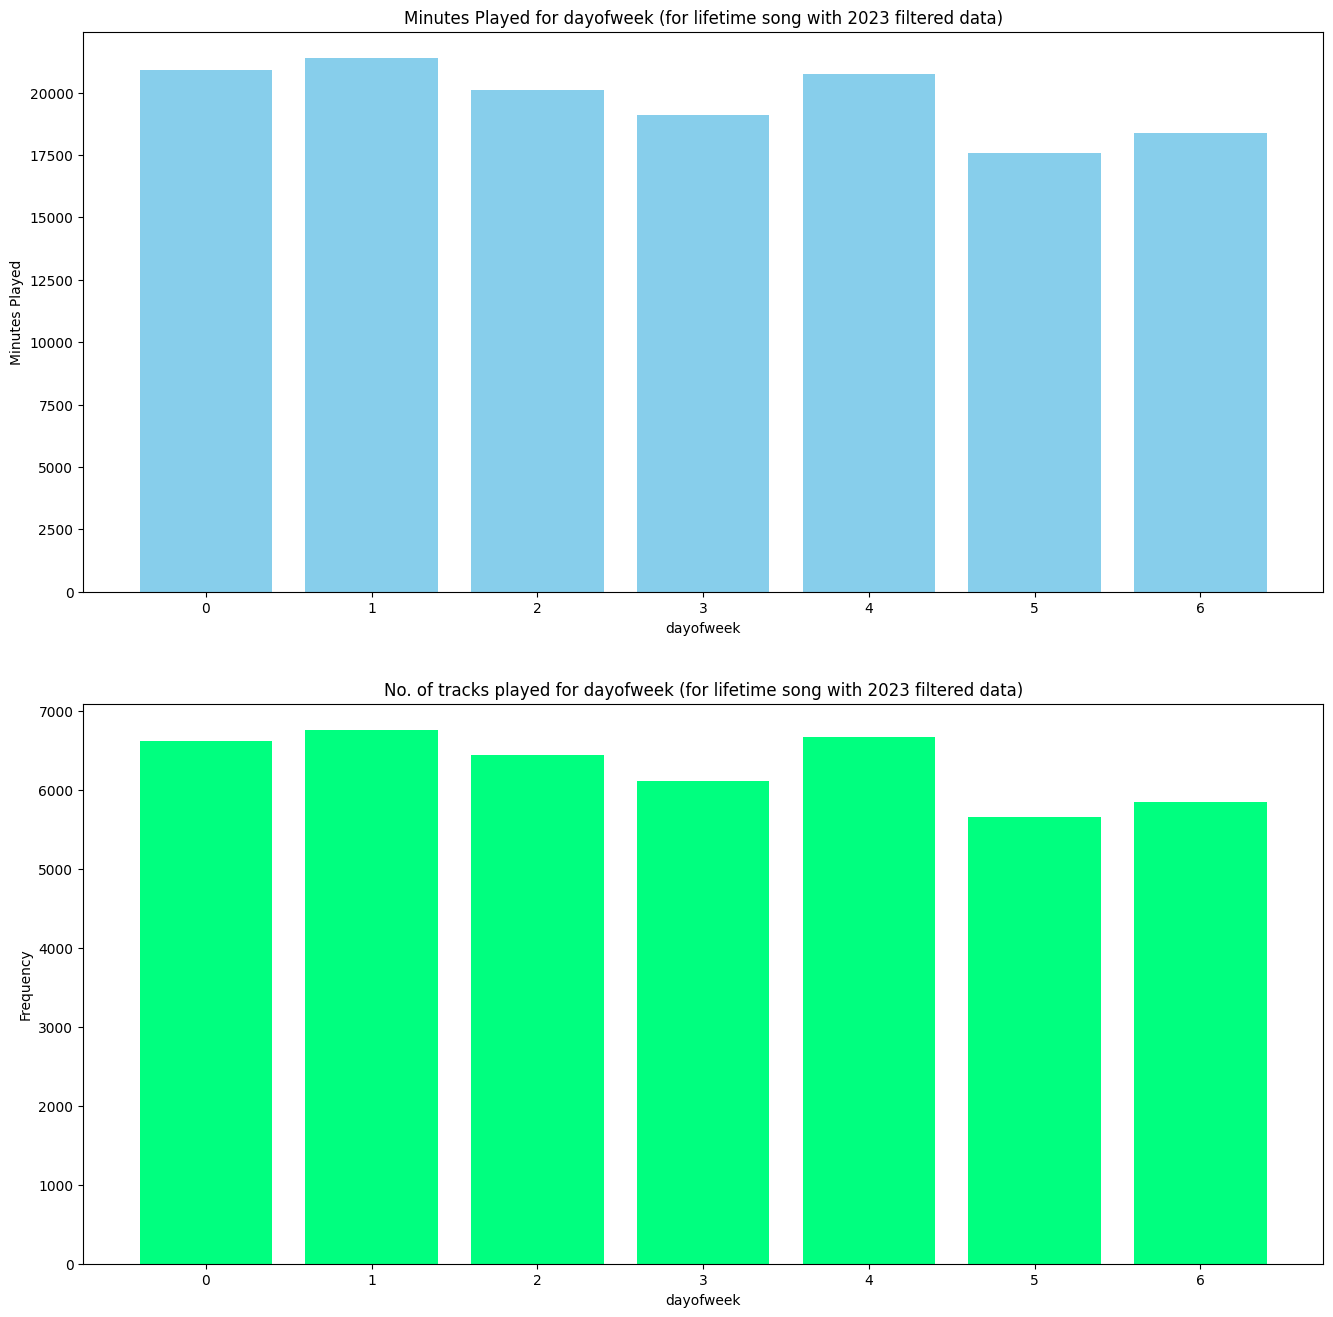

In [32]:
makeplot({"lifetime podcast": podcast,
          "lifetime song": song,
          "lifetime song with 2023 filtered":song_filter},
         ["year", "month", "dayofweek"])

for dayof week: 0 is Monday
* makeplot for podcast dayofweek had no meaning, neither insight, so i removed it 
* same with song with dayofmonth

## Plotting top songs and artists

**some explanation for the following plots (top 20 songs):**<br>
pretty much self explanatory<br>
1. first is ofc through the night, bro i love that song
2. second is the gayatri mantra: calmed me a lot before an exam
3. here we see an disagreement between the filtered and unfiltered data for 2023: hana no uta was a comfort song in 2022 and it being 6:13 long, helps it position
4. afterwards, mostly these are songs from My Playlist #33 and i adore these songs
20. Runaway-Dios: bro i'd everyday listen to this song, i was kinda obsessed

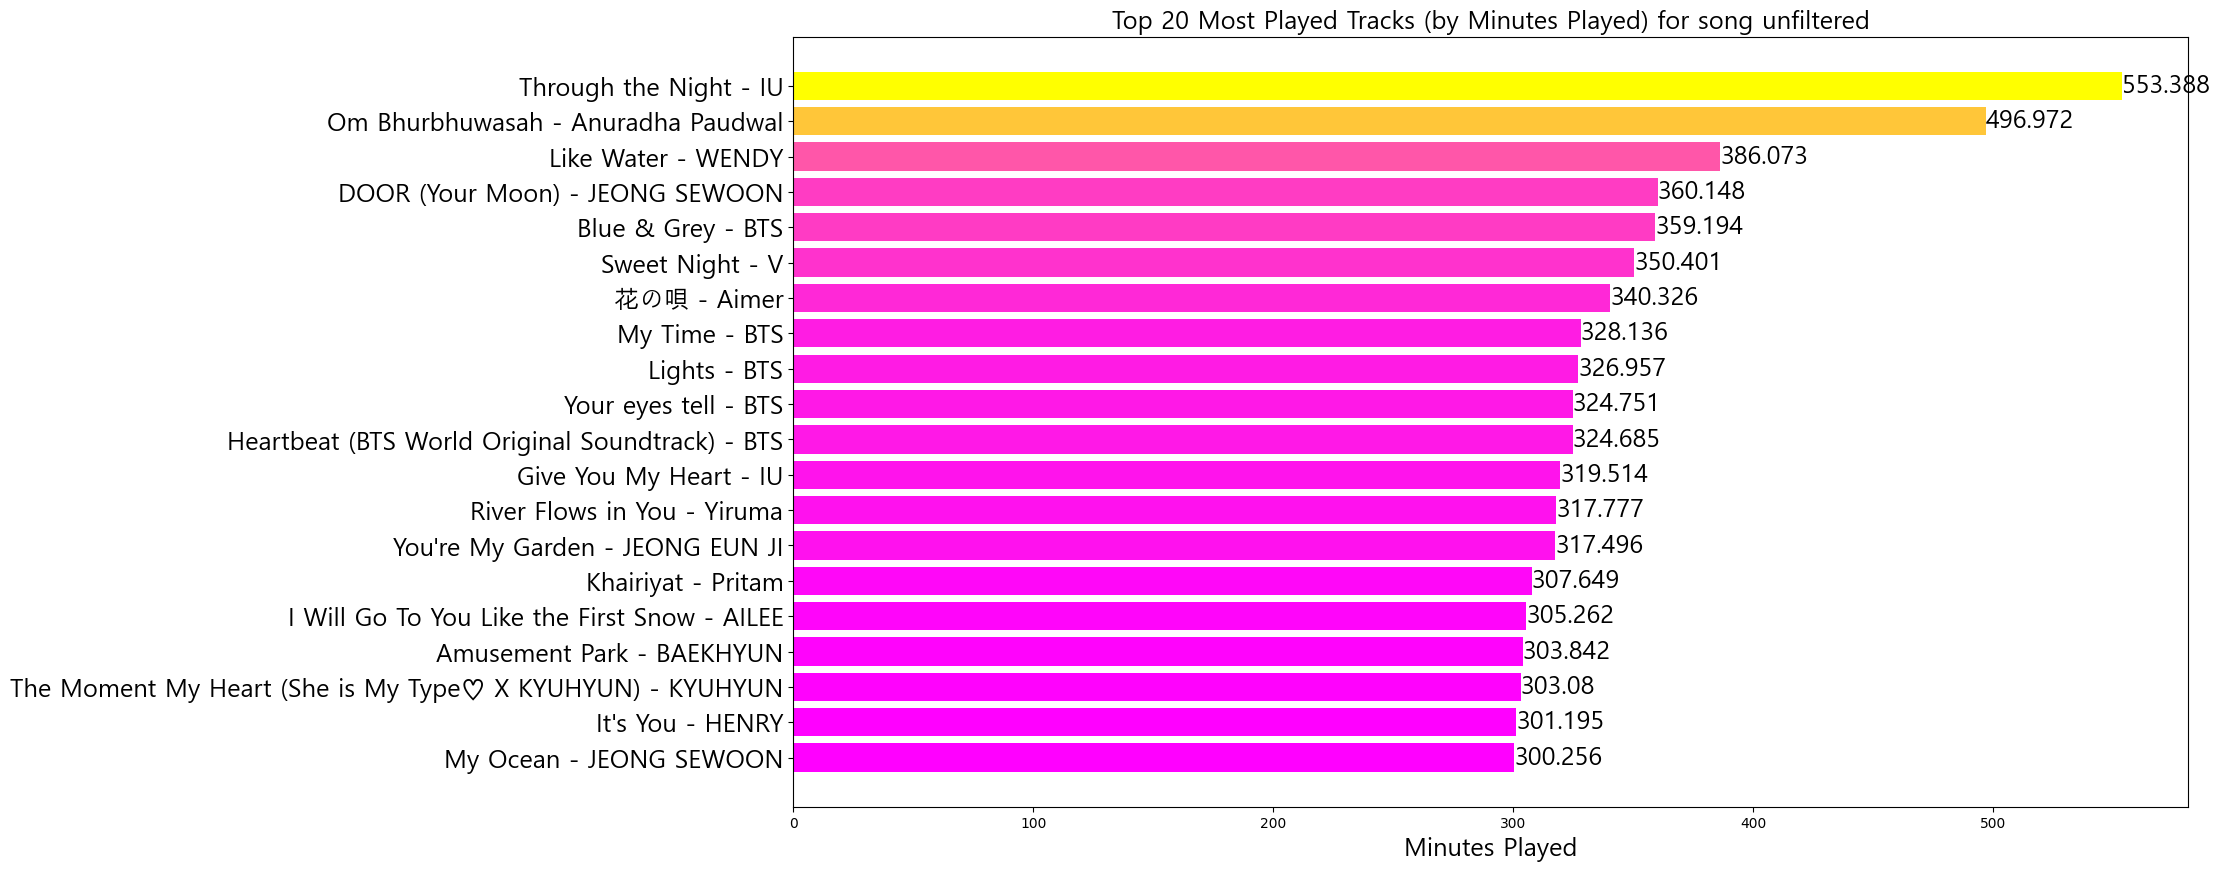

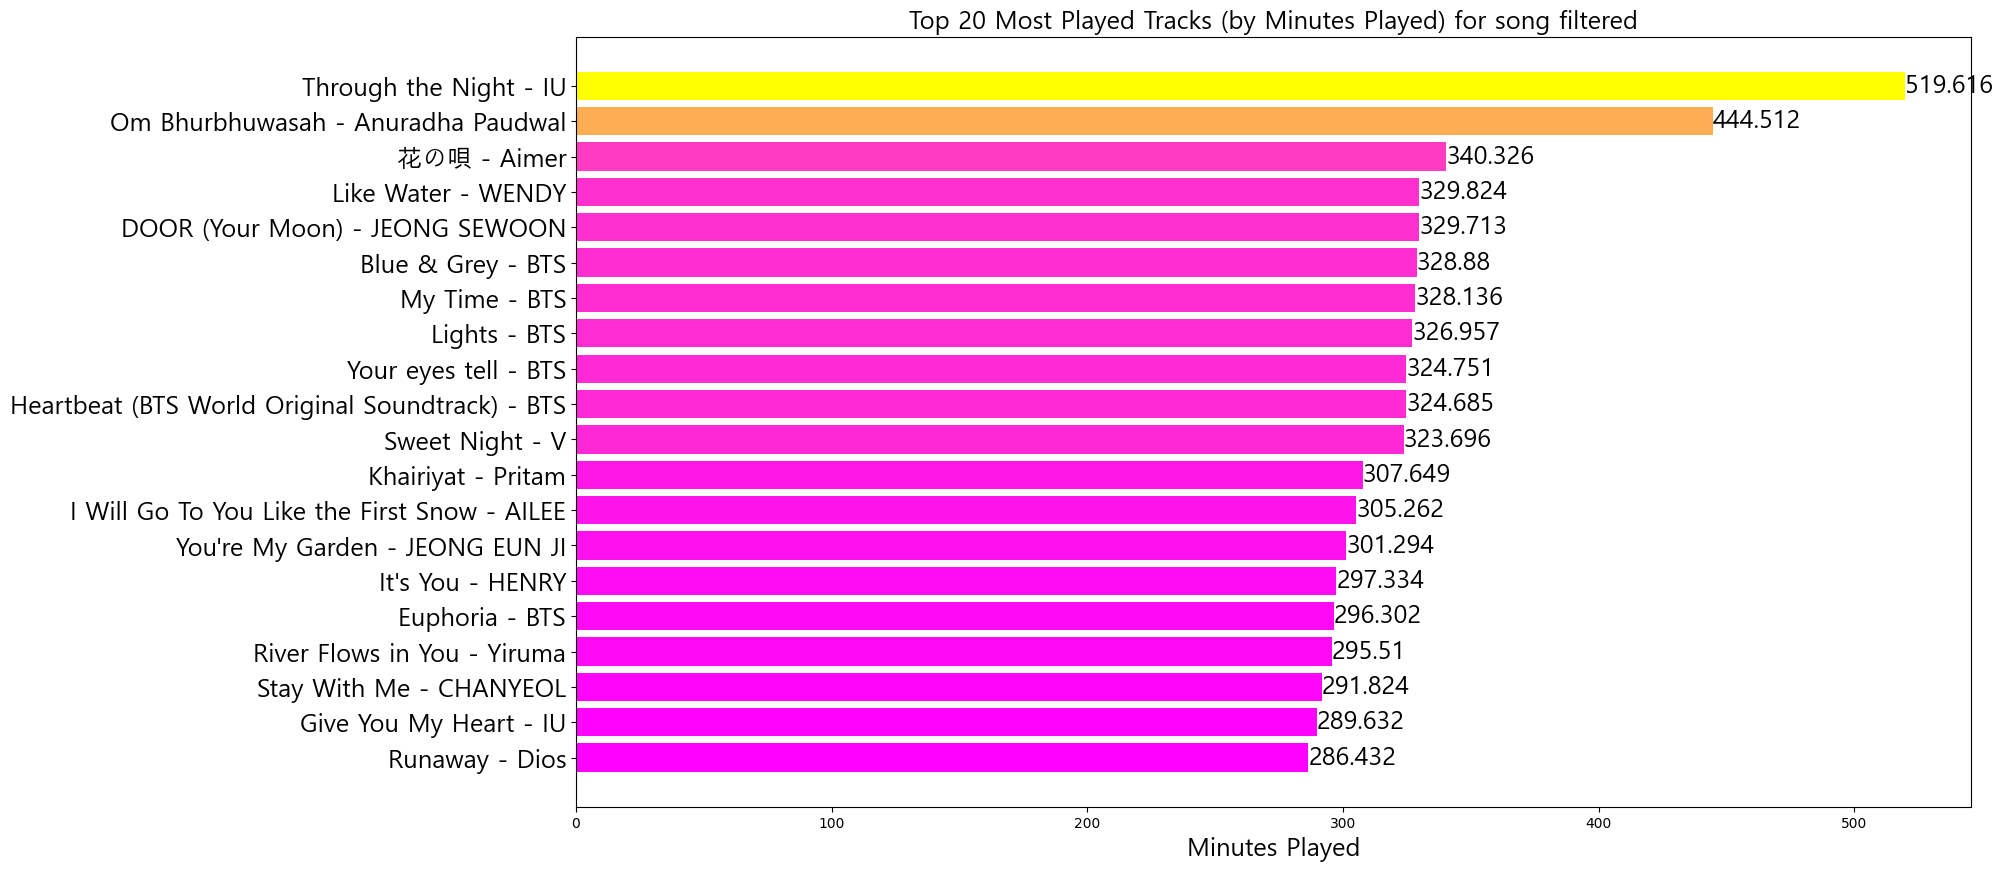

In [33]:
song_dict = {}
for key, val in {"song unfiltered":song, "song filtered":song_filter}.items():
    val["song-artist"] = val["master_metadata_track_name"] + " - " + val["master_metadata_album_artist_name"]
    sorted_songs = sorted(list(set(val["song-artist"])))

    sorted_time = (val.groupby("song-artist")["ms_played"].sum())/(60*1000)
    sorted_time.reset_index(drop=True, inplace=True)

    sorted_freq = val["song-artist"].value_counts().reindex(sorted_songs)
    sorted_freq.reset_index(drop=True, inplace=True)

    song_dict[key] = pd.DataFrame({"Track Name": sorted_songs,
                             "Minutes Played": sorted_time,
                             "No. of Times Played": sorted_freq})
makeplot_20(song_dict, "Track", x='Minutes Played')

In [34]:
song_dict["song unfiltered"].to_csv("song-unfiltered-track-sum.csv")
song_dict["song filtered"].to_csv("song-filtered-track-sum.csv")

### Making Artist Data DataFrame

**some explanation for the following plots (top 20 artists):**<br>
1. BTS: ofc it's BTS: 2020-2021 was their era in my life. there discography is so diverse. afterwards too, their songs are so embedded in my playlists, their songs just came around while listening and i didn't even notice.
2. IU: i so adore her. 2022 was her time, i needed comfort, i found comfort. if i write more, i'd be just simping
3. TWICE: the top girl group, a big portion of their songs are really good and some are top tier
4. HEIZE: similar discography to IU but less diverse, I had an R&B obsession in 2021 and her discography was much of R&B. her songs too, are embedded so deep in my playlists, same situation as BTS
5. Aimer: a good chunk of 2022 was spent on her songs: great songs (and the top and only japanese singer in the top 20 list). 
6. Taeyeon: late 2023 and 2024 (spoiler) was the time i actually discovered her songs. she's on the same level as IU, now i guess she'd be much up on the list.
ig it'll be tmi now

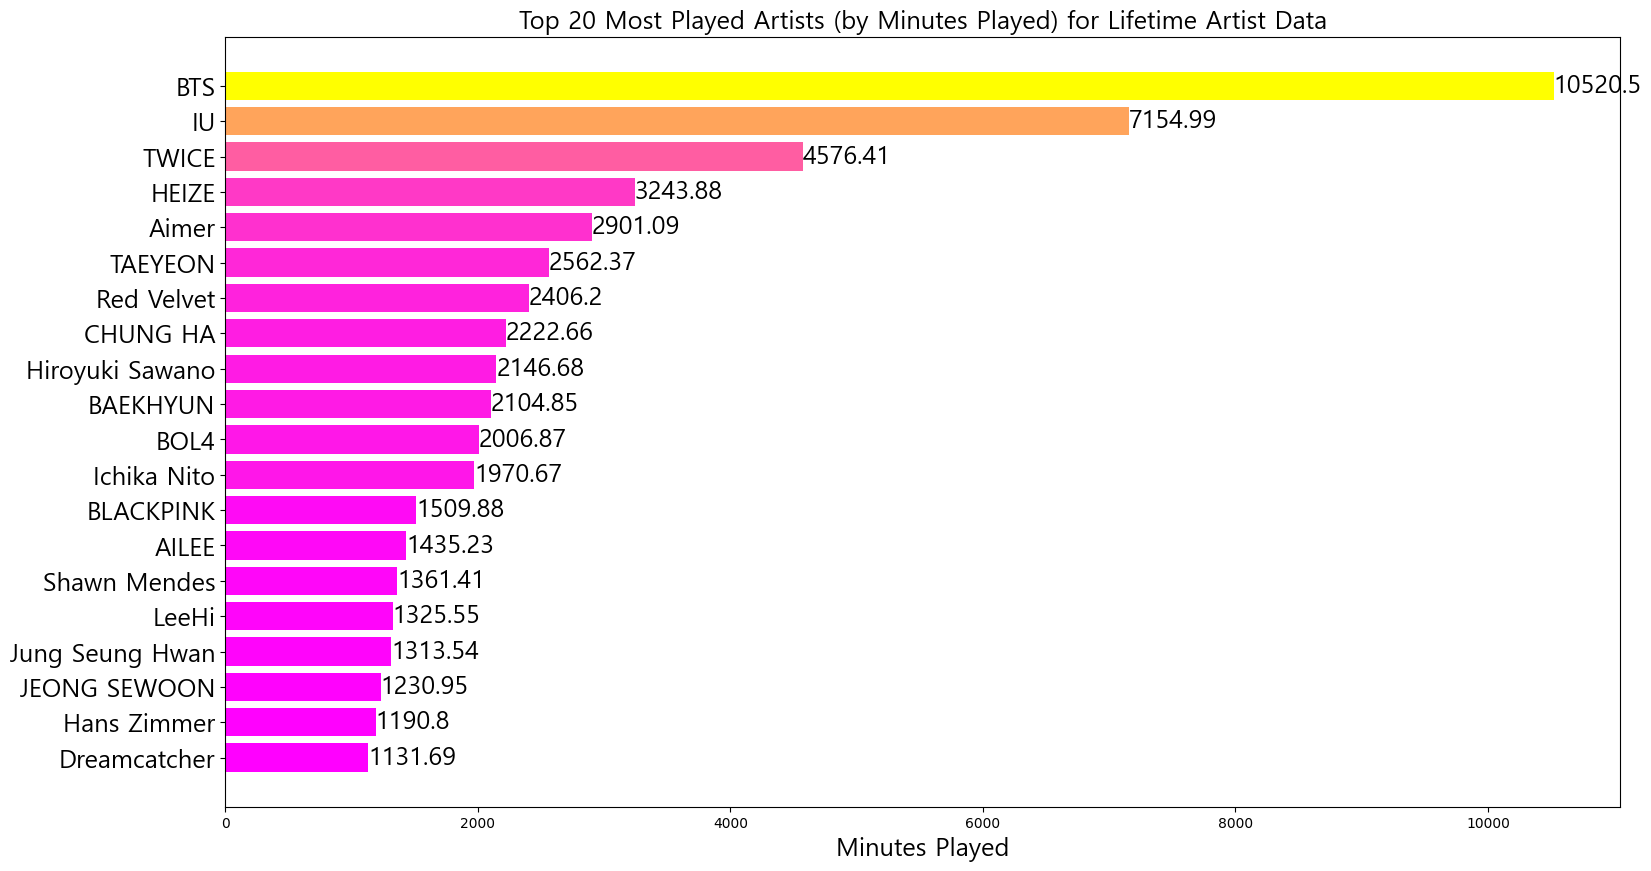

In [35]:
sorted_artist = sorted(list(set(song["master_metadata_album_artist_name"])))

sorted_time = (song.groupby("master_metadata_album_artist_name")["ms_played"].sum())/(60*1000)
sorted_time.reset_index(drop=True, inplace=True)

sorted_freq = song["master_metadata_album_artist_name"].value_counts().reindex(sorted_artist)
sorted_freq.reset_index(drop=True, inplace=True)

artist_df = pd.DataFrame({"Artist Name": sorted_artist,
                         "Minutes Played": sorted_time,
                         "No. of Times Played": sorted_freq})
makeplot_20({"Lifetime Artist Data": artist_df}, "Artist", 'Minutes Played')

### Making plot for hour of day

`song["timeofday"] = song.ts.dt.time`

`song["hourofday"] = song.ts.dt.hour`

**some explanation for the following plots (hourly):**<br>
* 11 PM is highest because that is the time i wanted to study but was sleepy, music stopped sleep
* 8 PM is low because i ate dinner (mostly) during this hour
* self explanatory

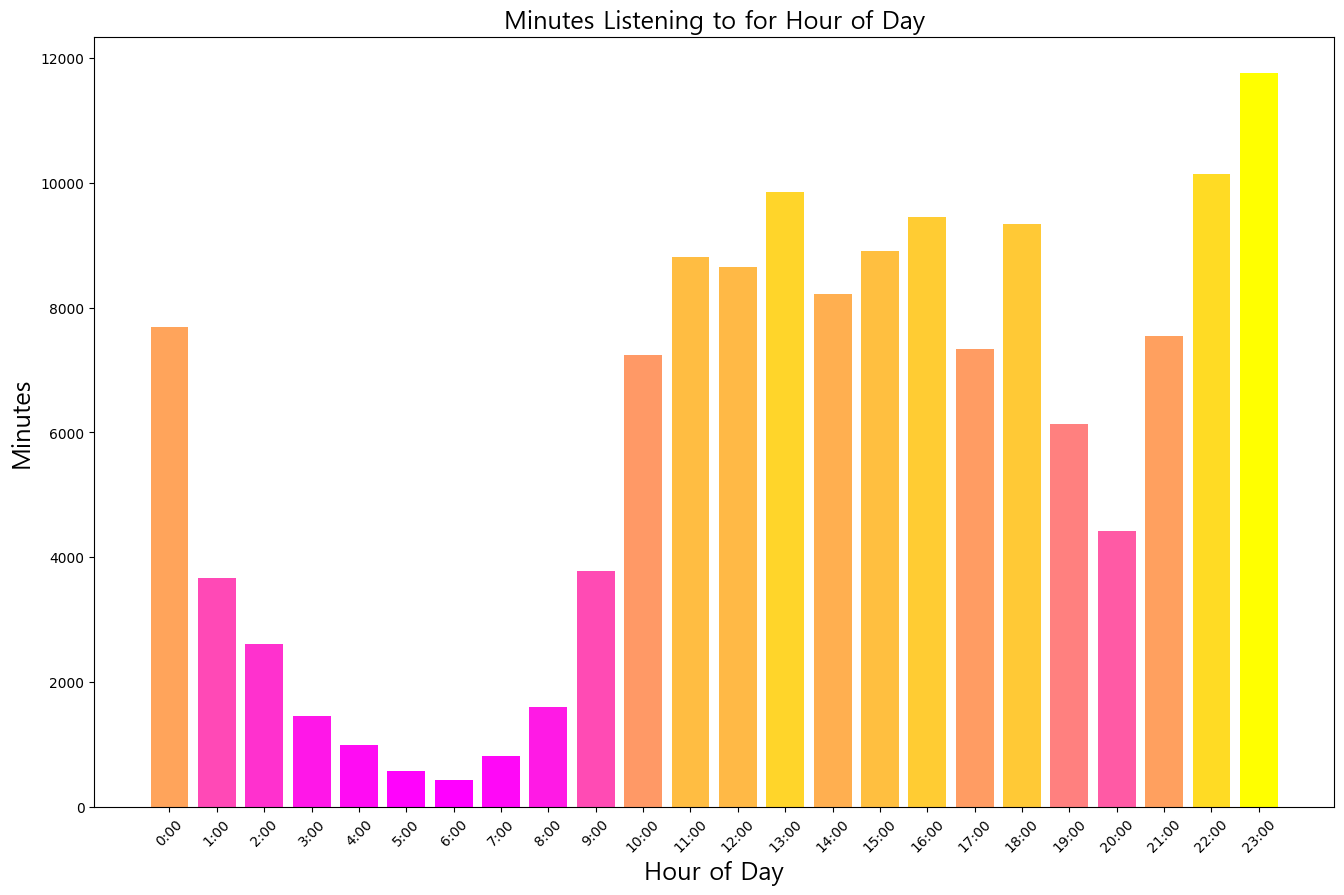

In [36]:
hour_list = []
for i in range(24):
    h = f"{i}:00"
    hour_list.append(h)
    
norm = plt.Normalize(min((song.groupby("hourofday")["ms_played"].sum())/(60*1000)), 
                     max((song.groupby("hourofday")["ms_played"].sum())/(60*1000)))

plt.figure(figsize=(16,10));

sorted_hour = (song.groupby("hourofday")["ms_played"].sum())/(60*1000)

plt.bar(height=sorted_hour, x=hour_list,
       color=cmap(norm((song.groupby("hourofday")["ms_played"].sum())/(60*1000))));
plt.xticks(rotation=45);
plt.xlabel("Hour of Day", fontproperties=malgun_font);
plt.ylabel("Minutes", fontproperties=malgun_font);
plt.title("Minutes Listening to for Hour of Day", fontproperties=malgun_font);

In [37]:
year_dict = {"2023_filtered": df20231, "2023": df2023, "2022": df2022, "2021": df2021, "2020": df2020}

**some explanation for the following plots (trends over the years):**<br>
1. Minutes for 2023 (filtered or otherwise, trends are same): 
    * feb - end sems,
    * april - study time for mid sems, 
    * july-aug - short vacation and a bit free time from academics, 
    * oct-nov - bad times (don't wanna go back)<br>

2. dayofweek 2023: friday is the least: i didn't study on fridays. **the data has strong correlation to my study hours (can't prove it, sadly)**<br>

3. Minutes for 2022: (interesting, deserves points) :
    * jan-mar - studied most here (most anxious here, figures) mostly consisted of sad(?) songs
    * apr-jun - decreasing trend, JEE was postponed, now mostly consisted of attack on titan ost. JEE actually came around
    * jul - kinda forced myself to study
    * aug-sep - i was so free, didn't study and it shows
    * oct - busy with preparations for college and actually went
    * nov-dec - mid sems and boy was i scared
<br>
4. 2021: may - started studying while listening to music (discovered the K-R&B playlist, and binged it all day everyday) ((other than this, i don't remember shit and won't strain my brain))
5. 2020: almost nothing before september, then it started

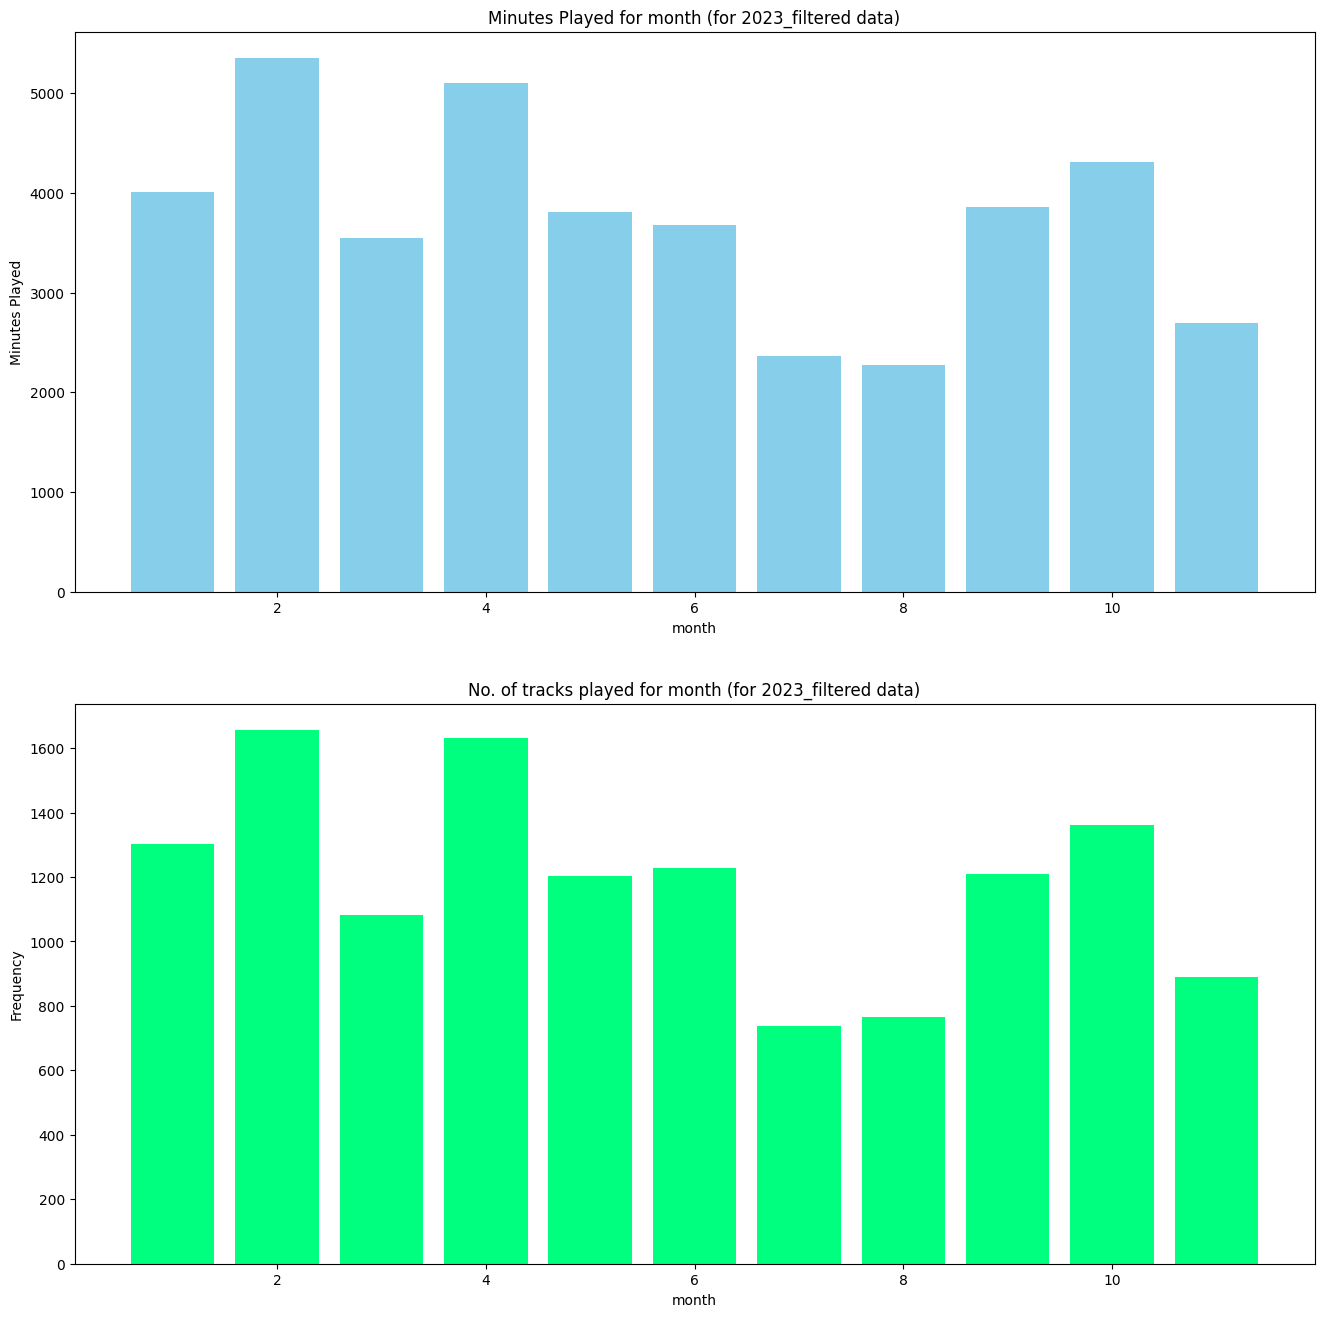

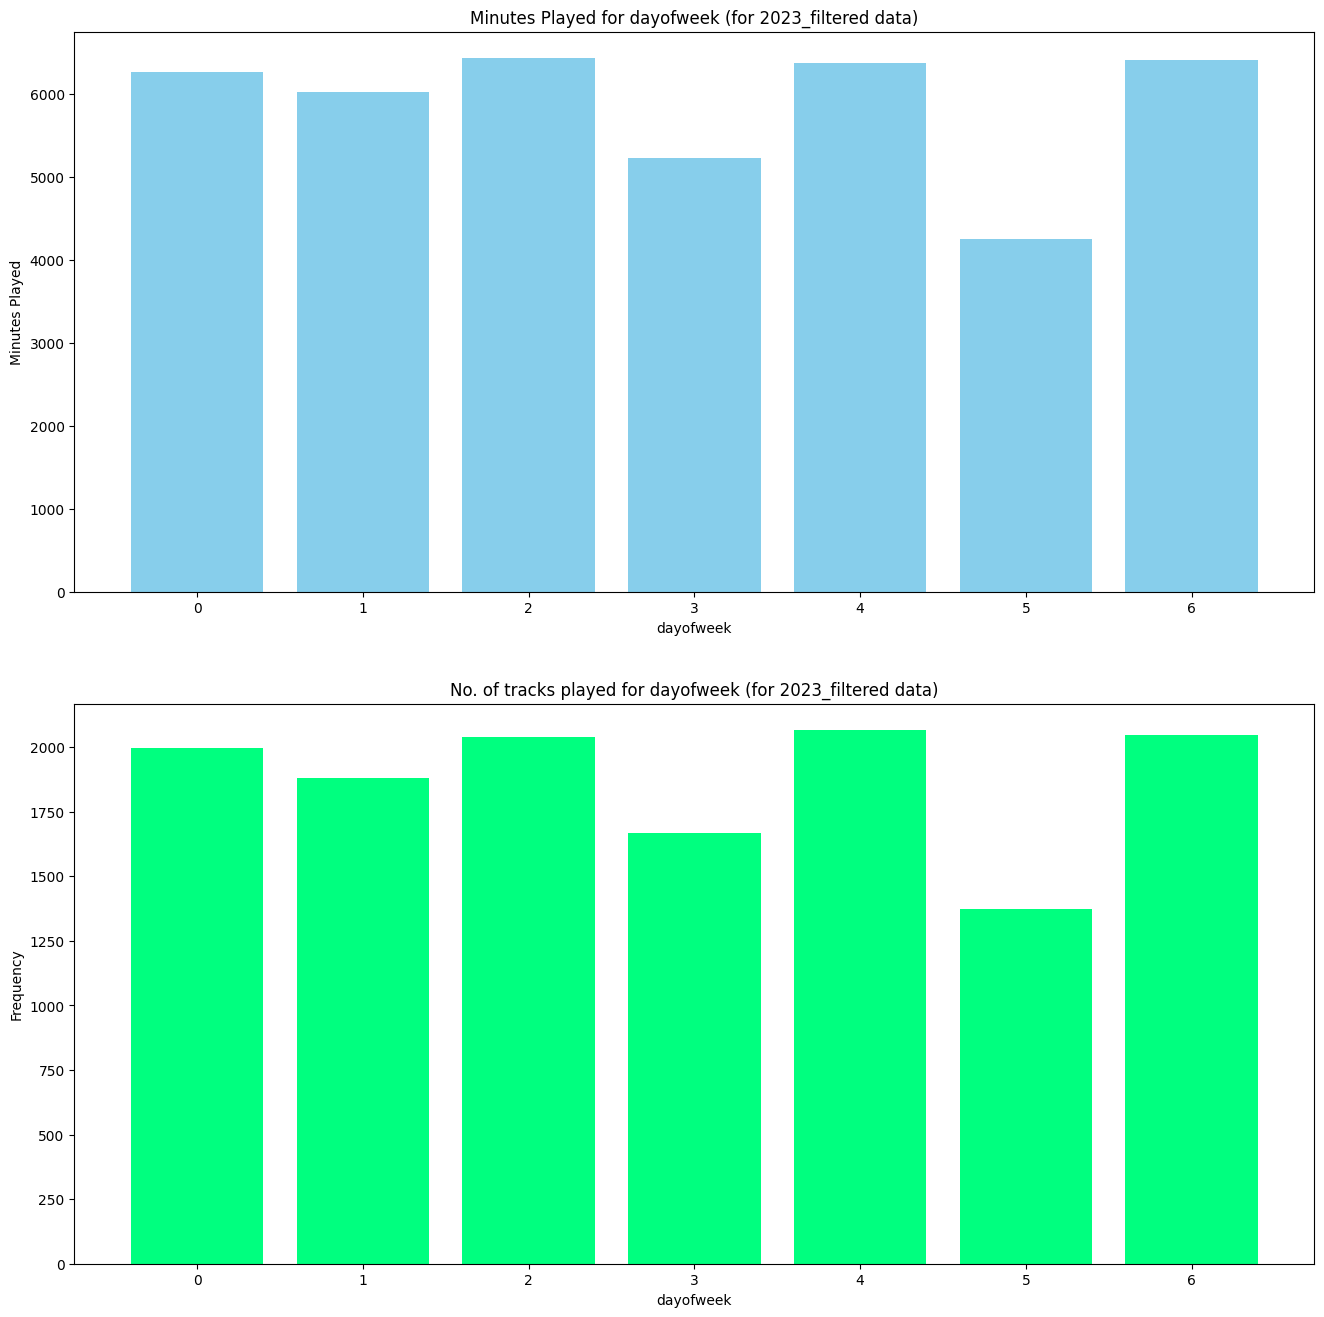

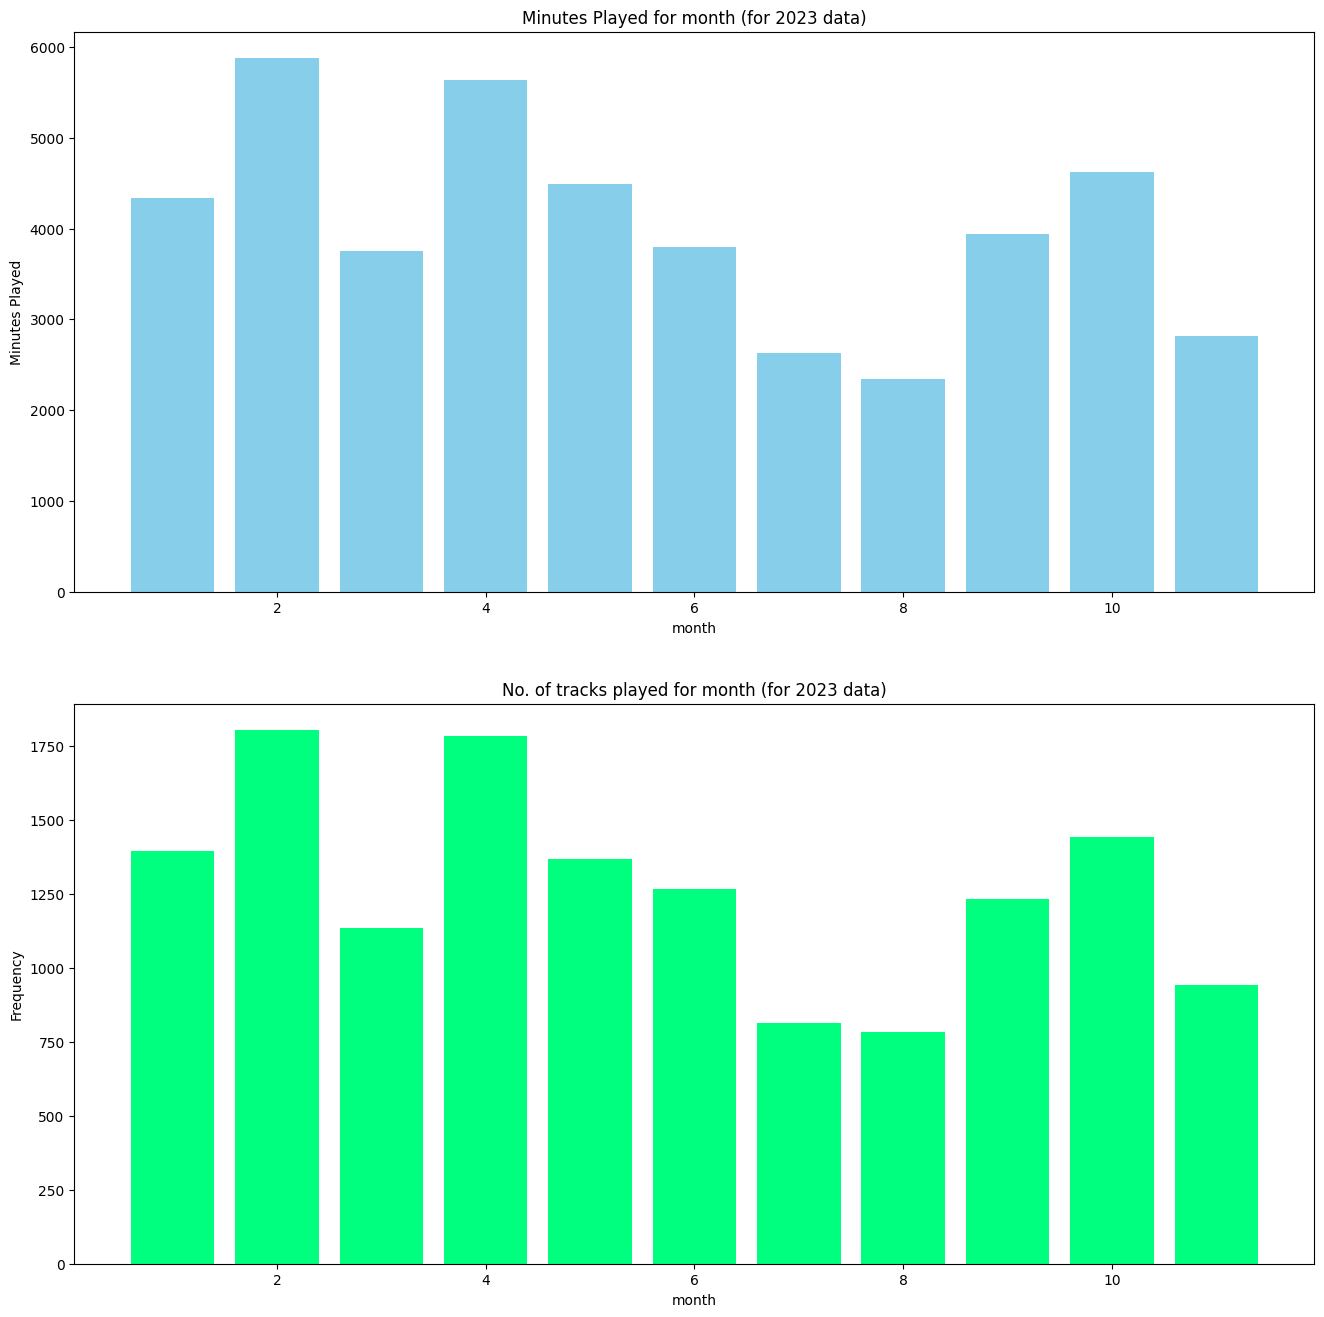

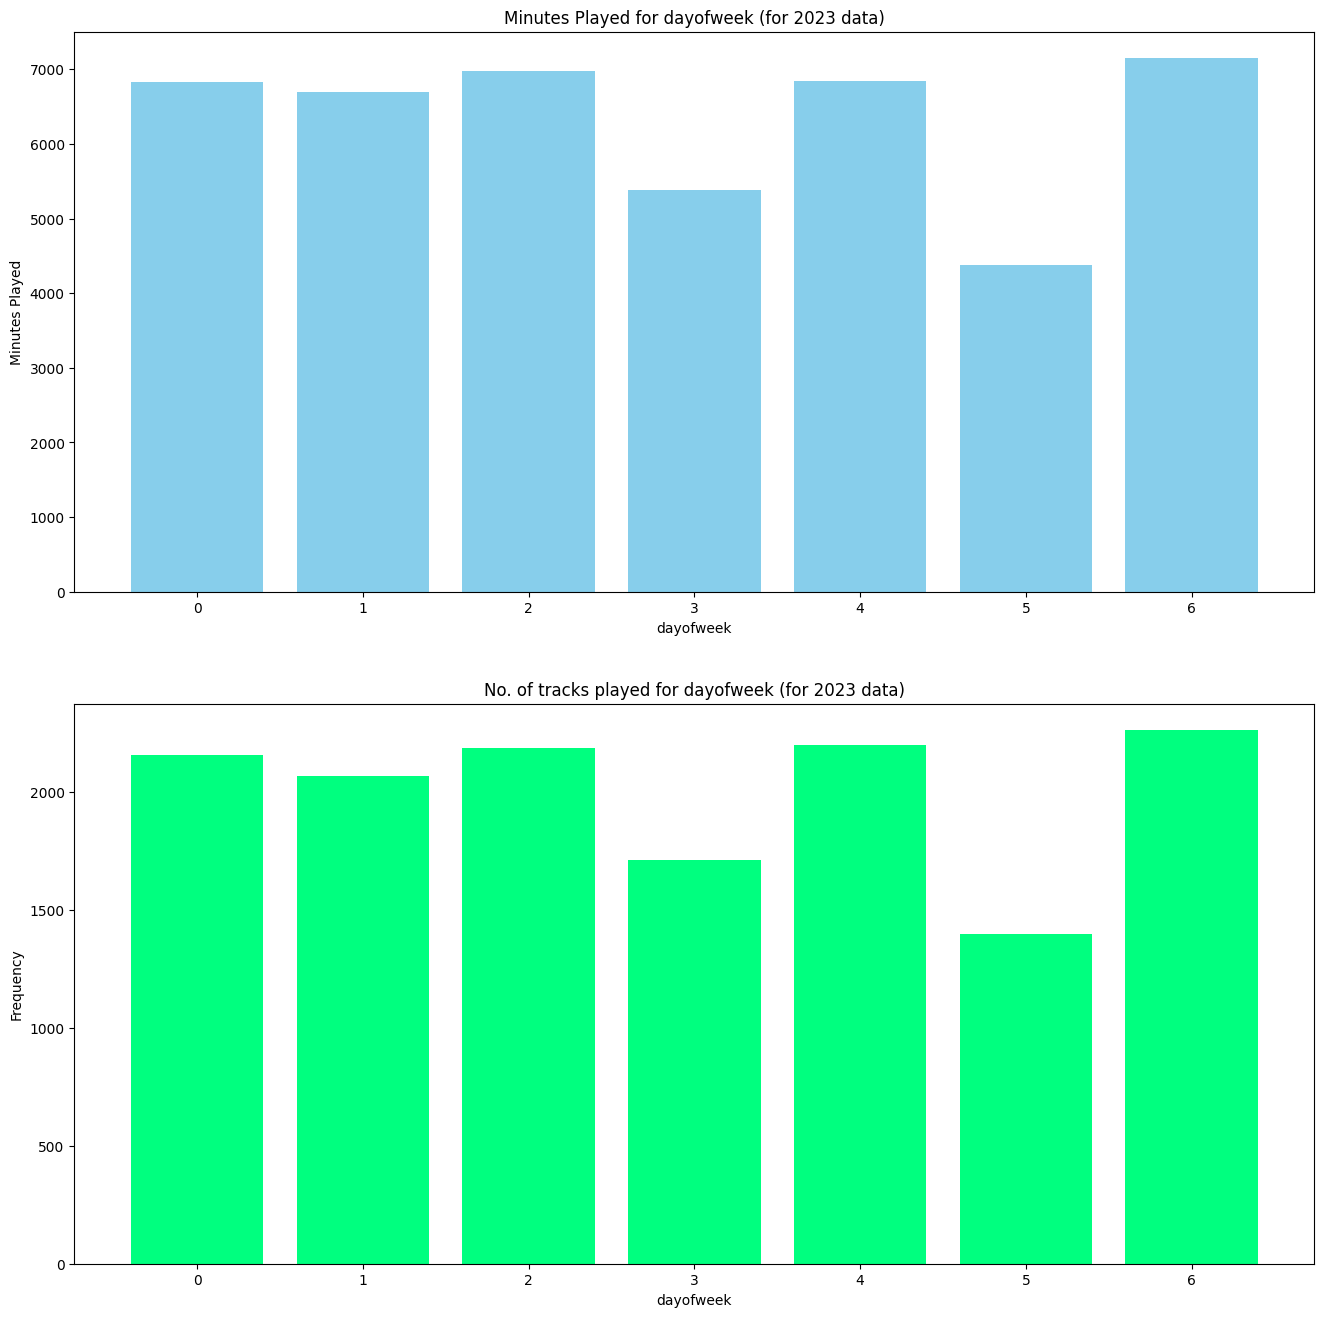

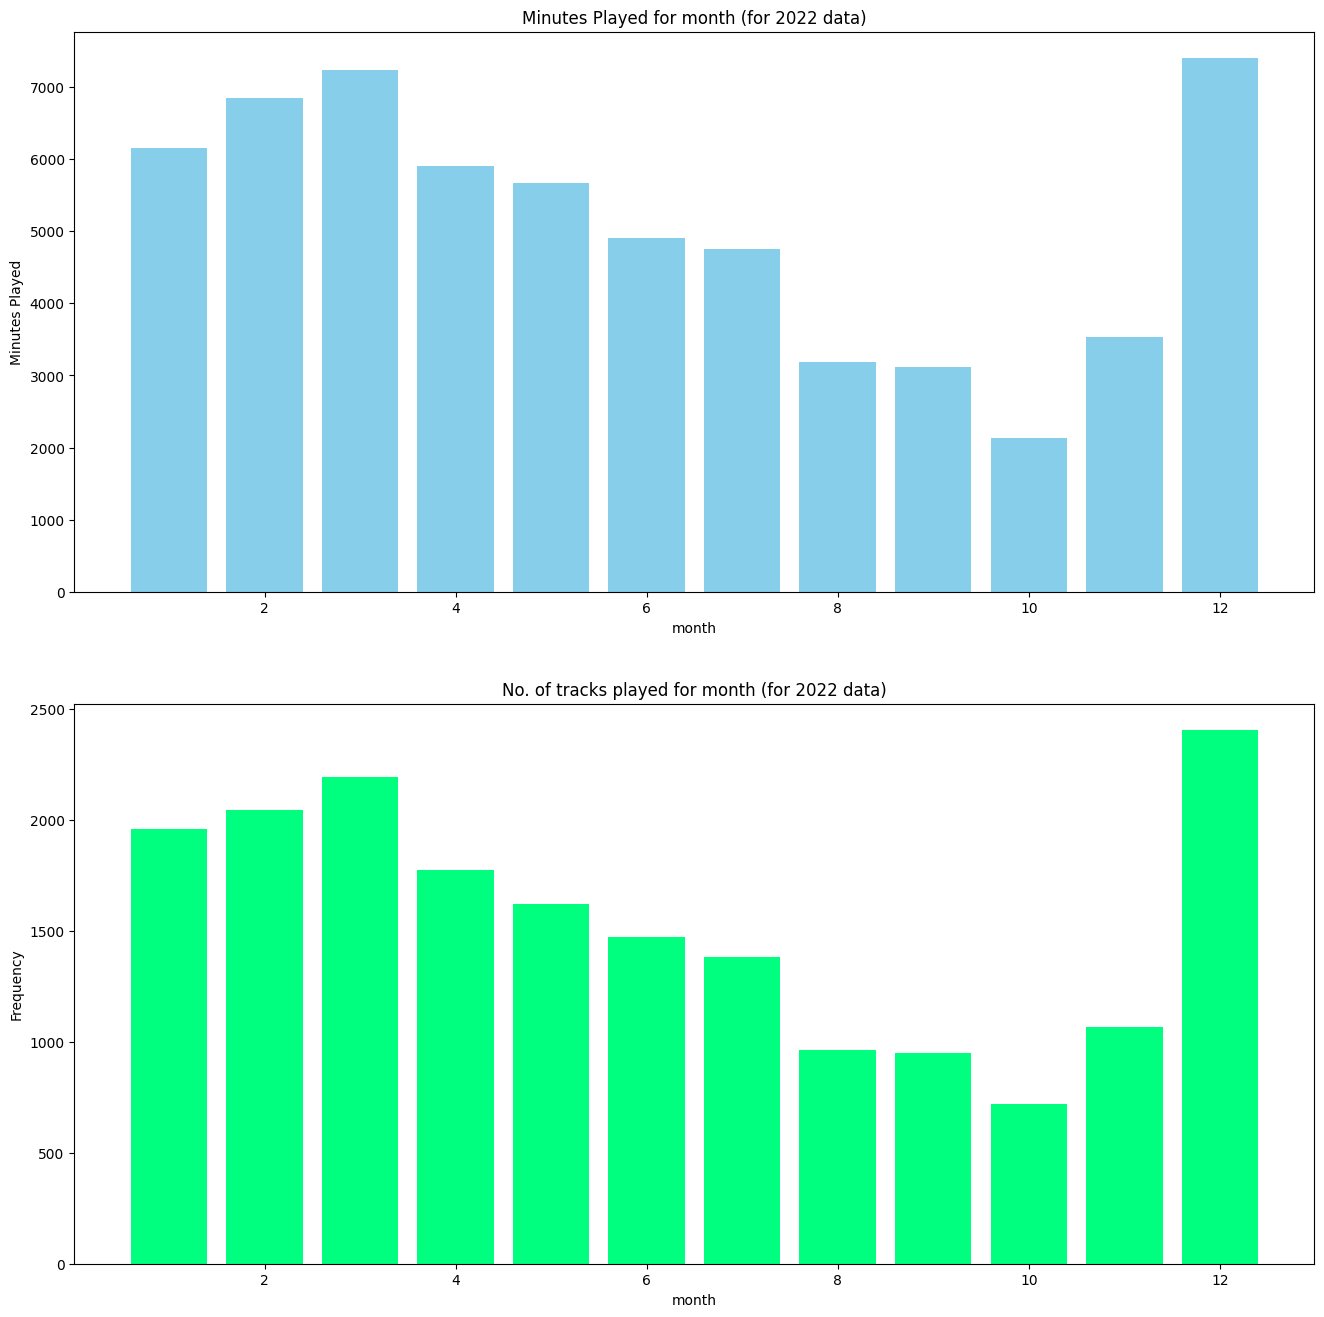

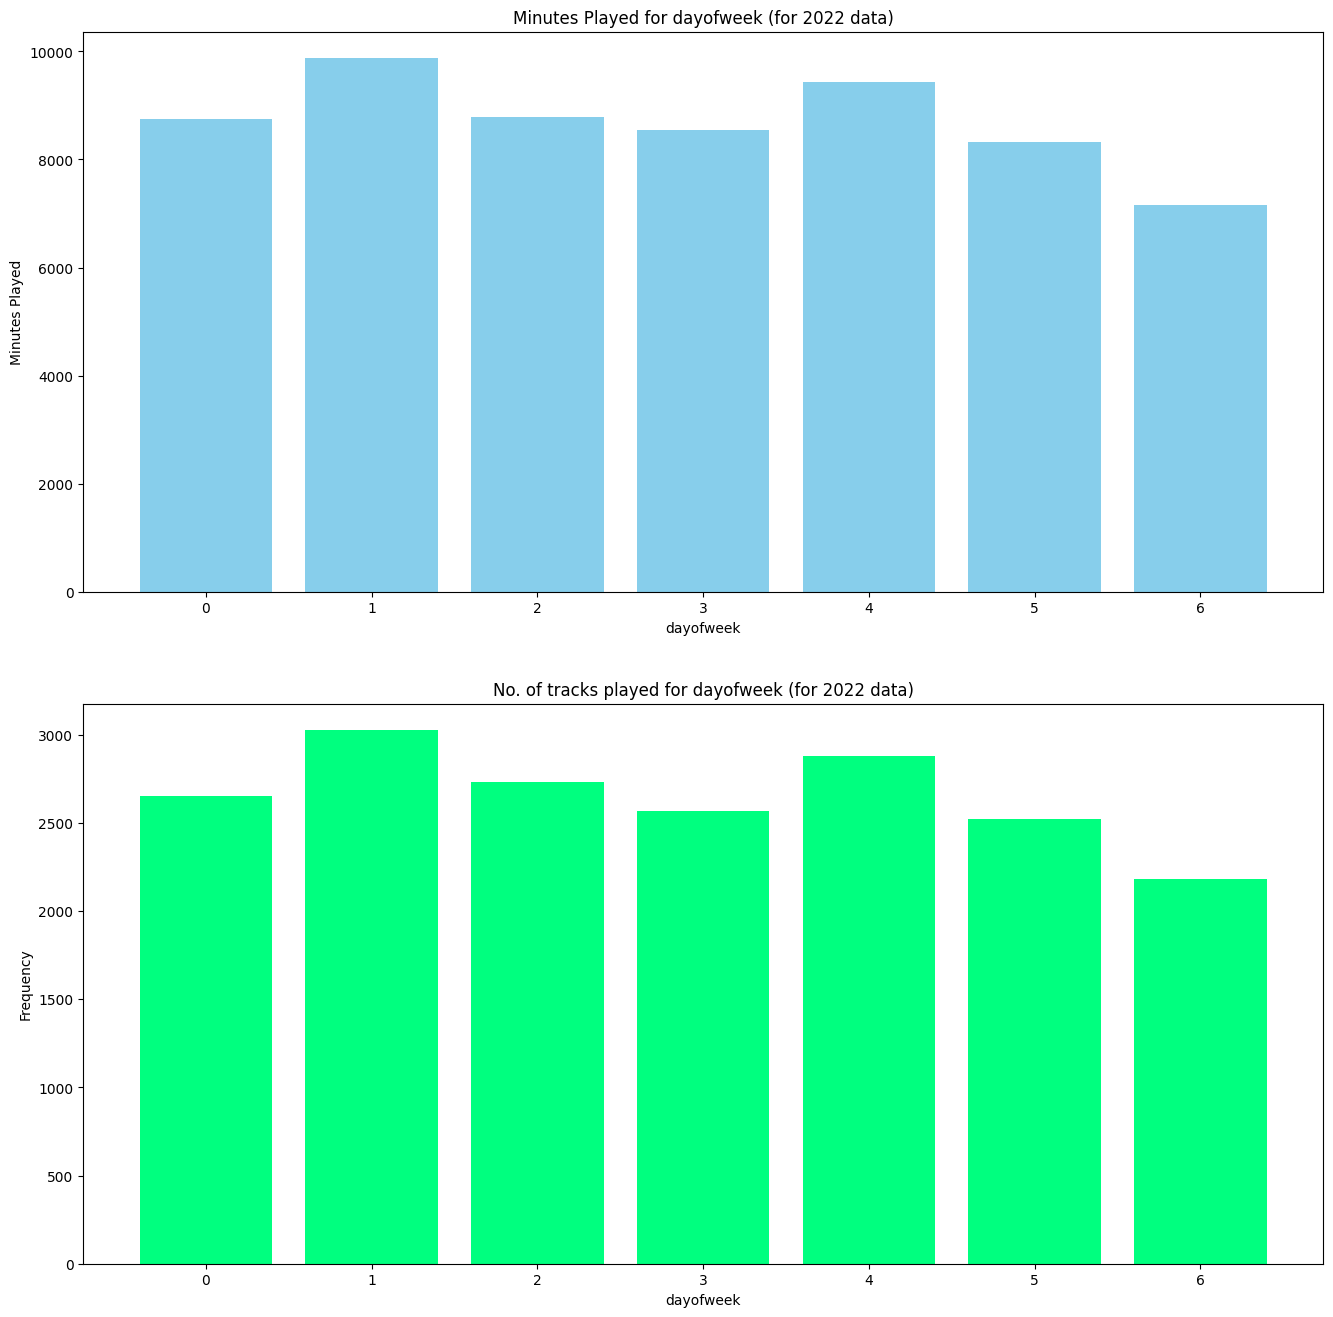

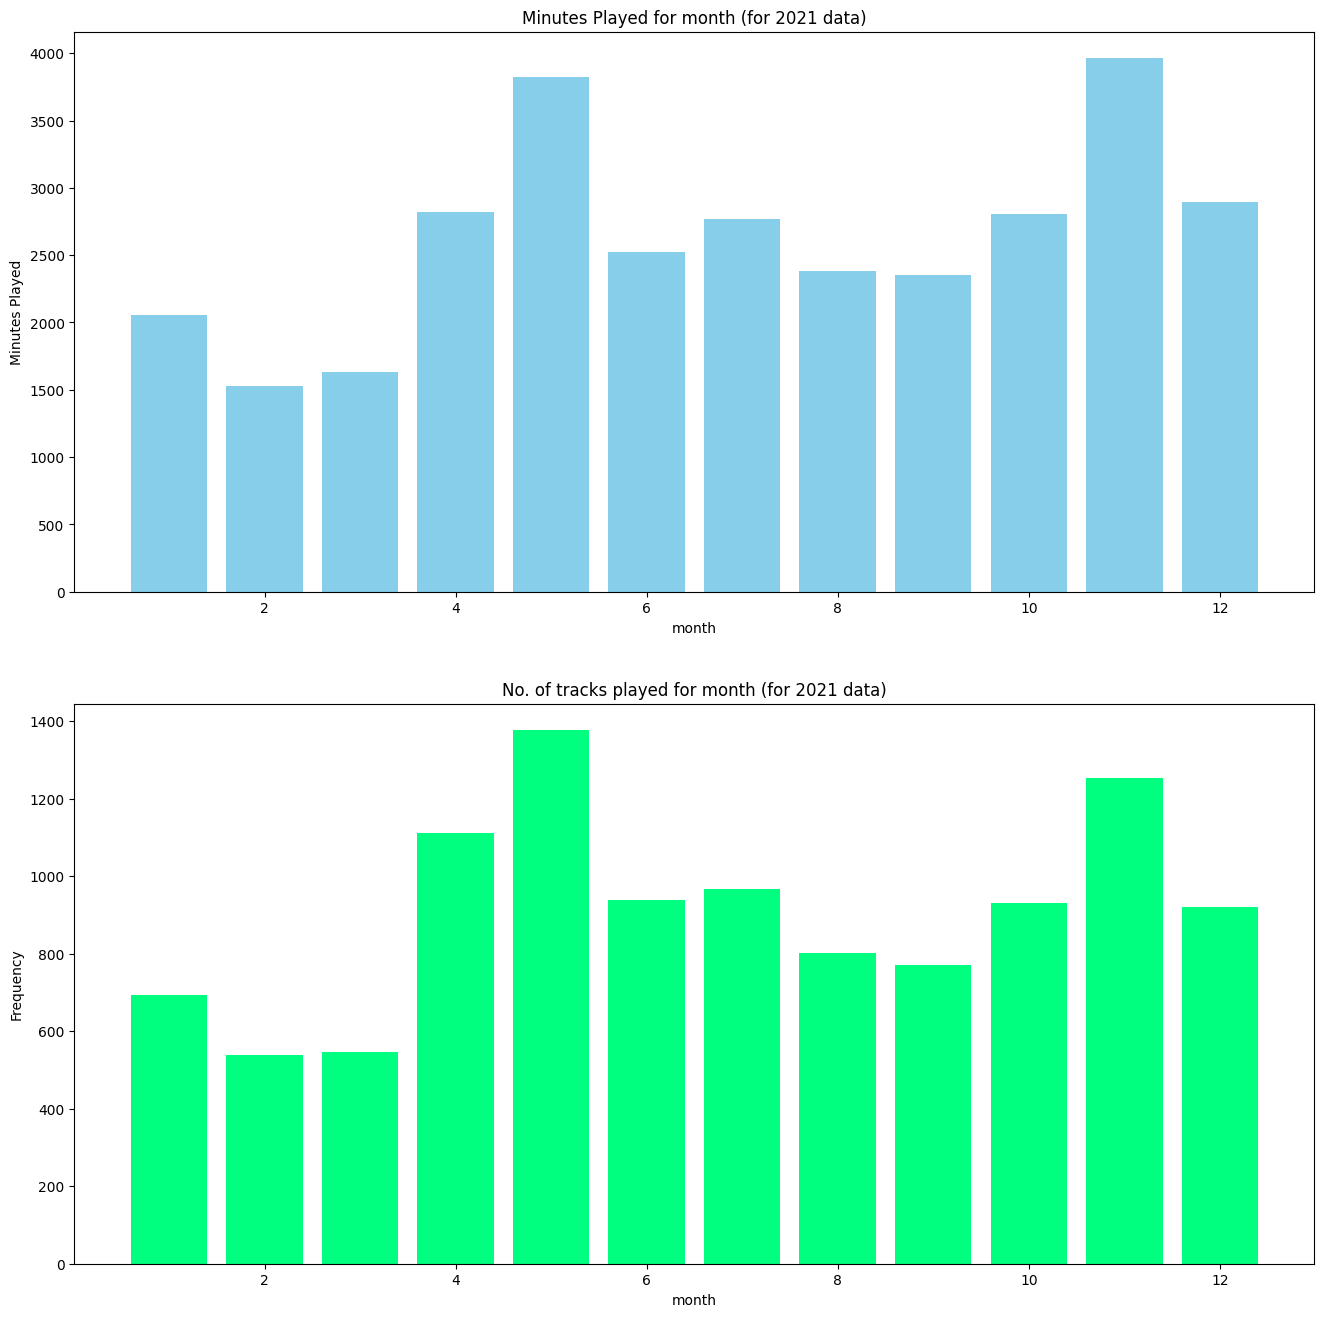

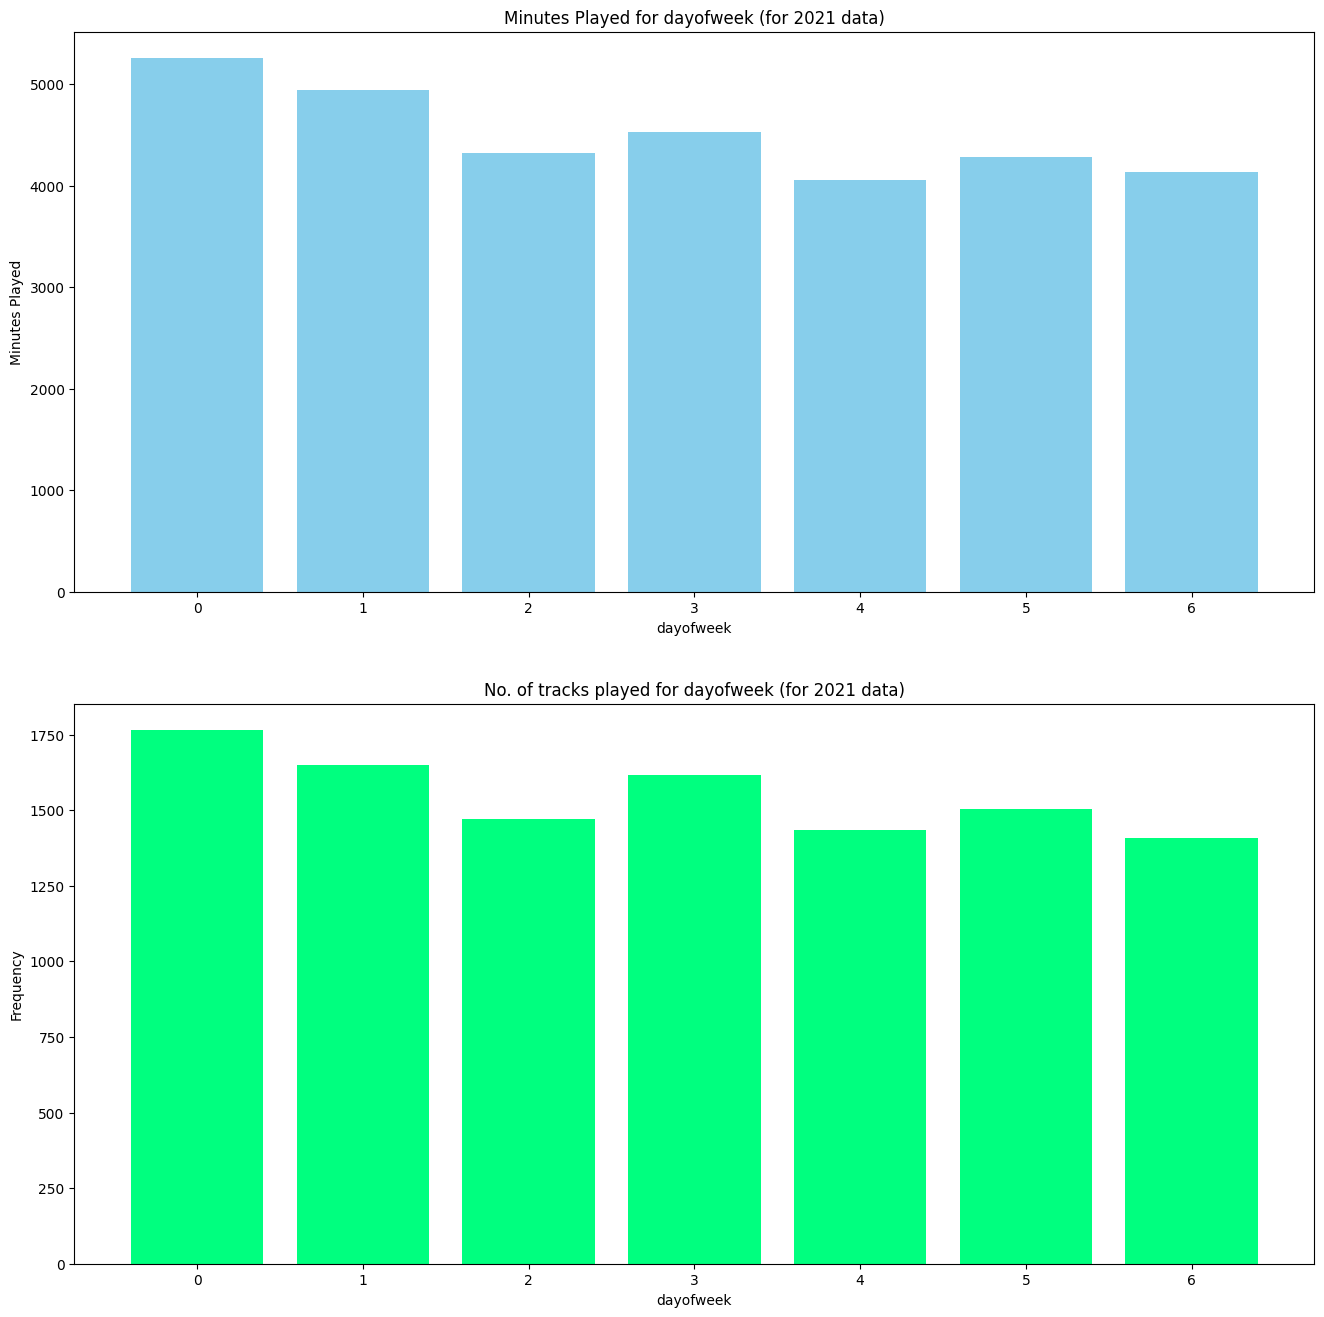

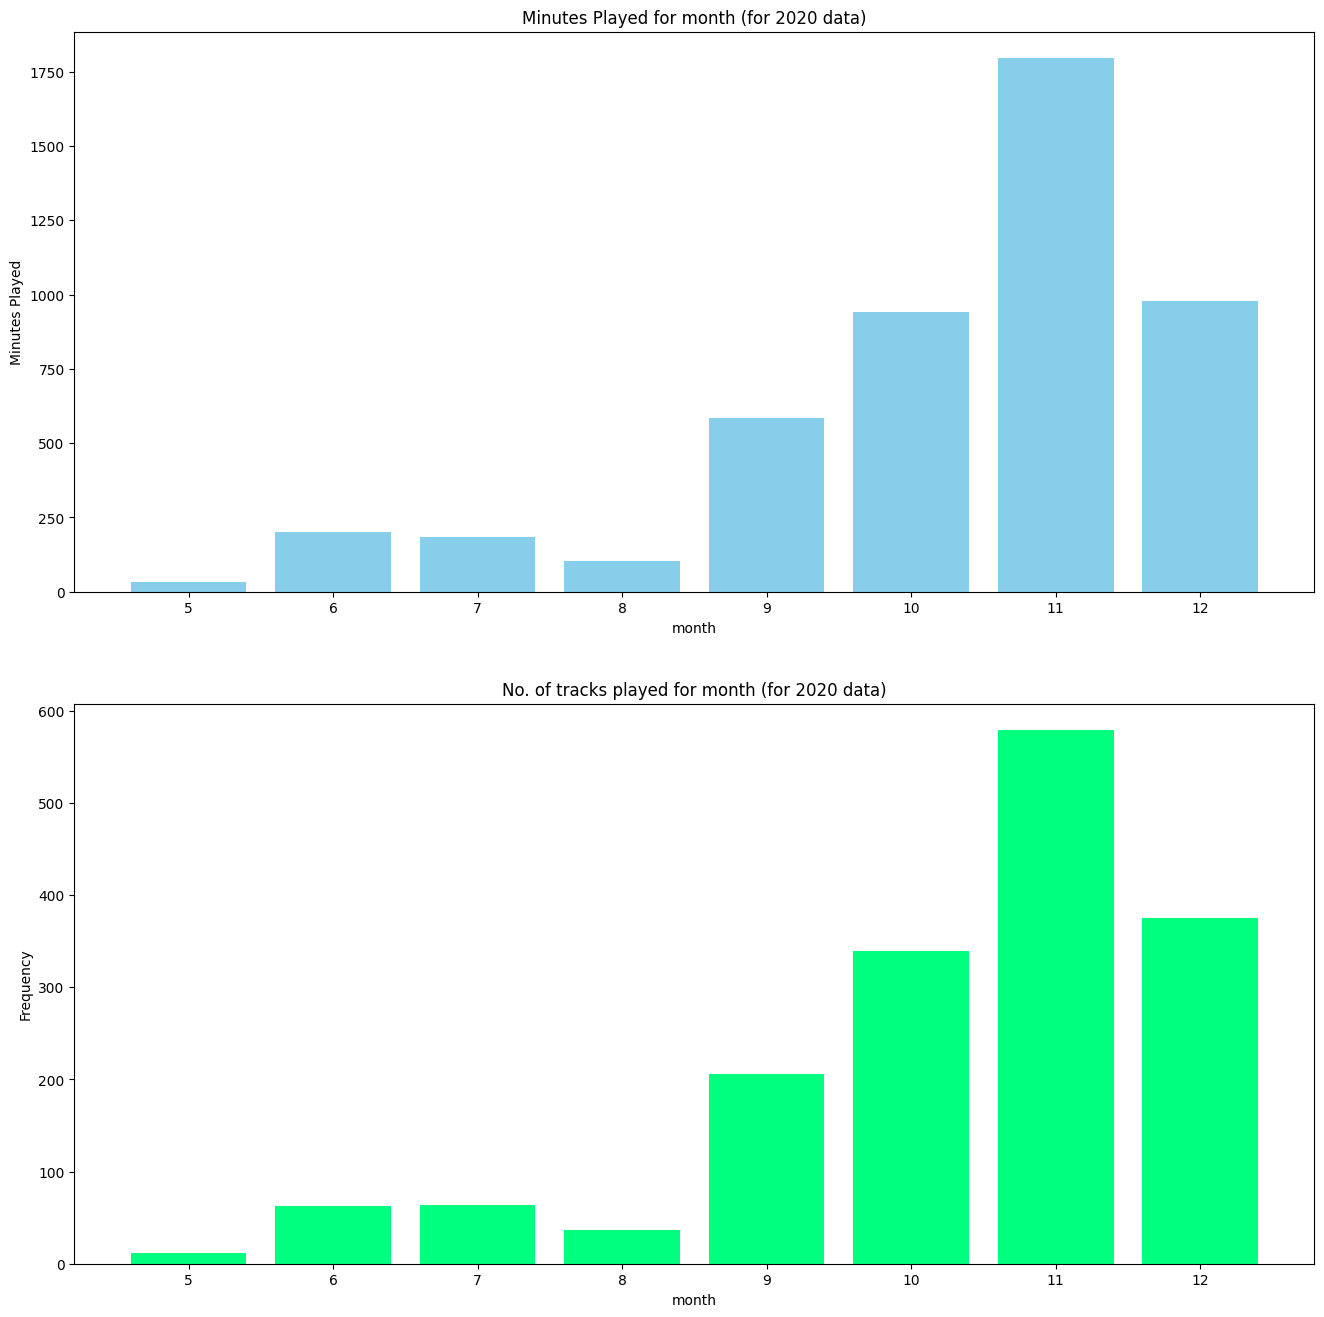

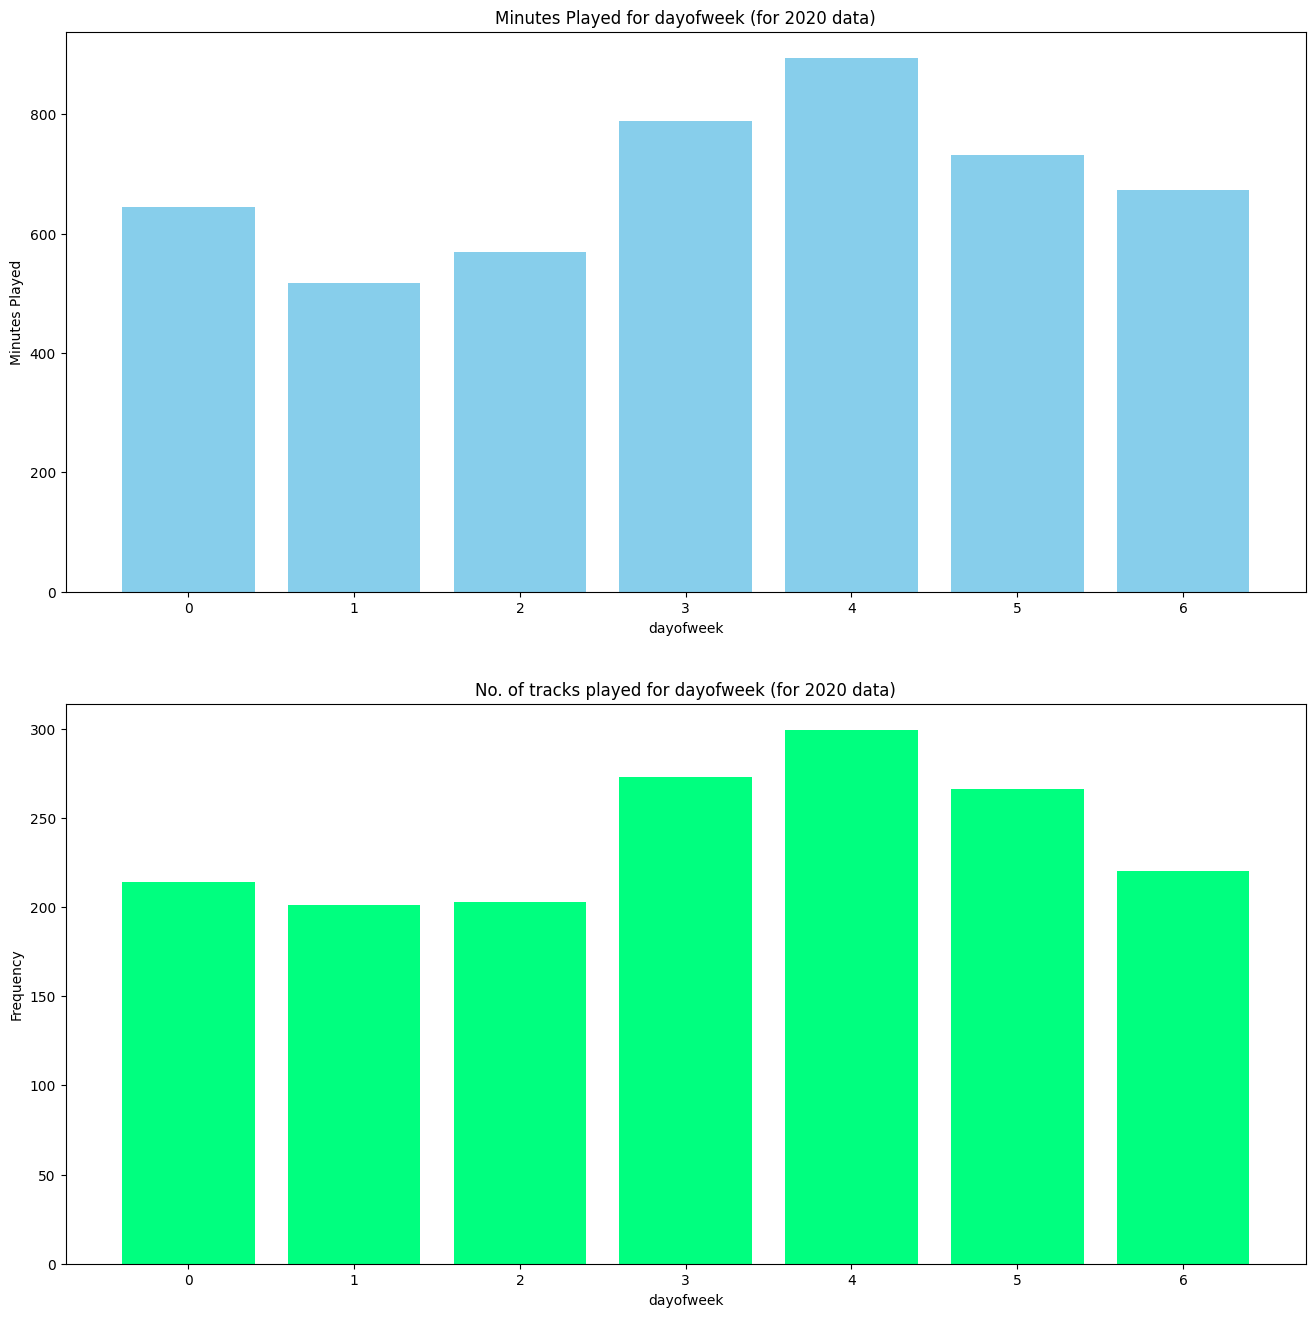

In [38]:
makeplot(year_dict, ["month", "dayofweek"])

In [39]:
artist_year_dict = {}
    
for key, val in year_dict.items():
    
    sorted_artist = sorted(list(set(val["master_metadata_album_artist_name"])))

    sorted_time = (val.groupby("master_metadata_album_artist_name")["ms_played"].sum())/(60*1000)
    sorted_time.reset_index(drop=True, inplace=True)

    sorted_freq = val["master_metadata_album_artist_name"].value_counts().reindex(sorted_artist)
    sorted_freq.reset_index(drop=True, inplace=True)

    artist_df = pd.DataFrame({"Artist Name": sorted_artist,
                             "Minutes Played": sorted_time,
                             "No. of Times Played": sorted_freq})
    
    artist_year_dict[f"Artists of {key}"] = artist_df

In [40]:
track_year_dict = {}

for key, val in year_dict.items():
    
    sorted_songs = sorted(list(set(val["song-artist"])))

    sorted_time = (val.groupby("song-artist")["ms_played"].sum())/(60*1000)
    sorted_time.reset_index(drop=True, inplace=True)

    sorted_freq = val["song-artist"].value_counts().reindex(sorted_songs)
    sorted_freq.reset_index(drop=True, inplace=True)

    track_df = pd.DataFrame({"Track Name": sorted_songs,
                             "Minutes Played": sorted_time,
                             "No. of Times Played": sorted_freq})
    track_year_dict[f"Tracks of {key}"] = track_df

**some explanation for the following plots (top 20 songs over the years):**<br>
* 2023:
    1. gayatri mantra: very long, obv
    2. somewhere near marseilles: pretty long, but still
    3. sad ending: truly no.1 and was, in wrapped
    4. others are mostly from the playlist for sleeping
    5. except for one last kiss and automatic
* 2022: a mix of comforting and not-so-comforting songs (no in between)
    1. shine your star: deserves a special mention
* 2021: more on the k-pop side, and runaway and stay with me
* 2020: this is filled with BTS, 
    * except Attention: started listening from may
    * this was mostly all what i listened those 3-4 months (good times)

C:\Users\91821\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\91821\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36794 (\N{CJK UNIFIED IDEOGRAPH-8FBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


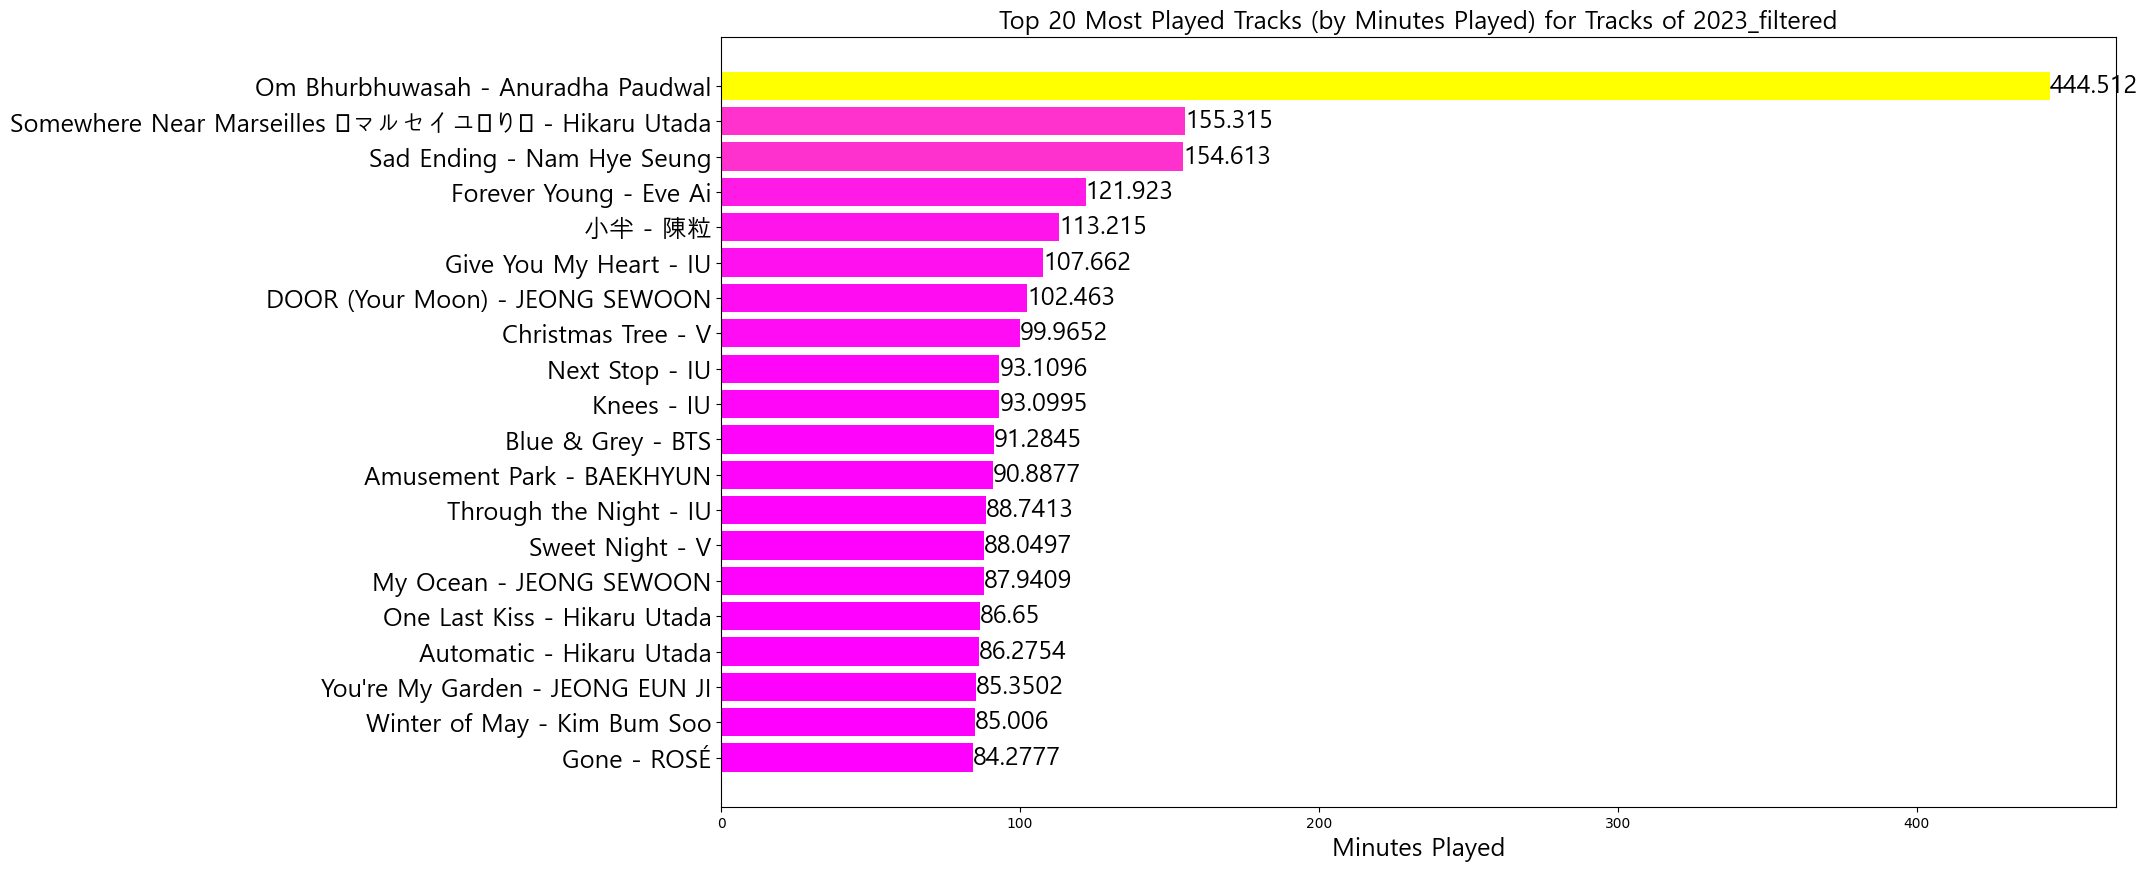

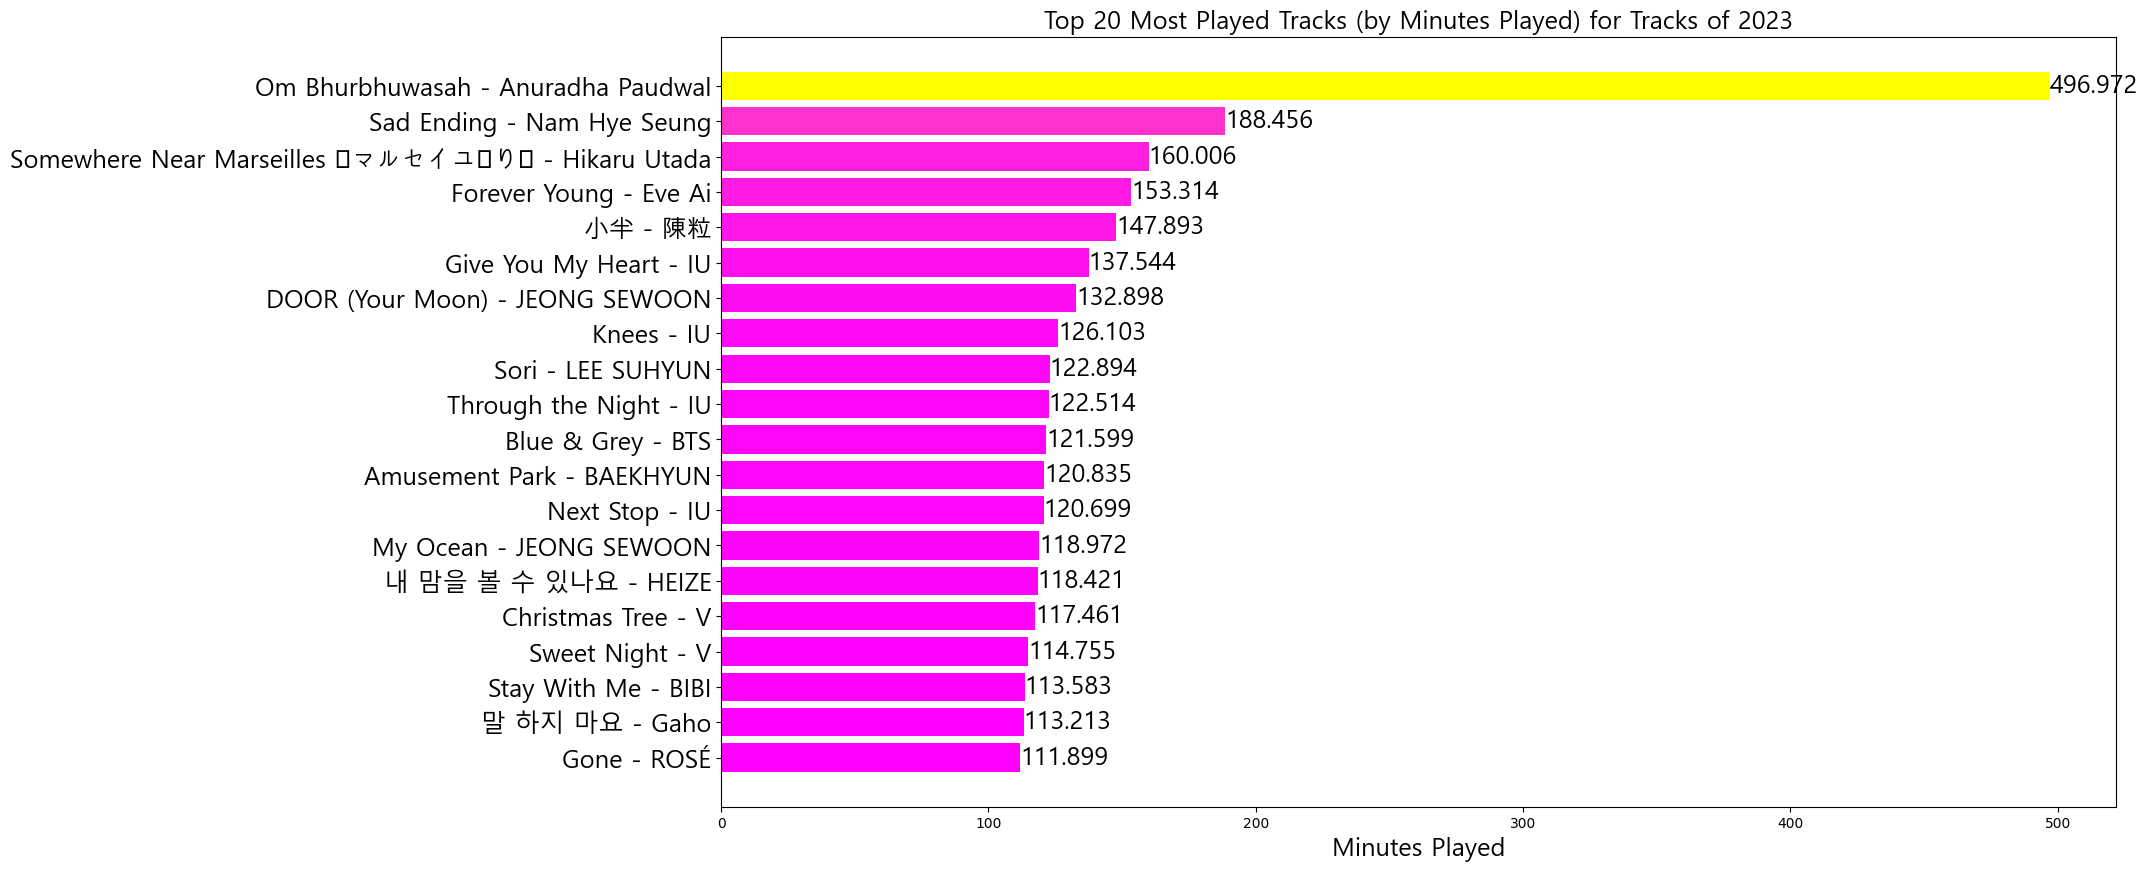

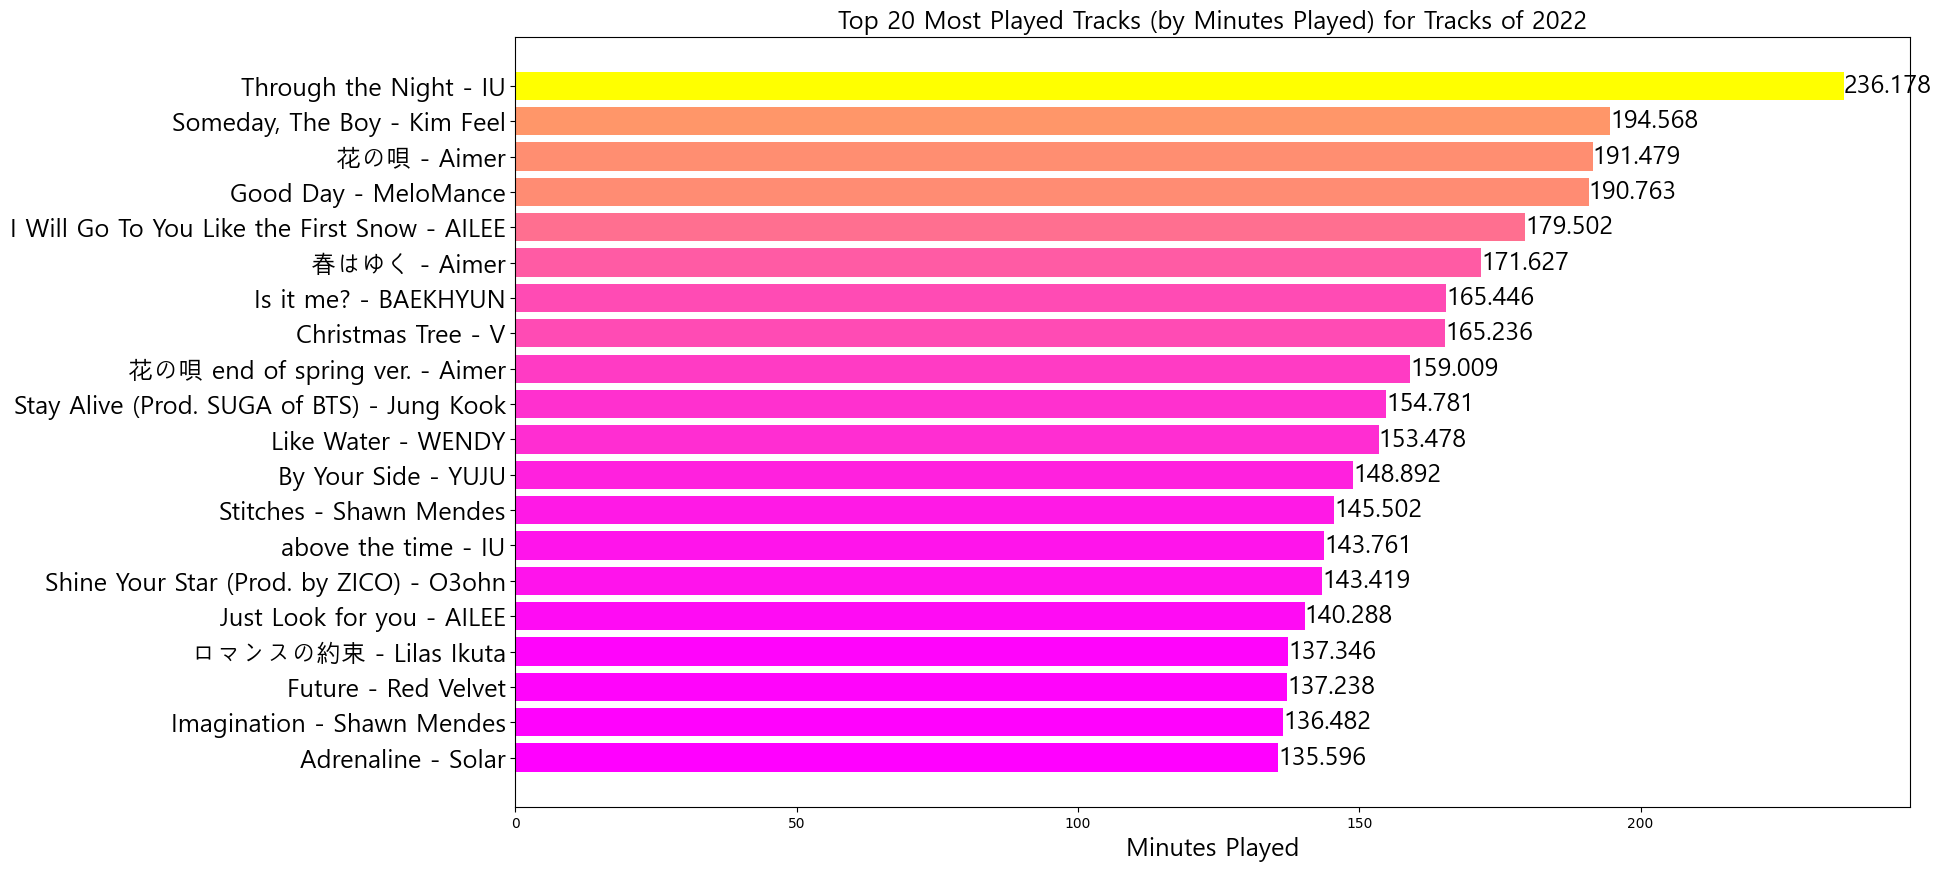

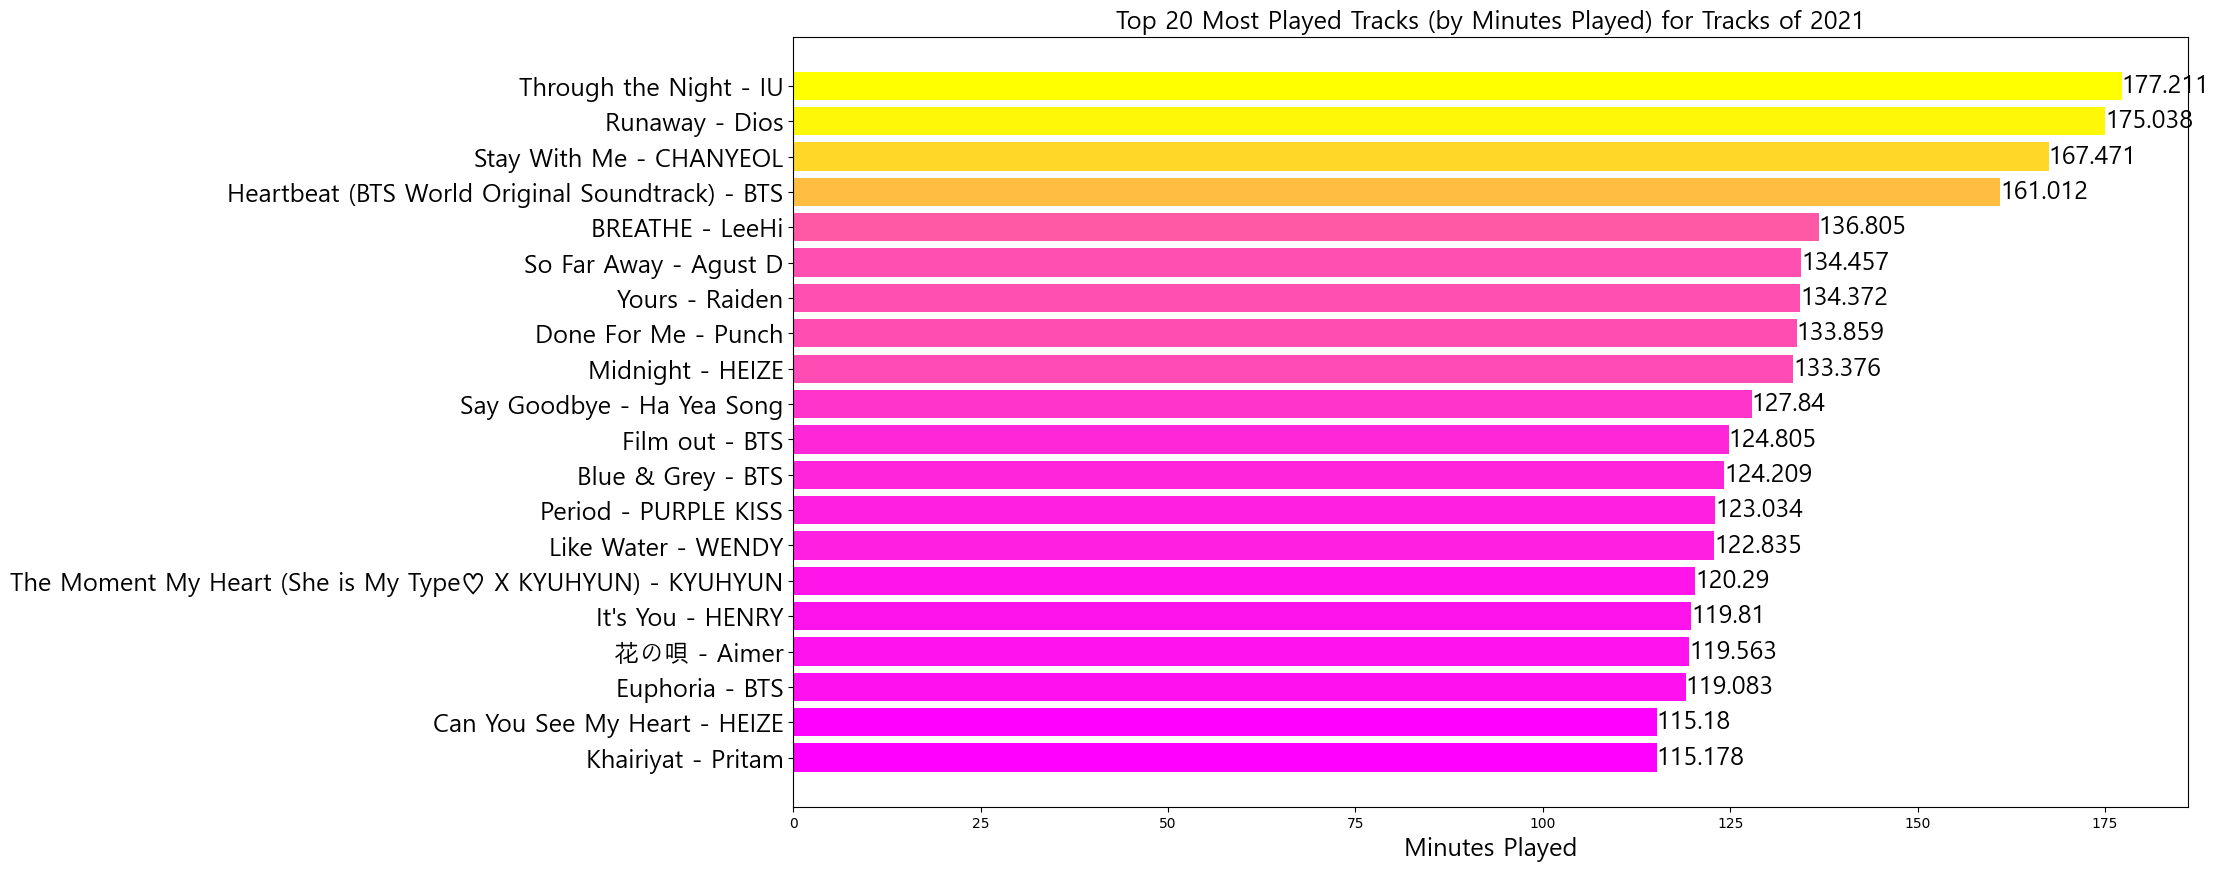

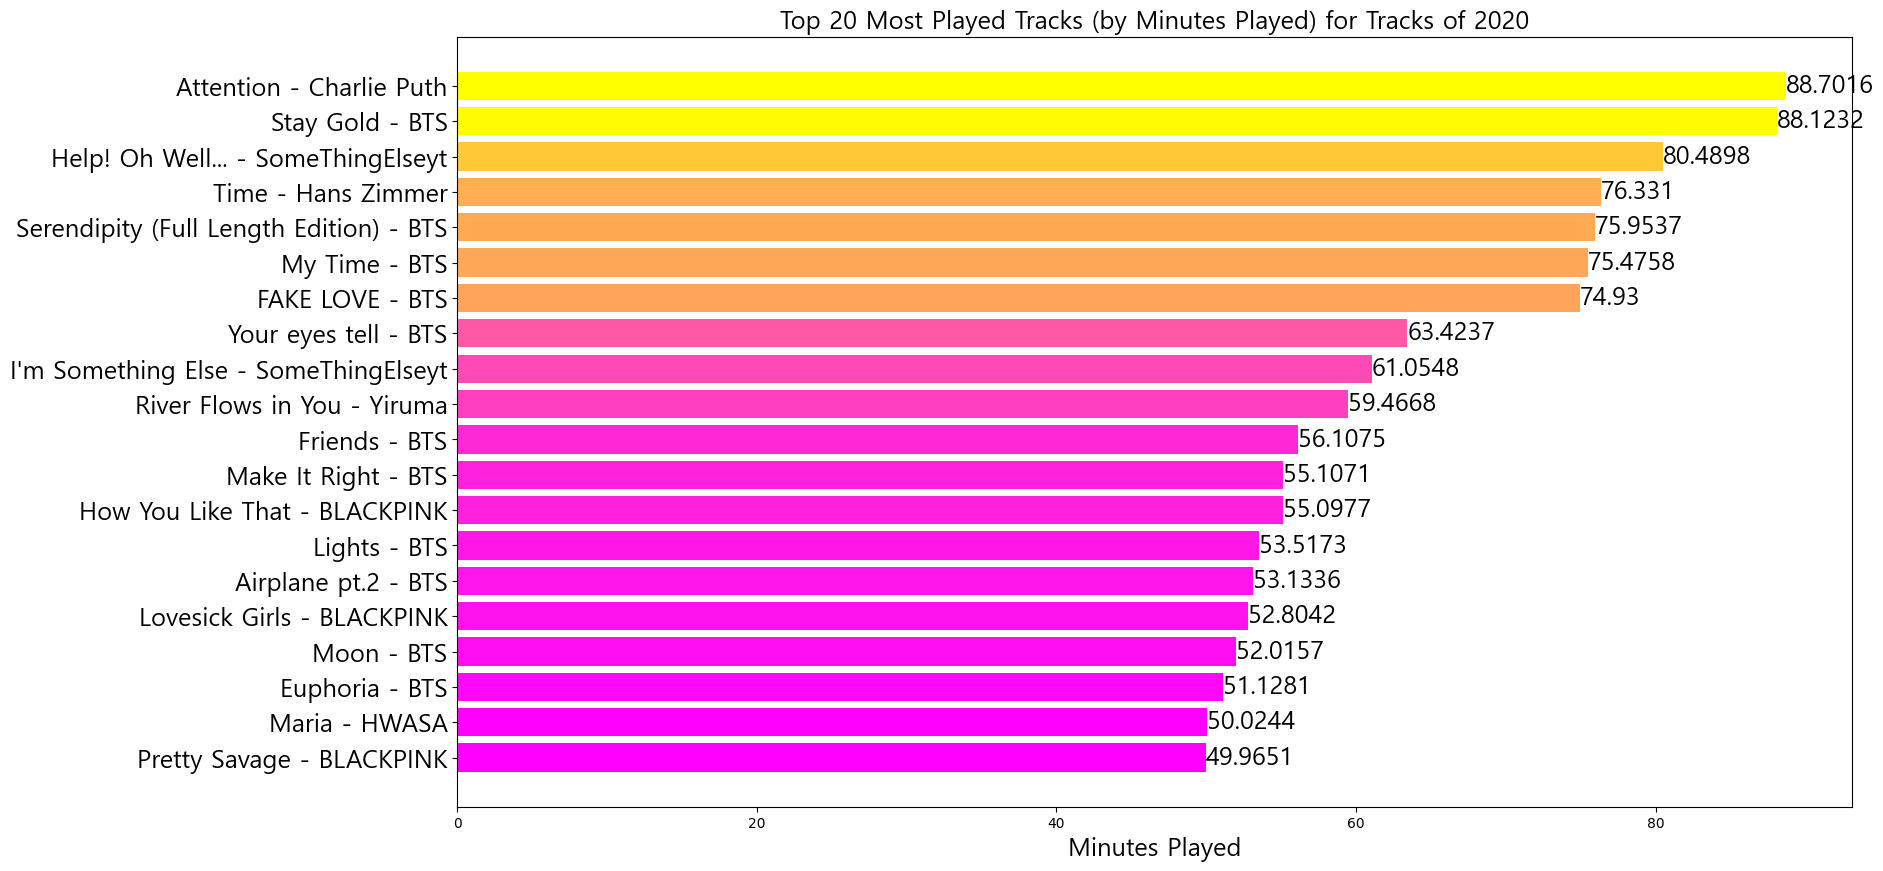

In [41]:
makeplot_20(track_year_dict, "Track", x='Minutes Played')

**some explanation for the following plots (top 20 artists over the years):**<br>
* 2023:
    1. IU: slow songs reigned, IU reigned
    2. BTS: i have no idea how, they are just embedded deep in my playlists
    3. notable entry: Ludwig Goransson (op, obv)
* 2022: 
    1. IU is taking over BTS here
    2. notable entry: Hiroyuki Sawano
* 2021: k-pop ruled, BTS ruled
* 2020: this is filled with BTS and almost exclusively

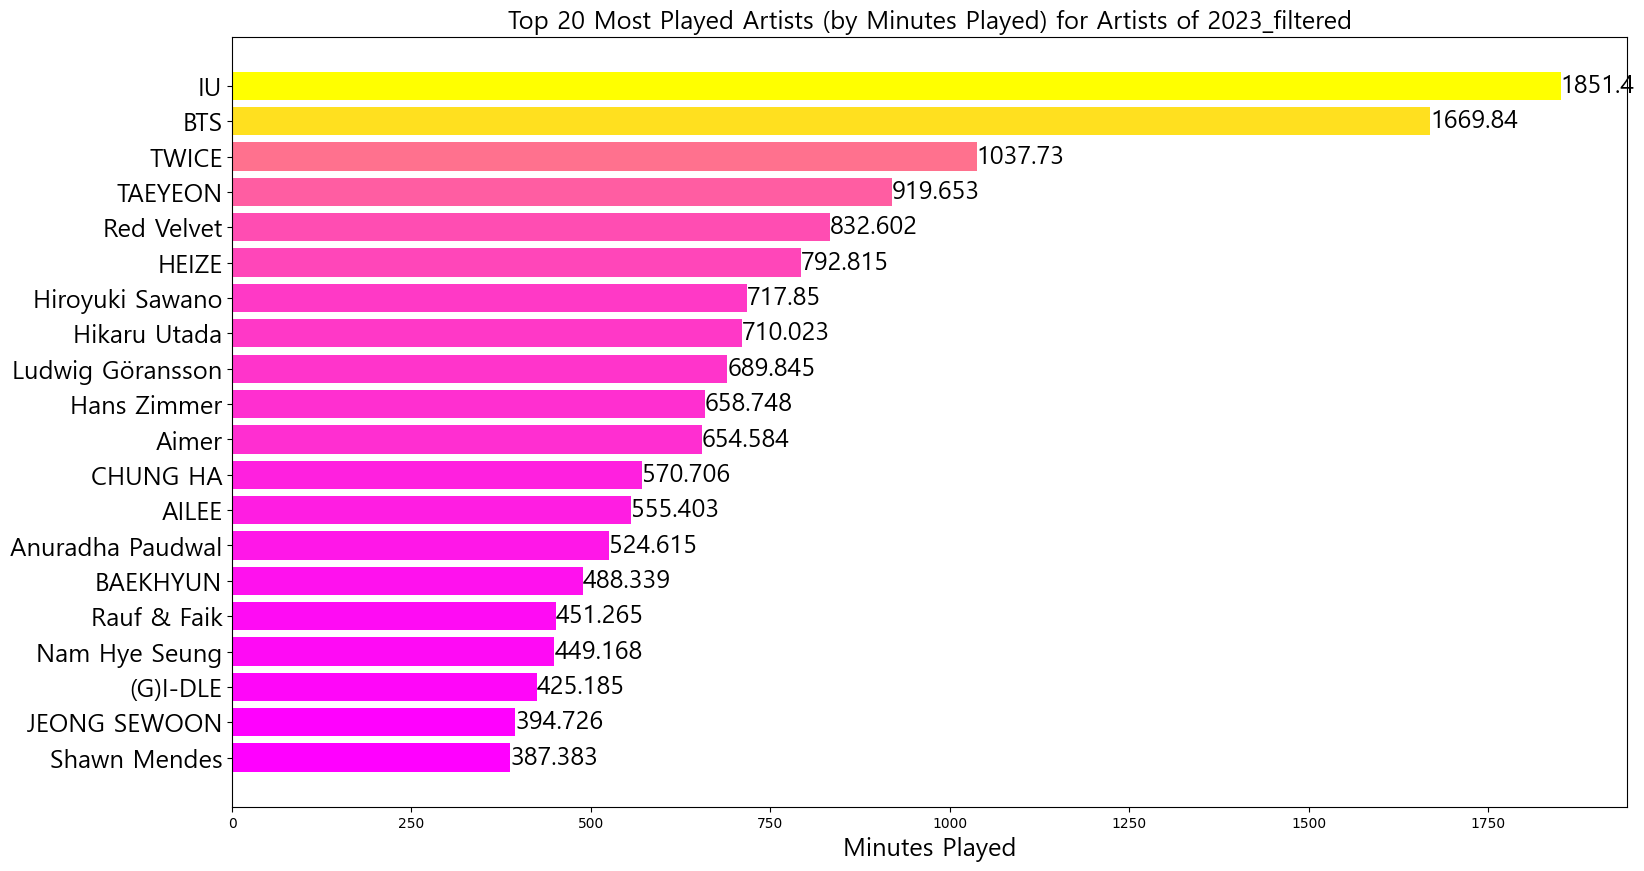

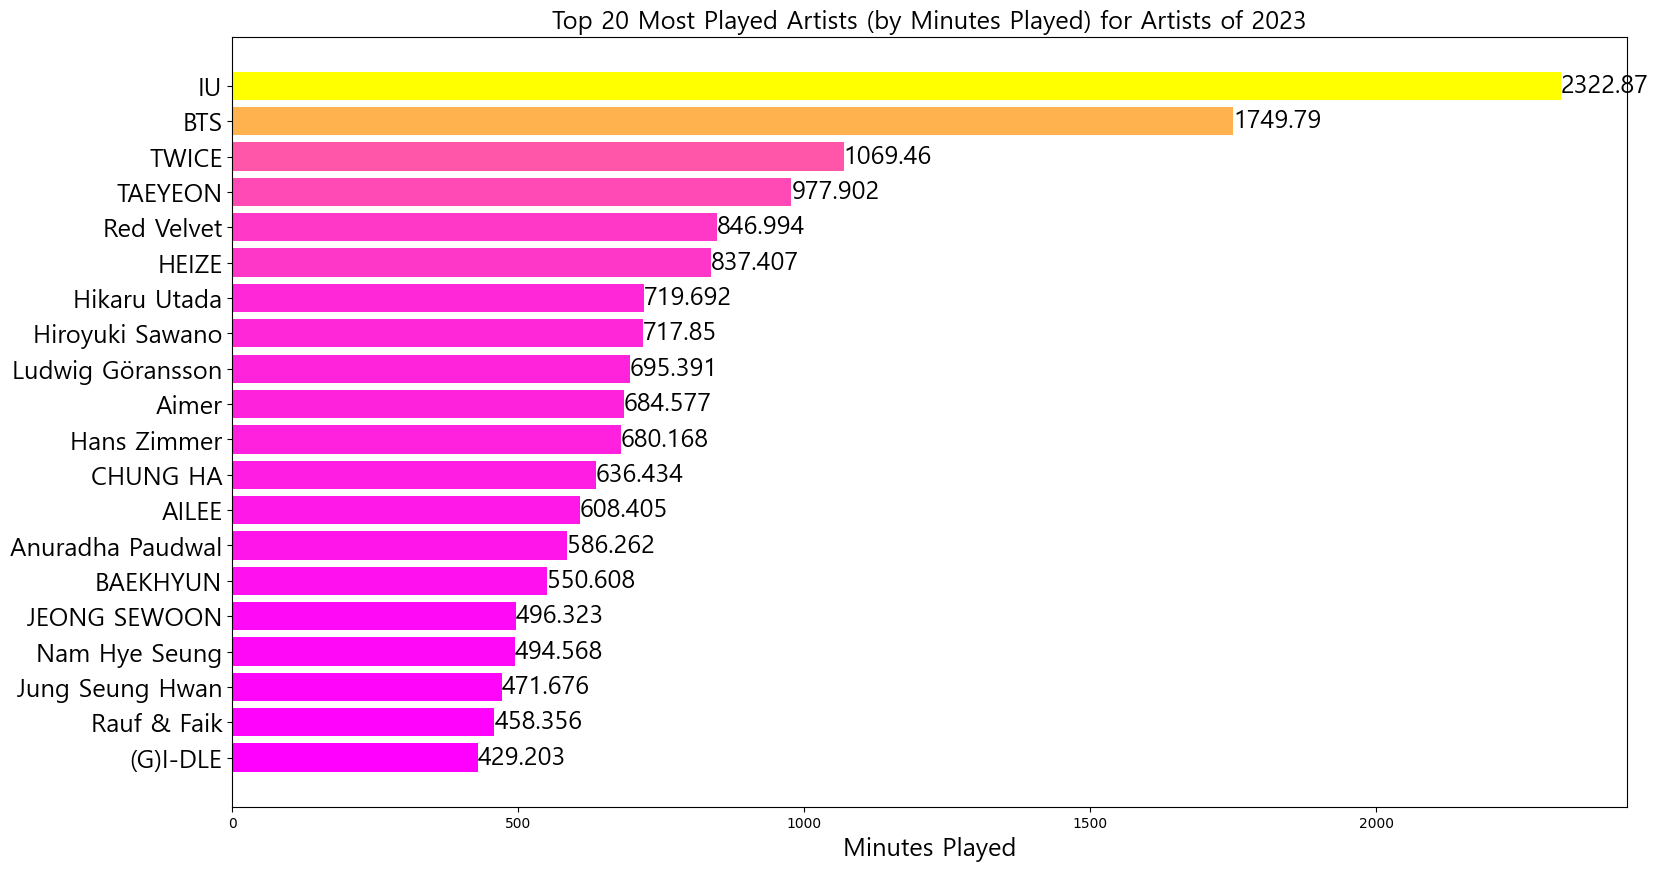

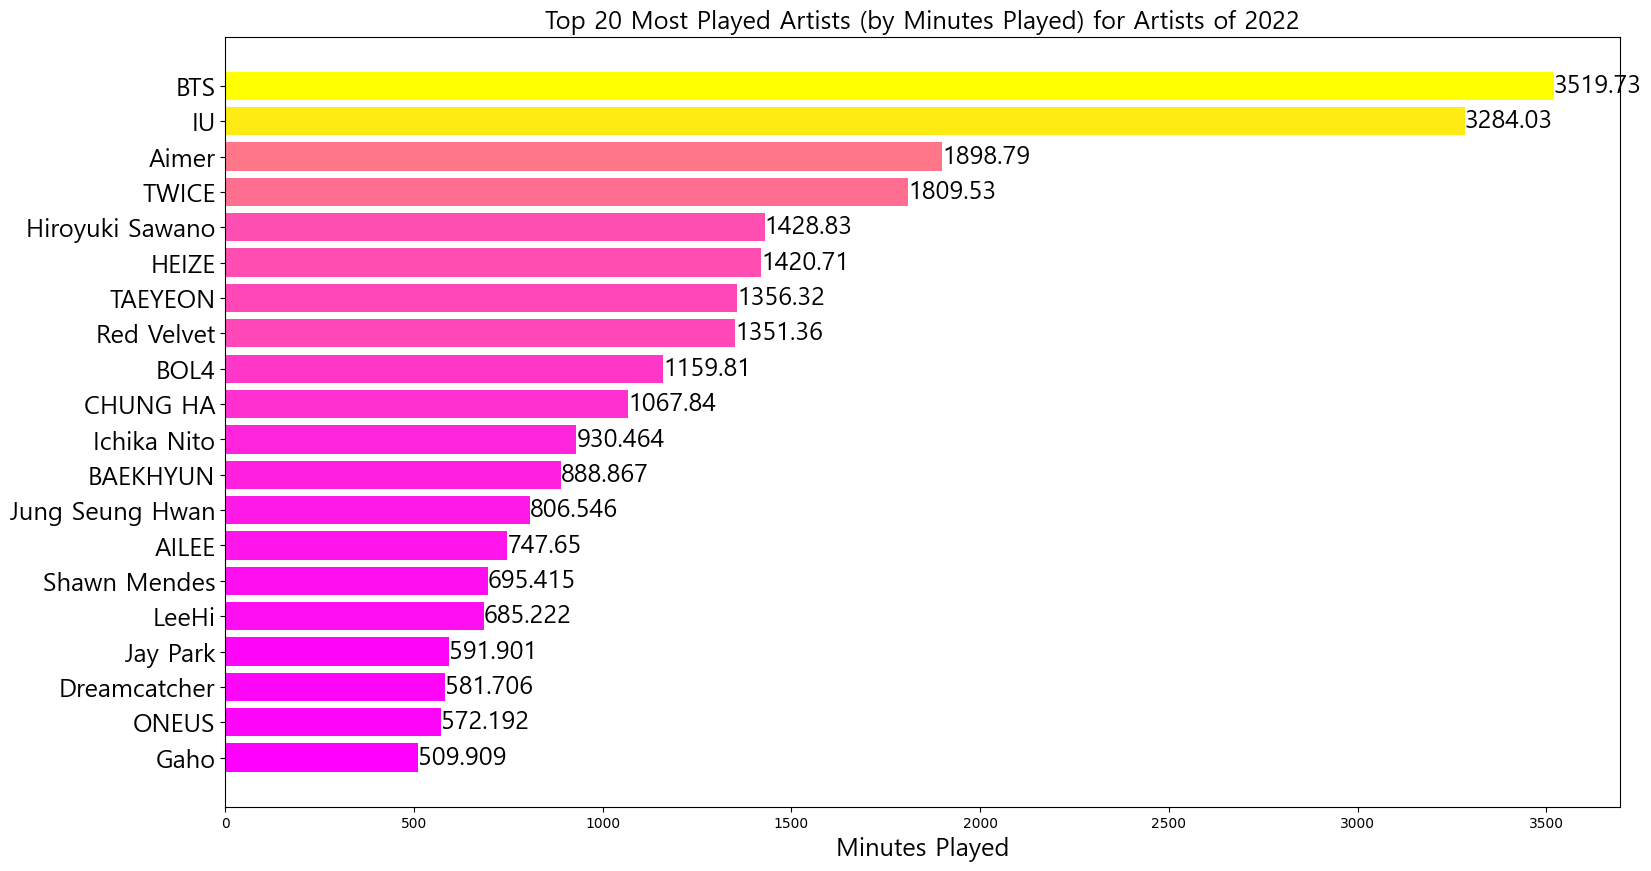

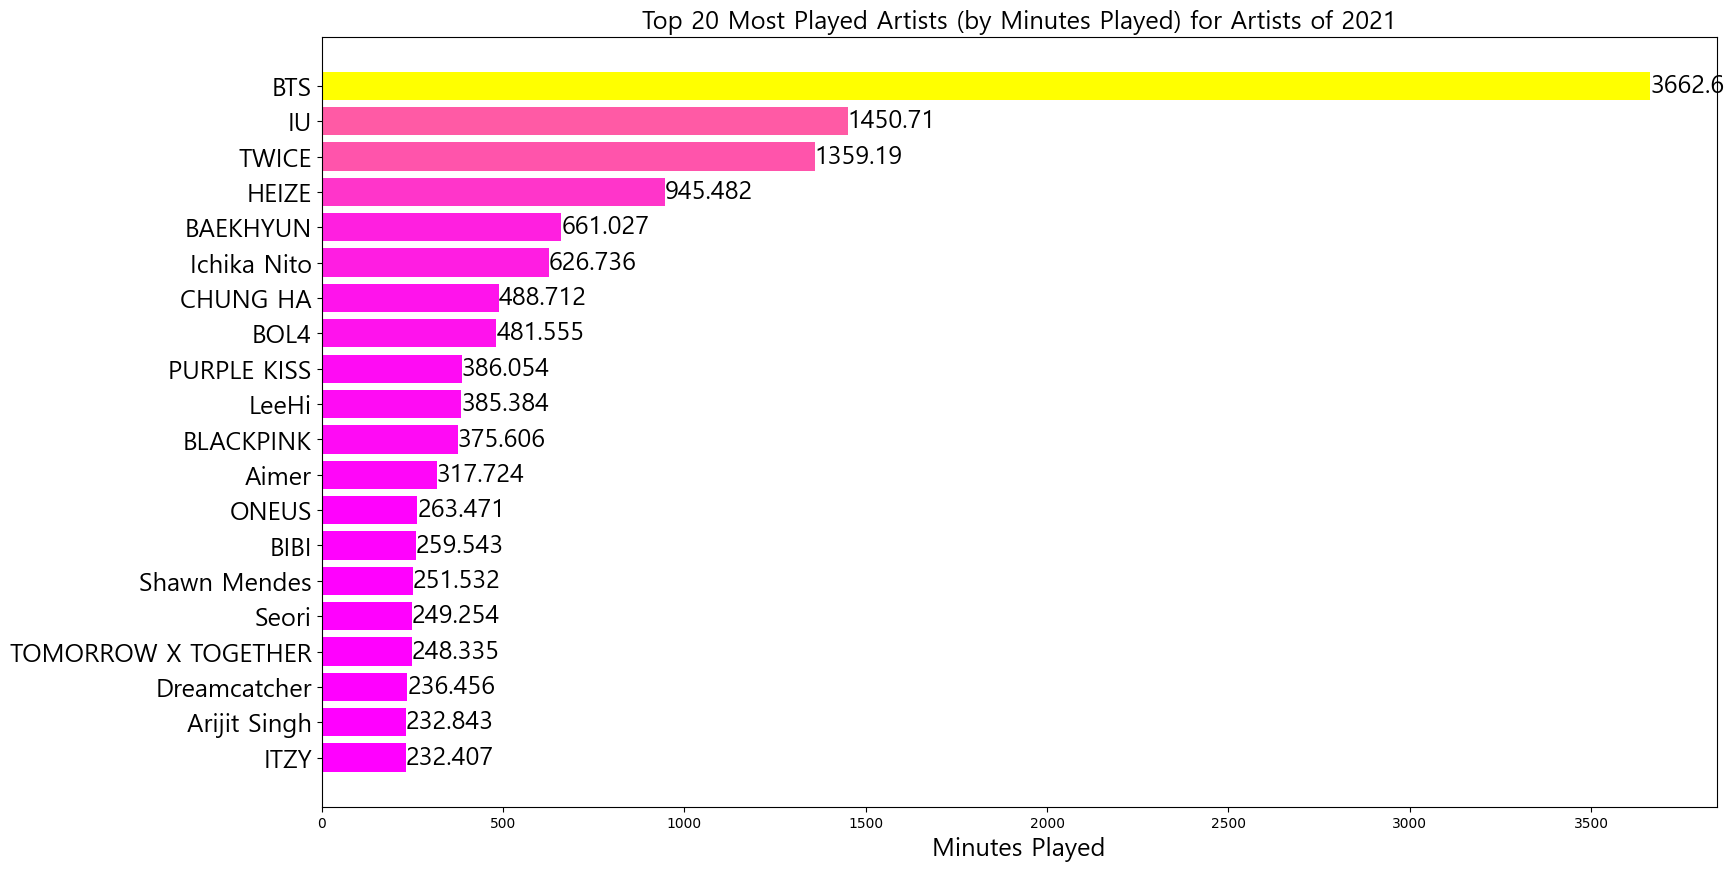

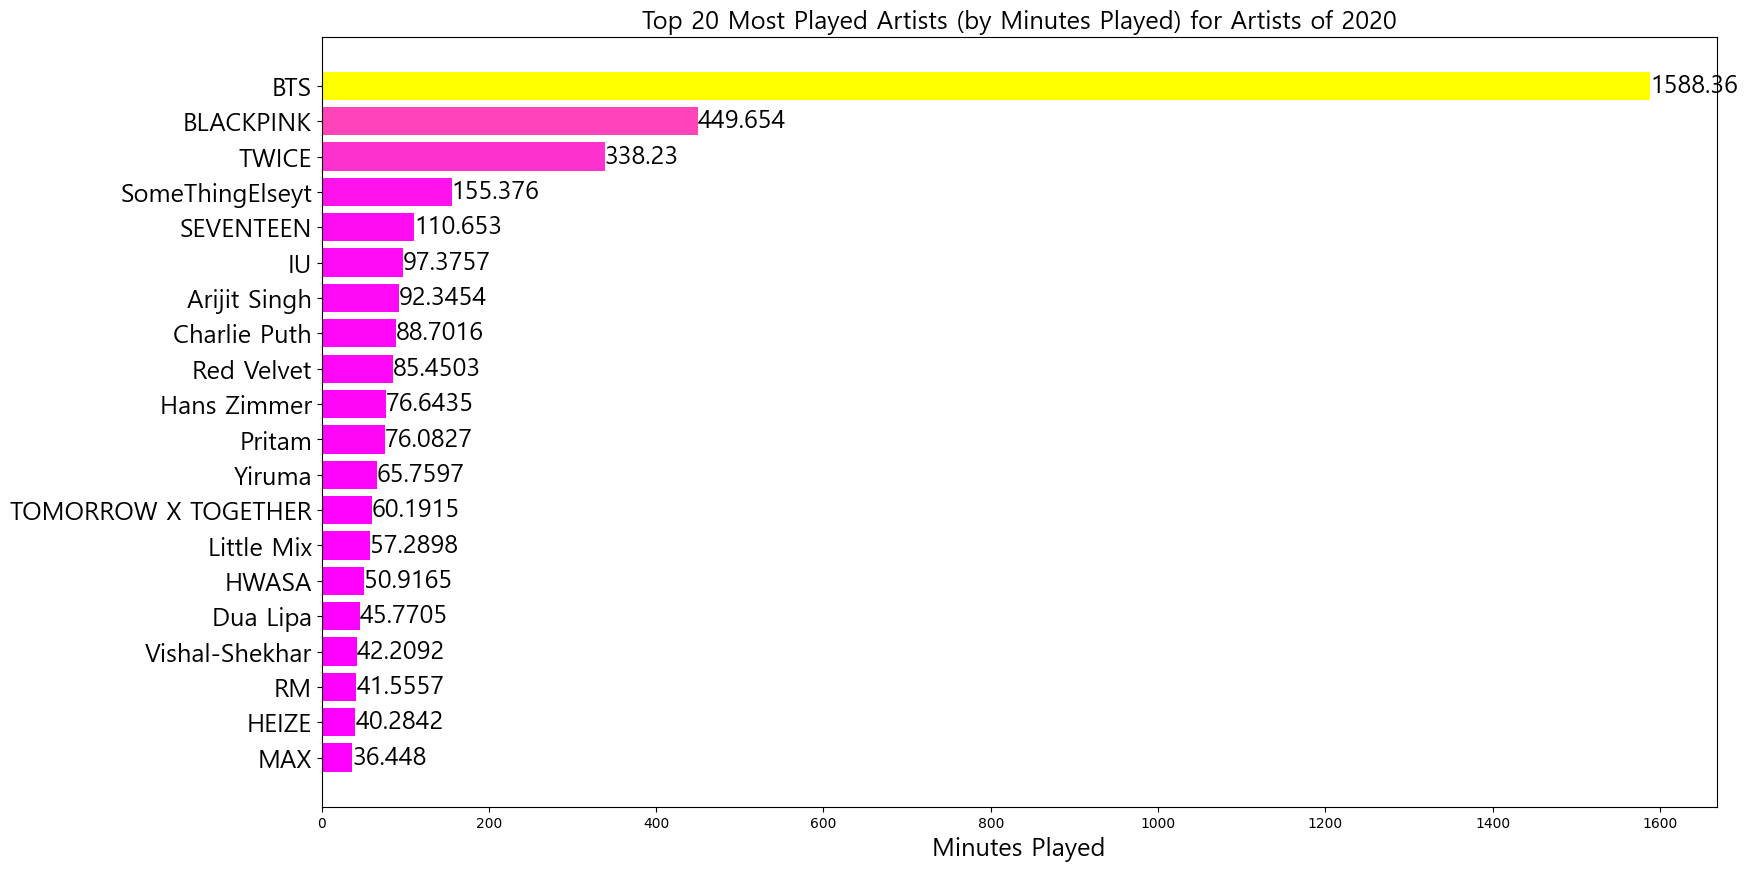

In [42]:
makeplot_20(artist_year_dict, "Artist", 'Minutes Played')

### About Playlists
I made a separate notebook for playlist EDA.

# Part B: Song Analysis

In [43]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [44]:
cid = 'client_id'
secret = 'client_secret'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

example for search: `sp.search(q="track:Galaxy, artist:BOL4", type="track")` (this was the first request)

https://medium.com/@maxtingle/getting-started-with-spotifys-api-spotipy-197c3dc6353b
https://developer.spotify.com/documentation/web-api/reference/get-audio-features

Following some cells will be converted to raw; they are not needed now, i have put the retreived features in `Track-Data-with-Features.csv`.<br><br>
This image is the screenshot of the cell ran to get the audio features for all the songs. The image also tells that this was a long process and one would not want to do that again.
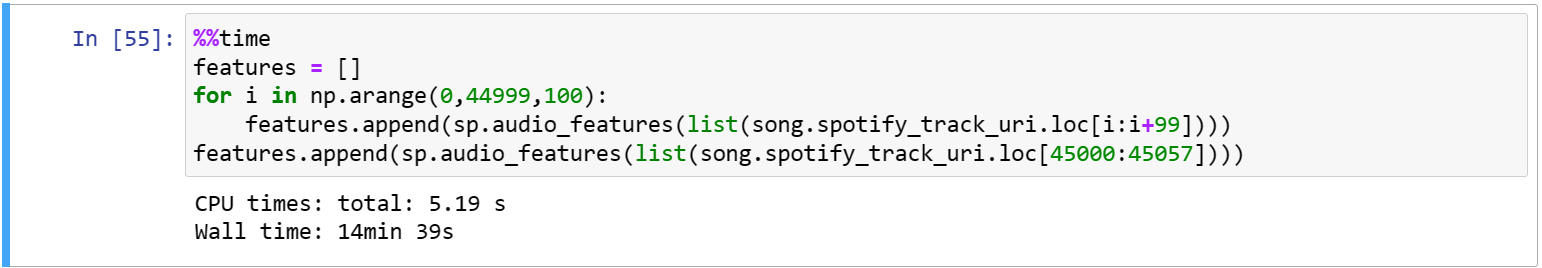

some were left (or not retrieved wholly/properly), so this cell:

`features1` was made to keep features as it is

making a dataframe (empty for now) for the features retrieved

`longlist` was made because features1 contained 449~451 lists of 100 dictionaries each. `longlist` merges all the the lists together to make a full list of 45057 dictionaries.

To check if `longlist` has any `None` values which must be removed

Output: `List contains None values`<br>
Now to get the particular tracks/indices which are `None`:

Output: `[44335, 44522]`<br>
Checking in the song df, we get to know that `Kat - Volker Bertelmann` was the track, which had None values.<br>
Confirming with the API again (if there was any probelm with teh retreival)

Output: [None]<br>
I'll just drop this then

Finally concatenating and saving as csv

**Finally, this is where we continue:**

In [45]:
features = pd.read_csv("Track-Data-with-Features.csv", low_memory=False)

get daily data for average song features<br> will be doing it for 2022 only

In [46]:
y22 = features.loc[features.year == 2022]
y22.reset_index(drop=True, inplace=True)

### Making daily df:
> all these are put in lists first because index starts from 0 and day starts from 1

In [47]:
# making empty df first
daily = pd.DataFrame(columns=["datetime", "day", "month", "dayofyear", "number_of_tracks", "ms_played",
                              "min_played", "danceability",
                              "energy", "key", "loudness", "mode", "speechiness", "acousticness",
                              "instrumentalness", "liveness", "valence", "tempo"])

# making a groupby object and assigning it to variable for ease
pp = y22.groupby(by=y22.dayofyear)


# dayofyear: put as it is
daily.dayofyear = list(pp.dayofyear.groups.keys())

# datetime:  for ease in plotting
daily.datetime = pd.to_datetime(daily.dayofyear, unit="D", origin=pd.Timestamp(year=2022, month=1, day=1)) - pd.DateOffset(days=1)

# day and month: require a list, need to extract day and month from the indices in groupby
daylist = []
monthlist = []

for d in pp.dayofyear.groups.keys():
    daylist.append(y22.day[pp.day.groups[d][0]])
    monthlist.append(y22.month[pp.month.groups[d][0]])
daily.month = monthlist
daily.day = daylist

# ms_played: summed for a day
daily.ms_played = list(pp.ms_played.sum())
daily.min_played = daily.ms_played/60000

# count: frequency
freq = []
for i in pp.day.groups.keys():
    freq.append(len(pp.day.groups[i]))
daily.number_of_tracks = freq

# all the rest: simple average
for fe in ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
           "instrumentalness", "liveness", "valence", "tempo"]:
    daily[fe] = list(pp[fe].mean())
    
daily

datetime  day  month  dayofyear  number_of_tracks  ms_played  \
0   2022-01-01    1      1          1                33    4947360   
1   2022-01-02    2      1          2                21    4137019   
2   2022-01-03    3      1          3                64   13520648   
3   2022-01-04    4      1          4                37    6702977   
4   2022-01-05    5      1          5                34    6001942   
..         ...  ...    ...        ...               ...        ...   
349 2022-12-27   27     12        361                97   18735583   
350 2022-12-28   28     12        362                89   16845035   
351 2022-12-29   29     12        363                33    6022433   
352 2022-12-30   30     12        364               100   19102868   
353 2022-12-31   31     12        365                 5     674950   

     min_played  danceability    energy       key  loudness      mode  \
0     82.456000      0.591818  0.475815  5.303030 -9.612455  0.484848   
1     68.950317      0.524571  0.466143  4.809524 -6.694238  0.761905   
2    225.344133      0.519859  0.448975  4.953125 -7.311219  0.765625   
3    111.716283      0.546351  0.506924  5.621622 -6.464405  0.594595   
4    100.032367      0.681676  0.693735  5.176471 -4.453059  0.411765   
..          ...           ...       ...       ...       ...       ...   
349  312.259717      0.618134  0.599387  4.948454 -6.227804  0.515464   
350  280.750583      0.559771  0.627349  4.797753 -7.526169  0.561798   
351  100.373883      0.496455  0.470039  5.848485 -7.883727  0.484848   
352  318.381133      0.629200  0.605480  5.280000 -5.903860  0.590000   
353   11.249167      0.733400  0.766600  5.800000 -3.374400  0.400000   

     speechiness  acousticness  instrumentalness  liveness   valence  \
0       0.056800      0.612754          0.471995  0.147385  0.376973   
1       0.041571      0.554019          0.001070  0.149667  0.300952   
2       0.047747      0.621498          0.109286  0.142131  0.332645   
3       0.049924      0.551565          0.002548  0.138432  0.351108   
4       0.075635      0.225964          0.000166  0.166909  0.548412   
..           ...           ...               ...       ...       ...   
349     0.068433      0.385380          0.084292  0.158742  0.458666   
350     0.068839      0.282143          0.261588  0.181155  0.412101   
351     0.039391      0.590302          0.192045  0.134109  0.287161   
352     0.058558      0.365763          0.024817  0.165759  0.473729   
353     0.059400      0.315480          0.000086  0.103320  0.596600   

          tempo  
0    113.540515  
1    124.421810  
2    117.574281  
3    121.241514  
4    125.737265  
..          ...  
349  111.141938  
350  119.960382  
351  116.011182  
352  113.840470  
353  117.458800  

[354 rows x 18 columns]

In [48]:
daily.describe()

datetime         day       month   dayofyear  \
count                            354  354.000000  354.000000  354.000000   
mean   2022-06-29 09:41:41.694915328   15.810734    6.437853  180.403955   
min              2022-01-01 00:00:00    1.000000    1.000000    1.000000   
25%              2022-03-30 06:00:00    8.000000    3.000000   89.250000   
50%              2022-06-27 12:00:00   16.000000    6.000000  178.500000   
75%              2022-09-26 18:00:00   23.000000    9.000000  269.750000   
max              2022-12-31 00:00:00   31.000000   12.000000  365.000000   
std                              NaN    8.805792    3.455559  105.702898   

       number_of_tracks     ms_played  min_played  danceability      energy  \
count        354.000000  3.540000e+02  354.000000    354.000000  354.000000   
mean          52.426554  1.031274e+07  171.879040      0.580328    0.572266   
min            1.000000  1.834600e+04    0.305767      0.311190    0.270090   
25%           27.000000  5.292572e+06   88.209525      0.529249    0.494082   
50%           50.500000  9.924940e+06  165.415667      0.581059    0.579580   
75%           74.750000  1.455697e+07  242.616217      0.632793    0.644355   
max          171.000000  2.903549e+07  483.924767      0.878000    0.826895   
std           32.661479  6.439717e+06  107.328612      0.073040    0.101312   

              key    loudness        mode  speechiness  acousticness  \
count  354.000000  354.000000  354.000000   354.000000    354.000000   
mean     5.276155   -6.447053    0.587115     0.061814      0.428517   
min      0.000000  -16.939755    0.000000     0.028500      0.043700   
25%      4.859482   -7.158652    0.485258     0.047999      0.314374   
50%      5.273118   -6.218921    0.581232     0.060560      0.429939   
75%      5.639091   -5.407838    0.682790     0.073202      0.540893   
max     11.000000   -3.145000    1.000000     0.163000      0.853000   
std      1.005360    1.653308    0.166813     0.018007      0.151689   

       instrumentalness    liveness     valence       tempo  
count        354.000000  354.000000  354.000000  354.000000  
mean           0.076767    0.155963    0.424468  117.695278  
min            0.000000    0.057900    0.123510   64.216000  
25%            0.003367    0.141305    0.342783  114.171069  
50%            0.033794    0.154221    0.420702  117.957950  
75%            0.091247    0.167019    0.507828  121.336489  
max            0.674769    0.401000    0.878000  146.170667  
std            0.114498    0.029574    0.108875    7.972262

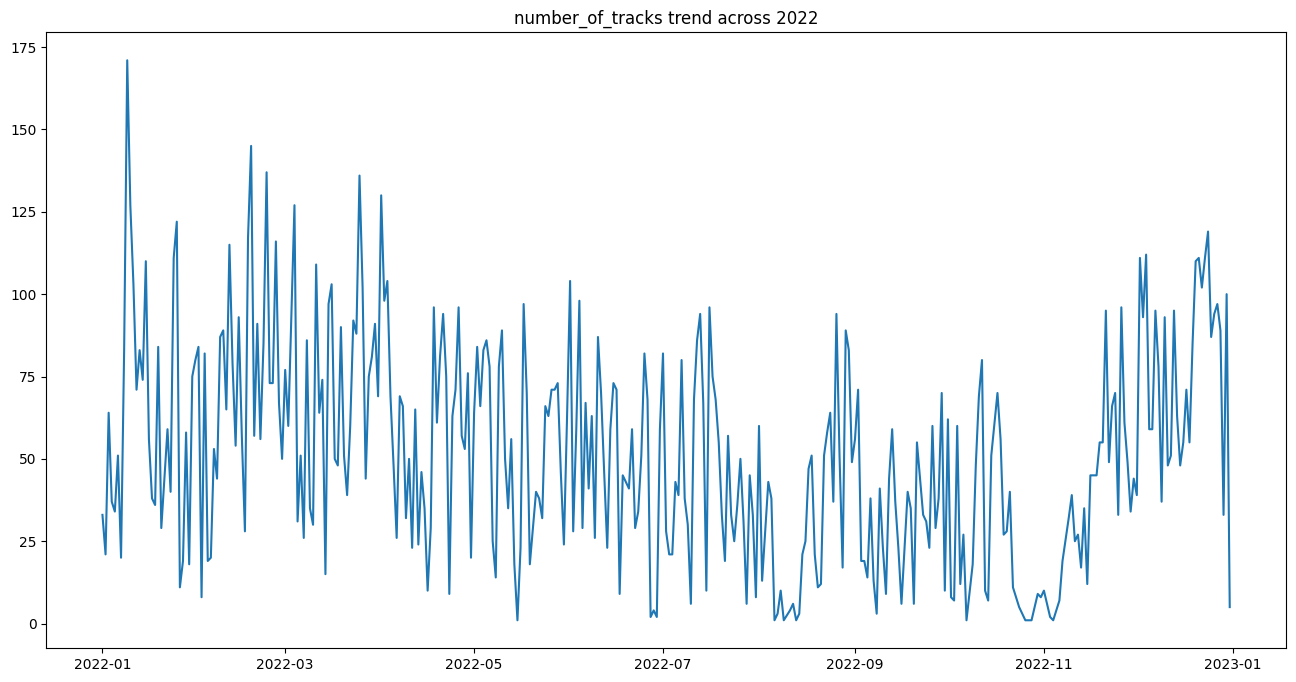

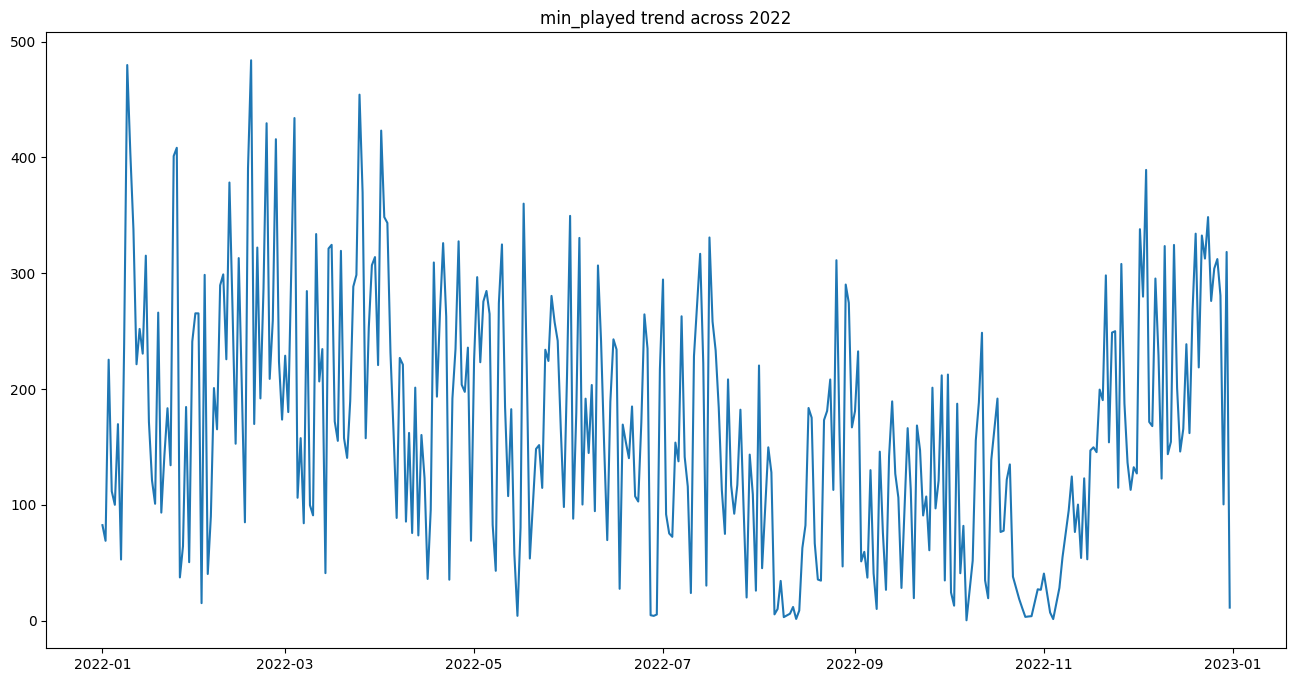

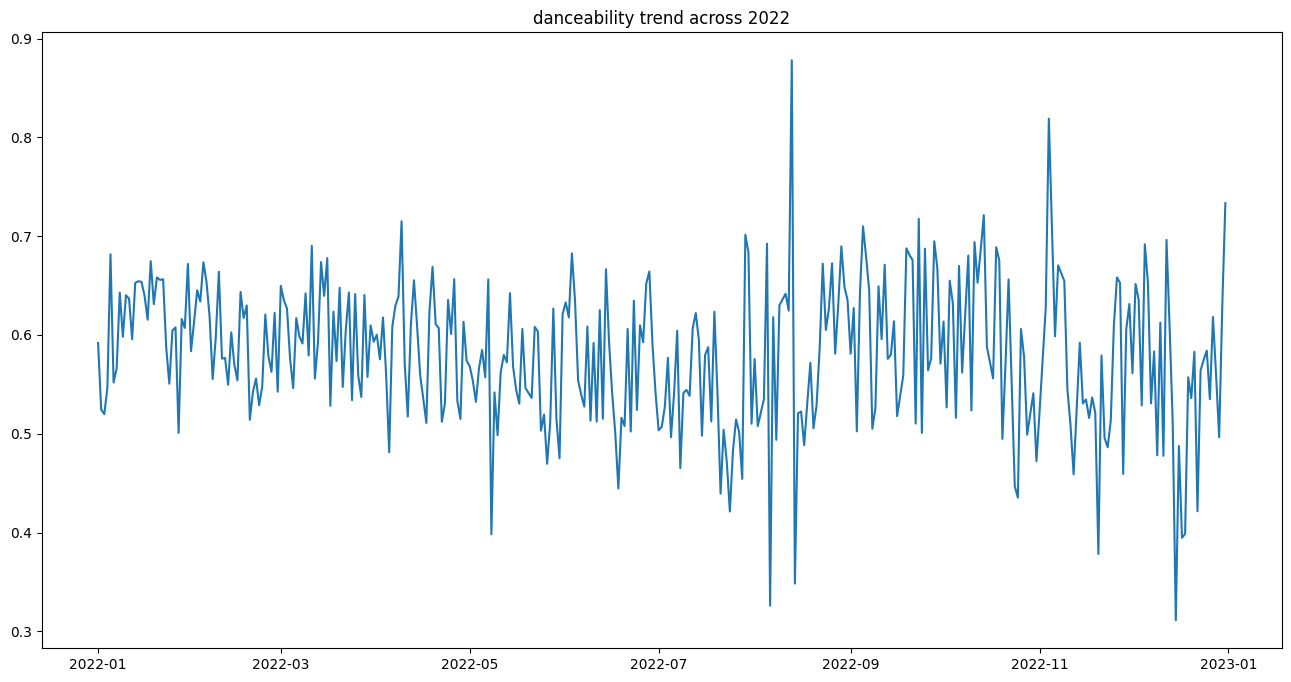

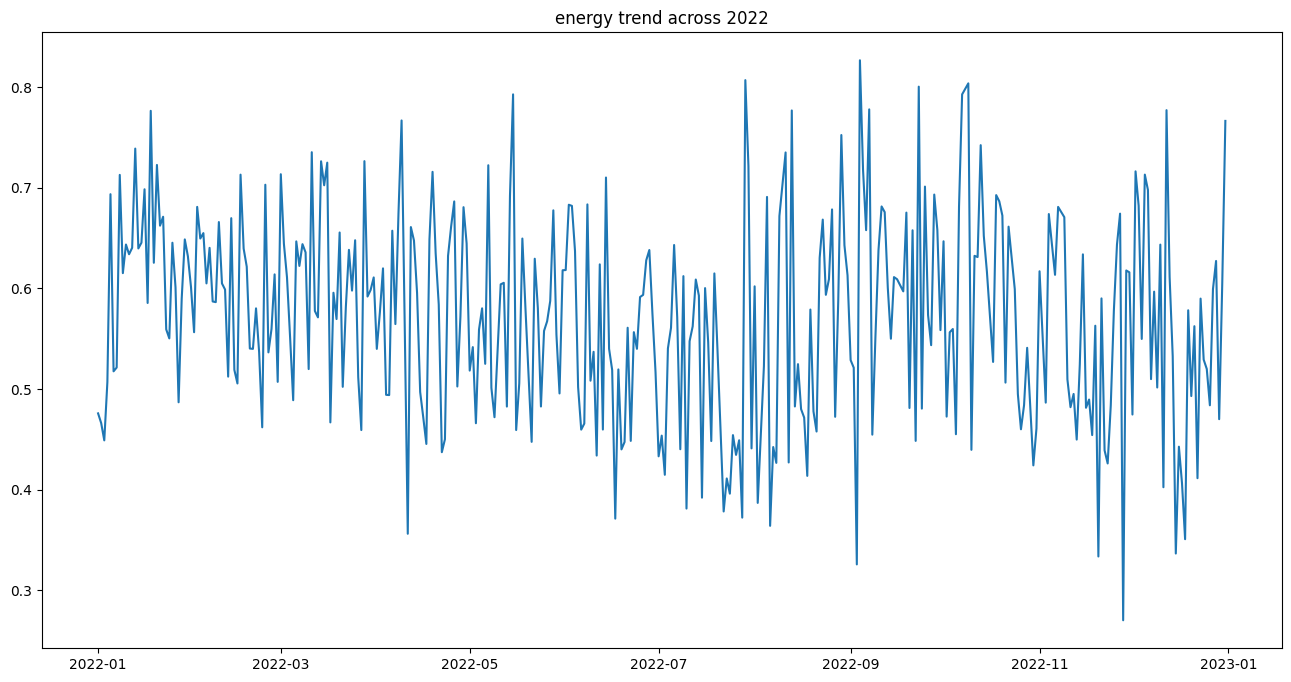

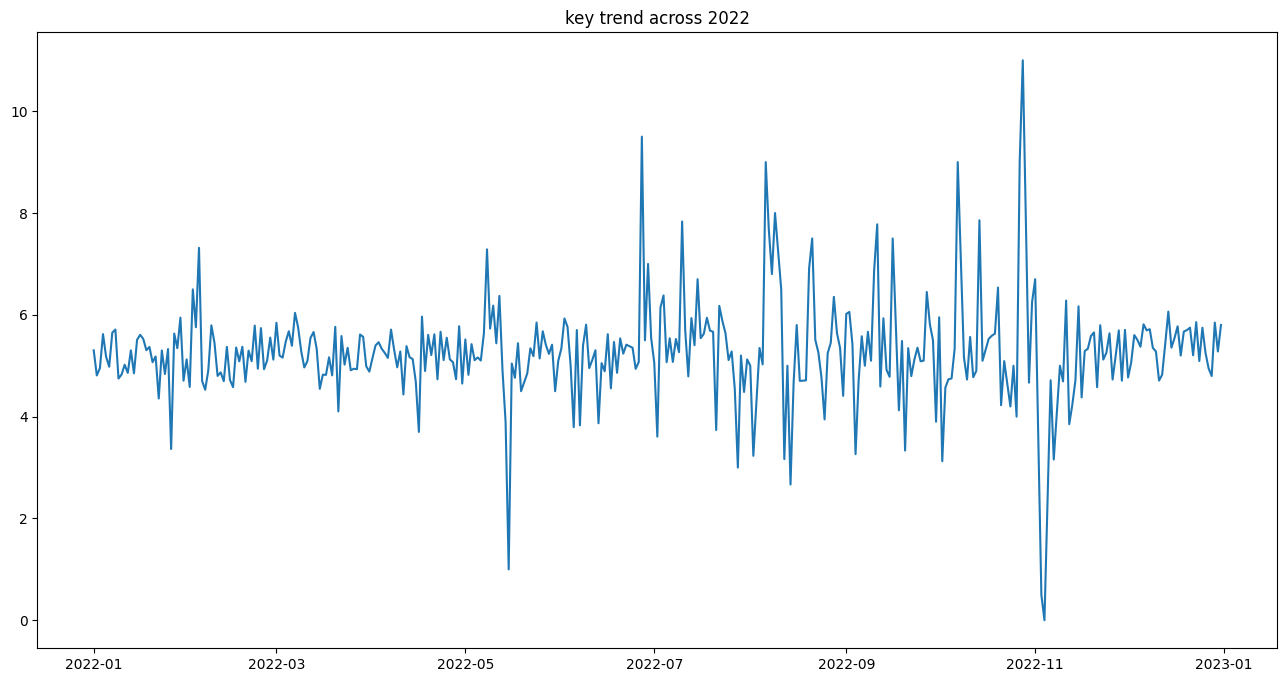

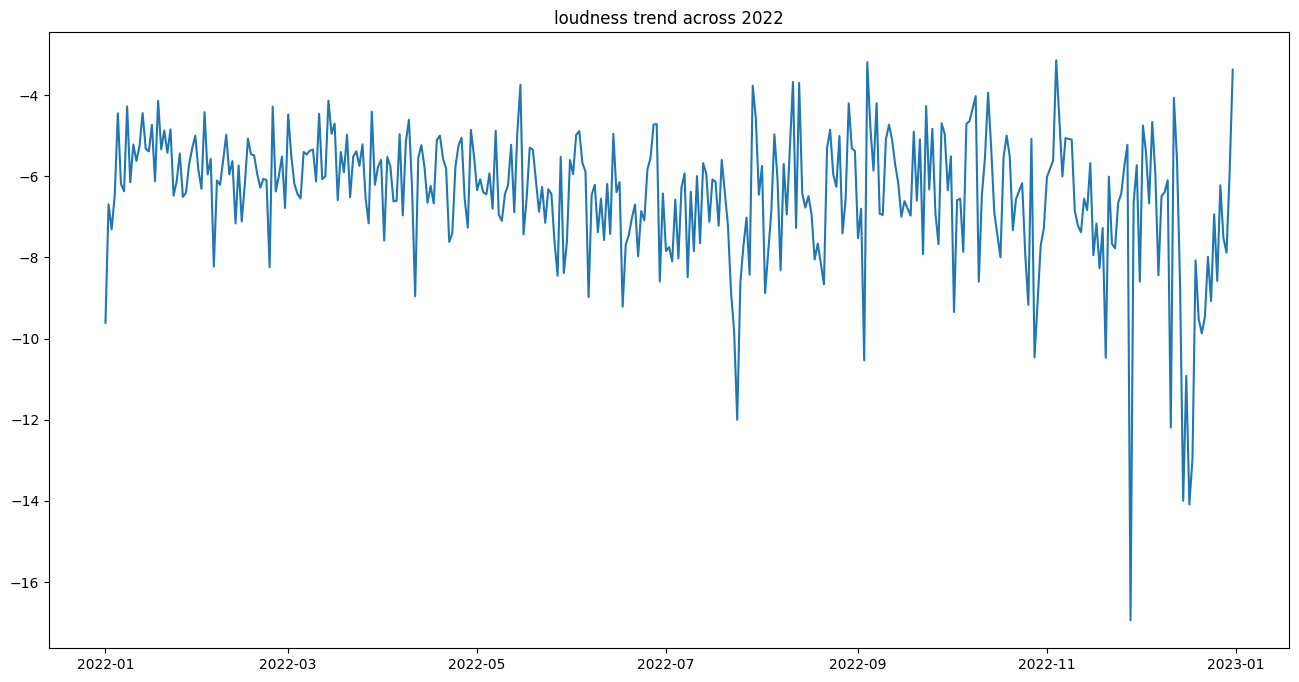

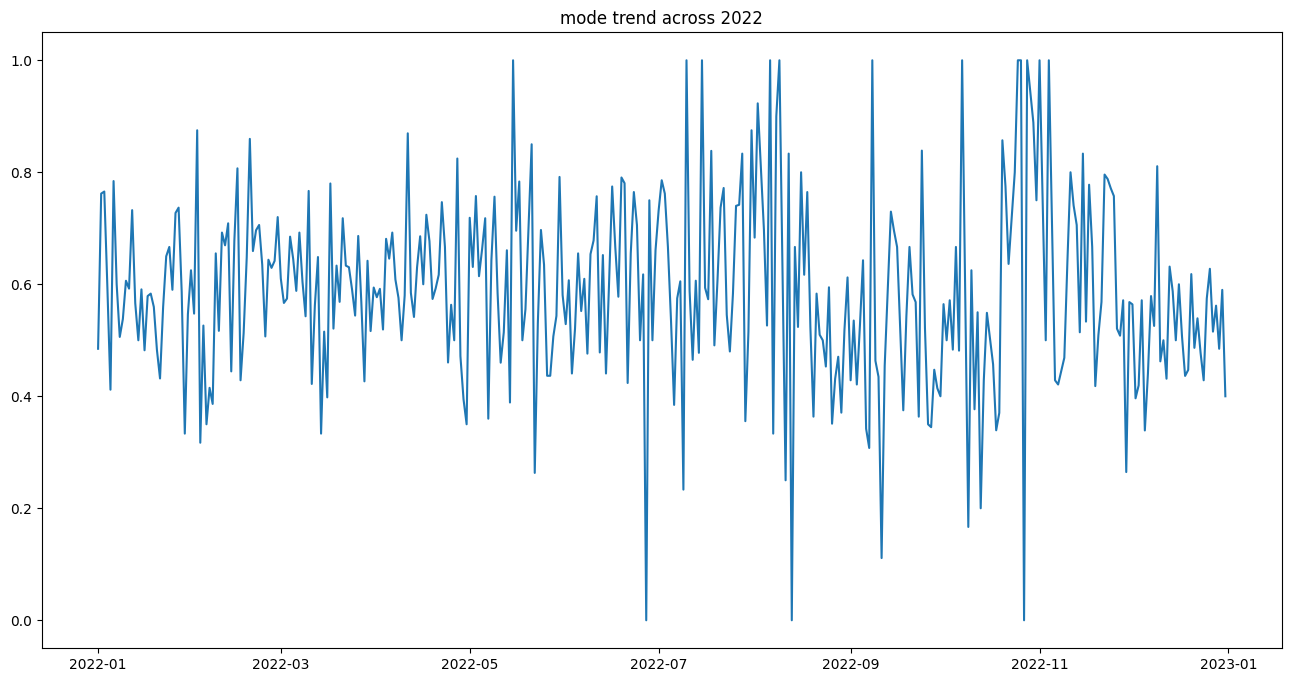

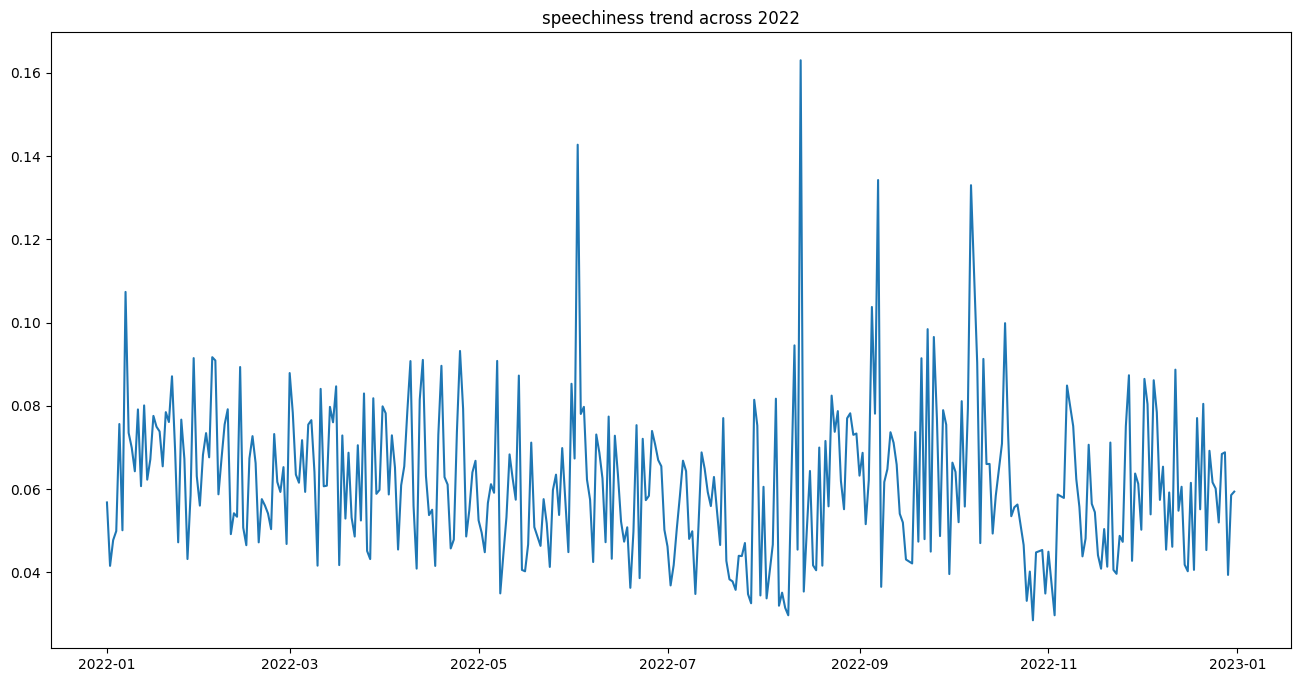

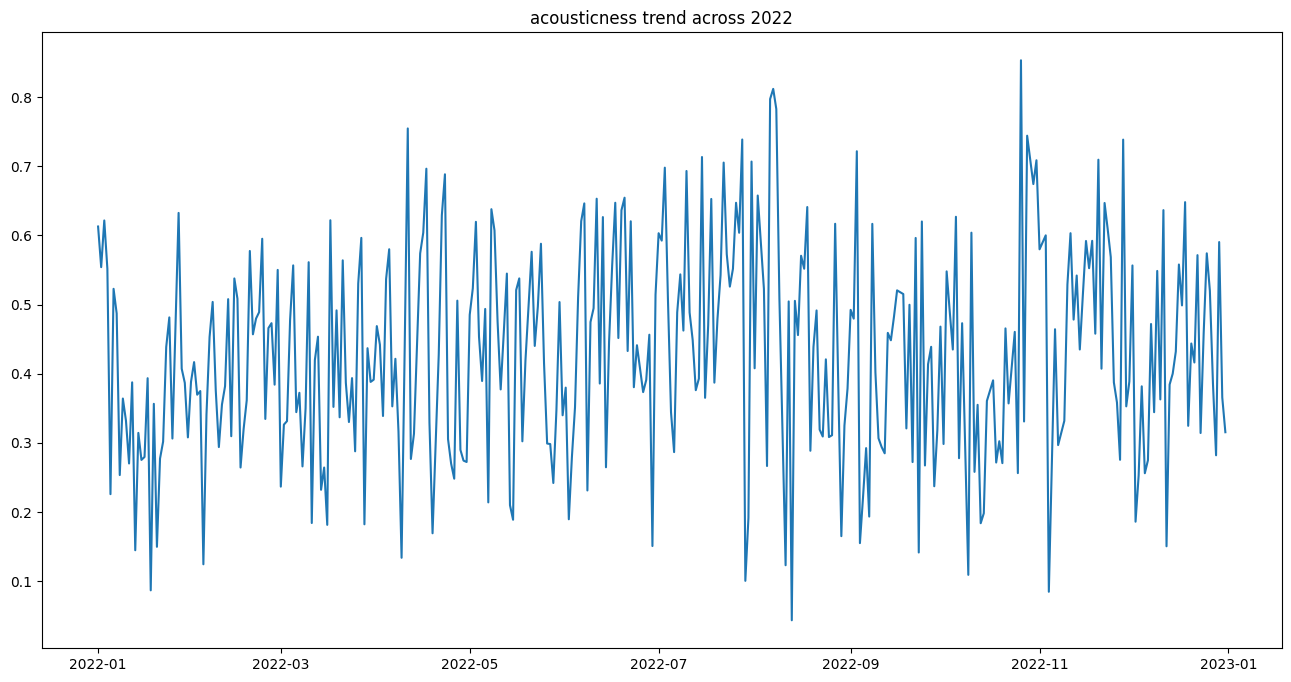

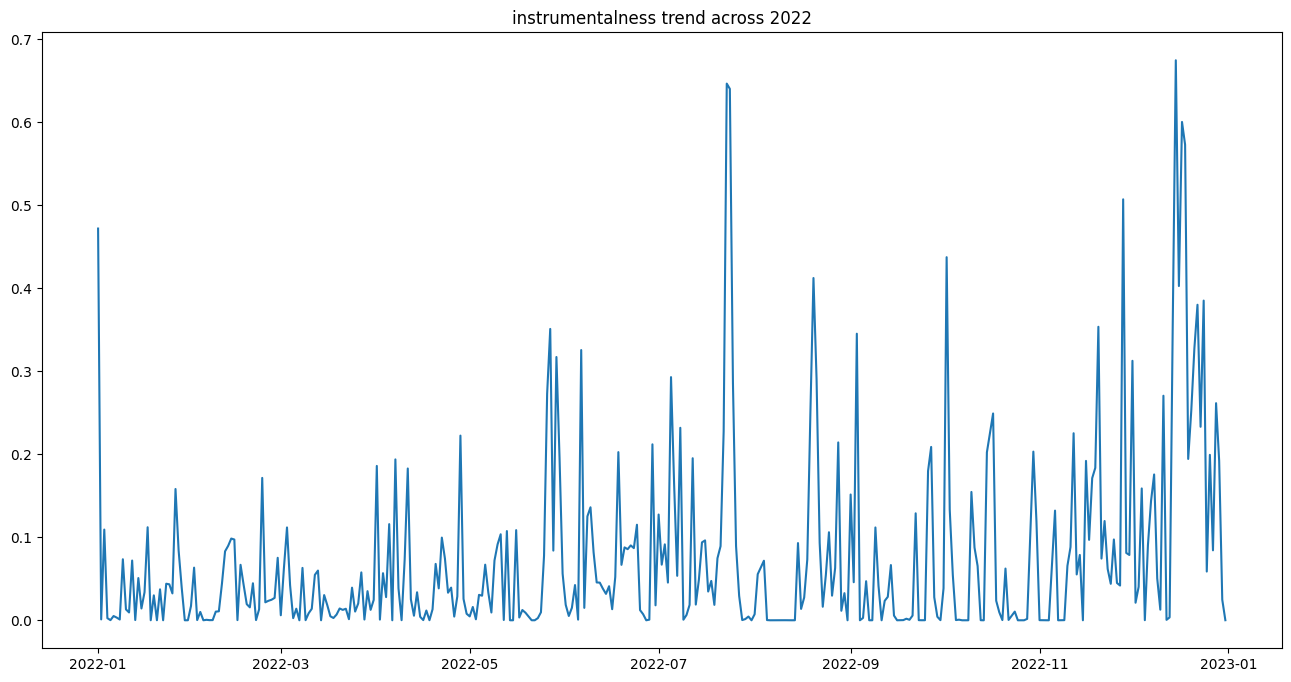

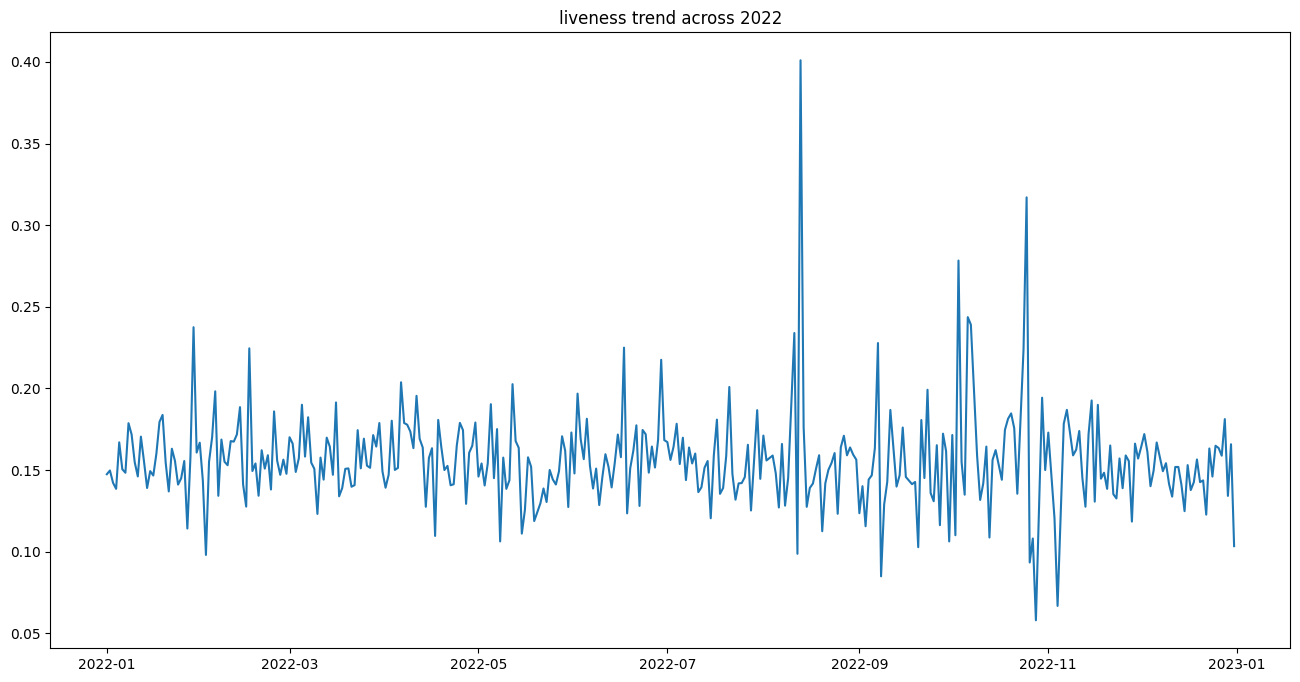

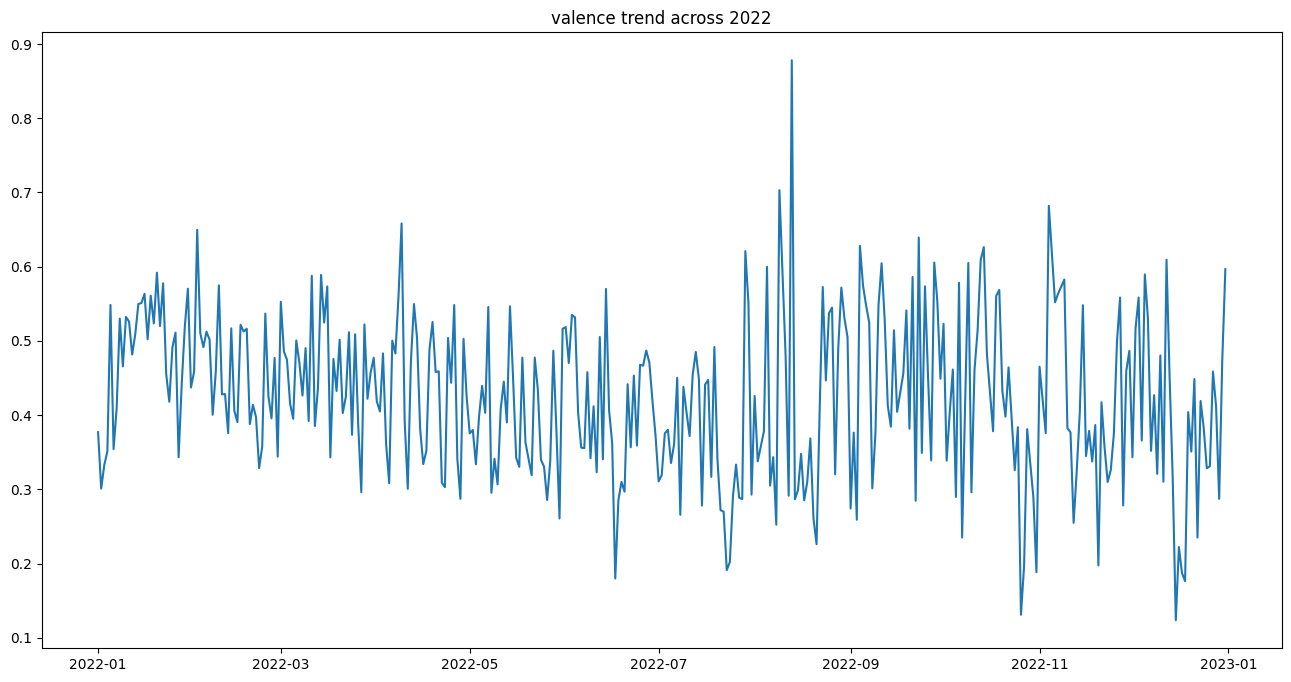

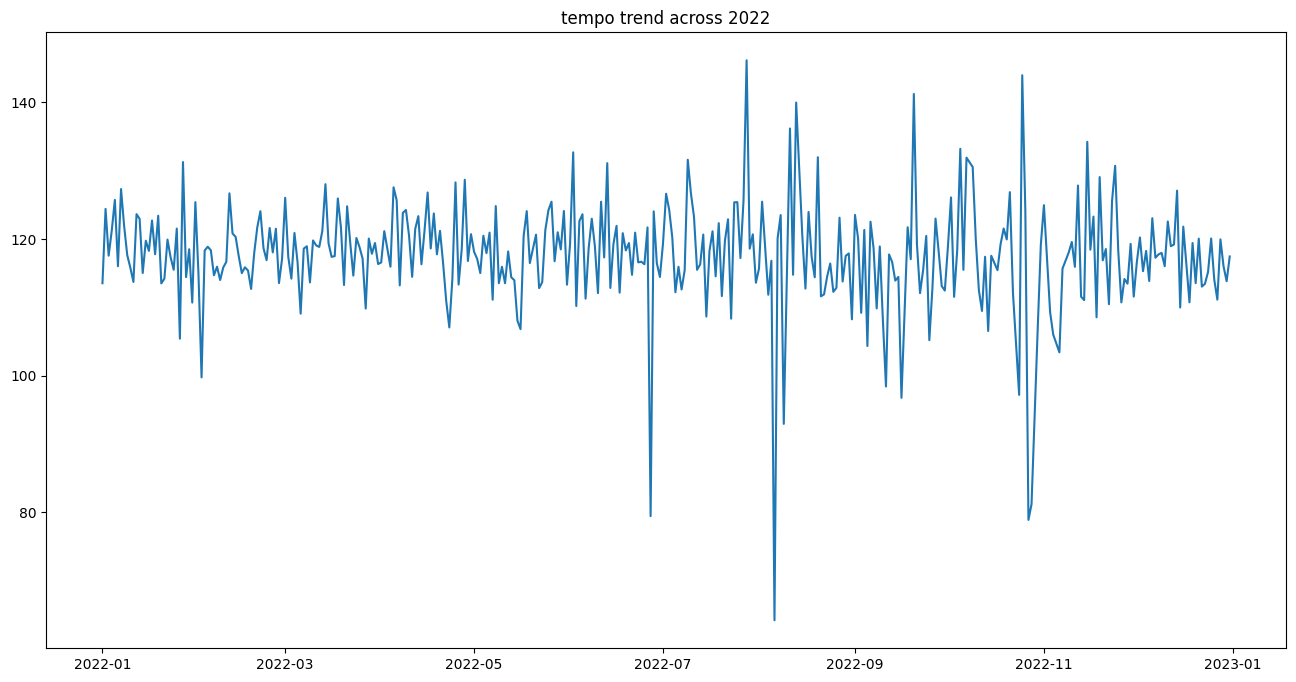

In [49]:
for fe in ["number_of_tracks", "min_played", "danceability", "energy", "key", "loudness", "mode",
           "speechiness", "acousticness", 
           "instrumentalness", "liveness", "valence", "tempo"]:
    plt.figure(figsize=(16,8))
    plt.plot(daily.datetime, daily[fe])
    plt.title(f"{fe} trend across 2022")

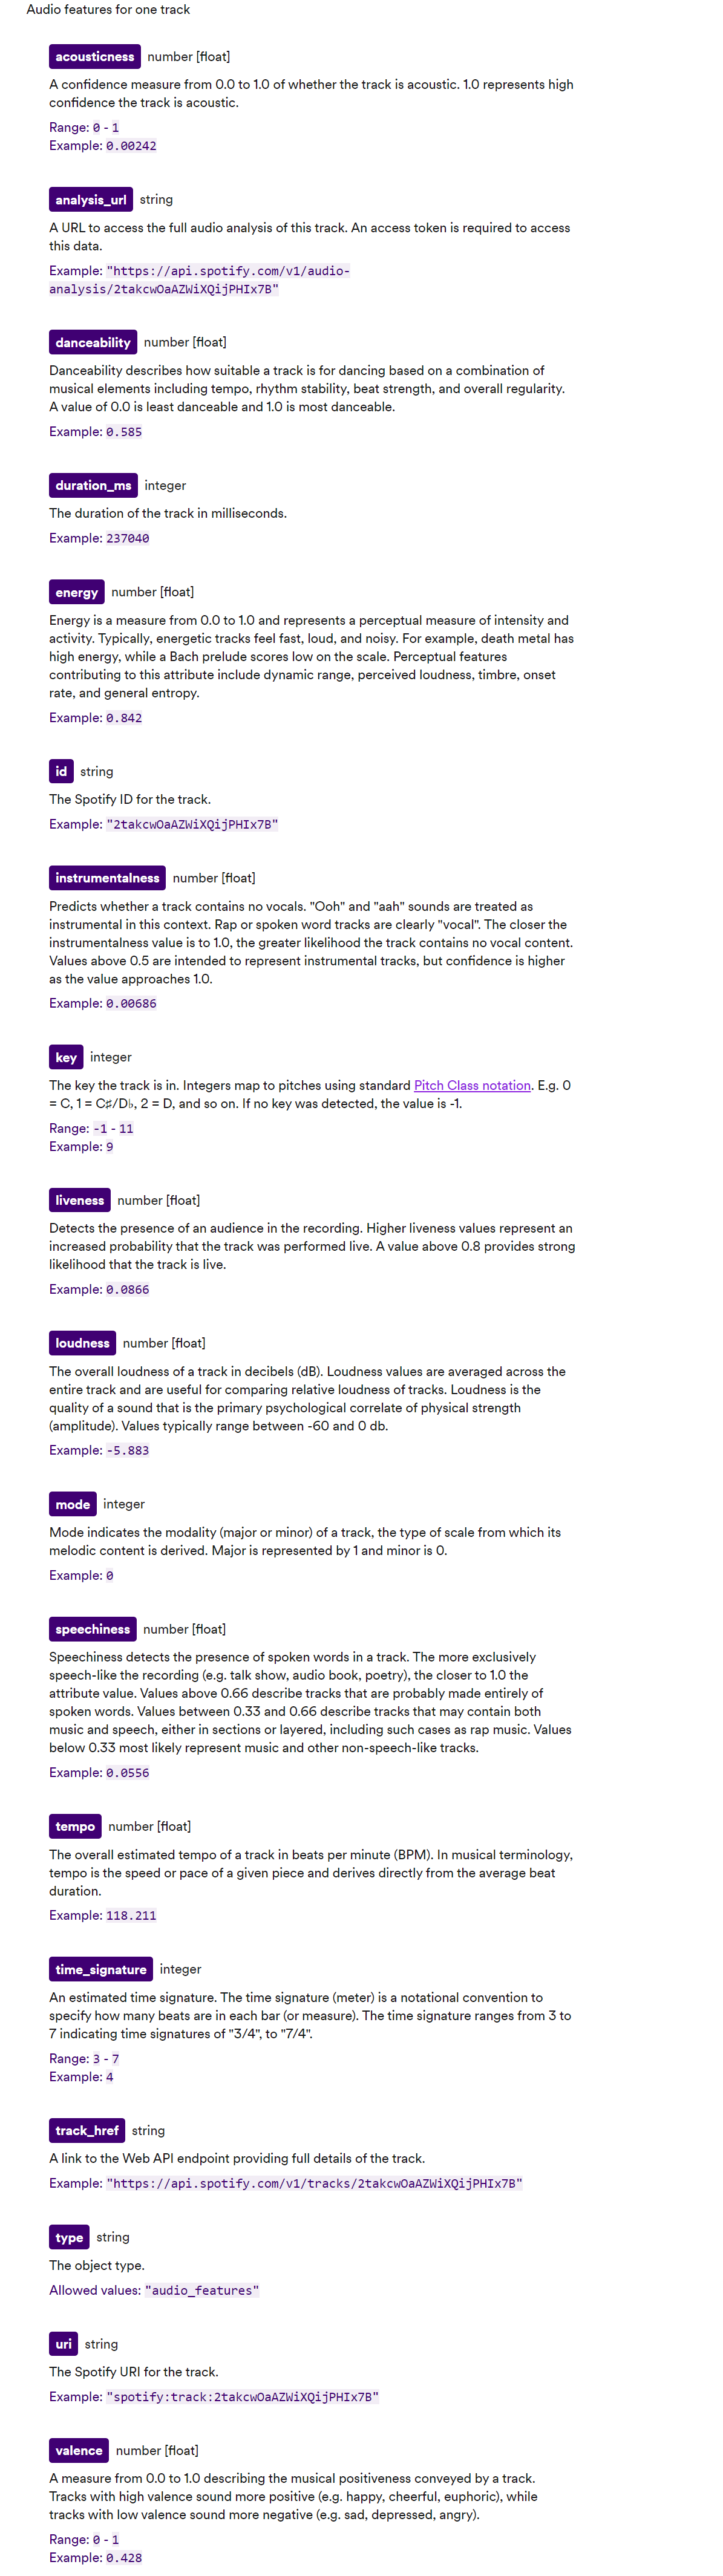

### Genres

In [73]:
ser = features.master_metadata_album_artist_name.value_counts()
ser.drop(ser.loc[ser <= 5].index, inplace=True)
ser.drop(ser.index[560], inplace=True)
ser

"Yun milae" artist was not found (index 560)

In [ ]:
genres = {}
for ar in list(ser.index):
    genres[ar] = (sp.search(q=f"artist:{ar}", type="artist")["artists"]["items"][0]["genres"])
genres

In [165]:
genres

{'BTS': ['k-pop', 'k-pop boy group', 'pop'],
 'IU': ['k-pop', 'pop'],
 'TWICE': ['k-pop', 'k-pop girl group', 'pop'],
 'HEIZE': ['k-pop', 'korean pop', 'korean r&b'],
 'Ichika Nito': ['japanese guitar', 'japanese math rock'],
 'TAEYEON': ['k-pop'],
 'Red Velvet': ['k-pop', 'k-pop girl group'],
 'CHUNG HA': ['k-pop'],
 'Aimer': ['anime', 'anime rock', 'j-pixie', 'j-pop', 'j-poprock'],
 'BOL4': ['k-pop'],
 'BAEKHYUN': ['k-pop'],
 'Hiroyuki Sawano': ['anime score', 'japanese soundtrack'],
 'BLACKPINK': ['k-pop', 'k-pop girl group', 'pop'],
 'Shawn Mendes': ['canadian pop', 'pop', 'viral pop'],
 'AILEE': ['k-pop'],
 'LeeHi': ['k-pop'],
 '(G)I-DLE': ['k-pop girl group'],
 'MAMAMOO': ['k-pop', 'k-pop girl group'],
 'Dreamcatcher': ['k-pop', 'k-pop girl group'],
 'JEONG SEWOON': ['k-pop', 'korean ost'],
 'Jung Seung Hwan': ['korean pop'],
 'Hans Zimmer': ['german soundtrack', 'orchestral soundtrack', 'soundtrack'],
 'ONEUS': ['k-pop', 'k-pop boy group'],
 'PURPLE KISS': ['k-pop'],
 'Jay Park'

In [130]:
genre_freq = {}
for ar in genres.keys():
    for ge in genres[ar]:
        if ge in genre_freq:
            genre_freq[ge] += 1
        else:
            genre_freq[ge] = 1

In [138]:
top_genre = {key: value for key, value in genre_freq.items() if value > 6}
top_genre

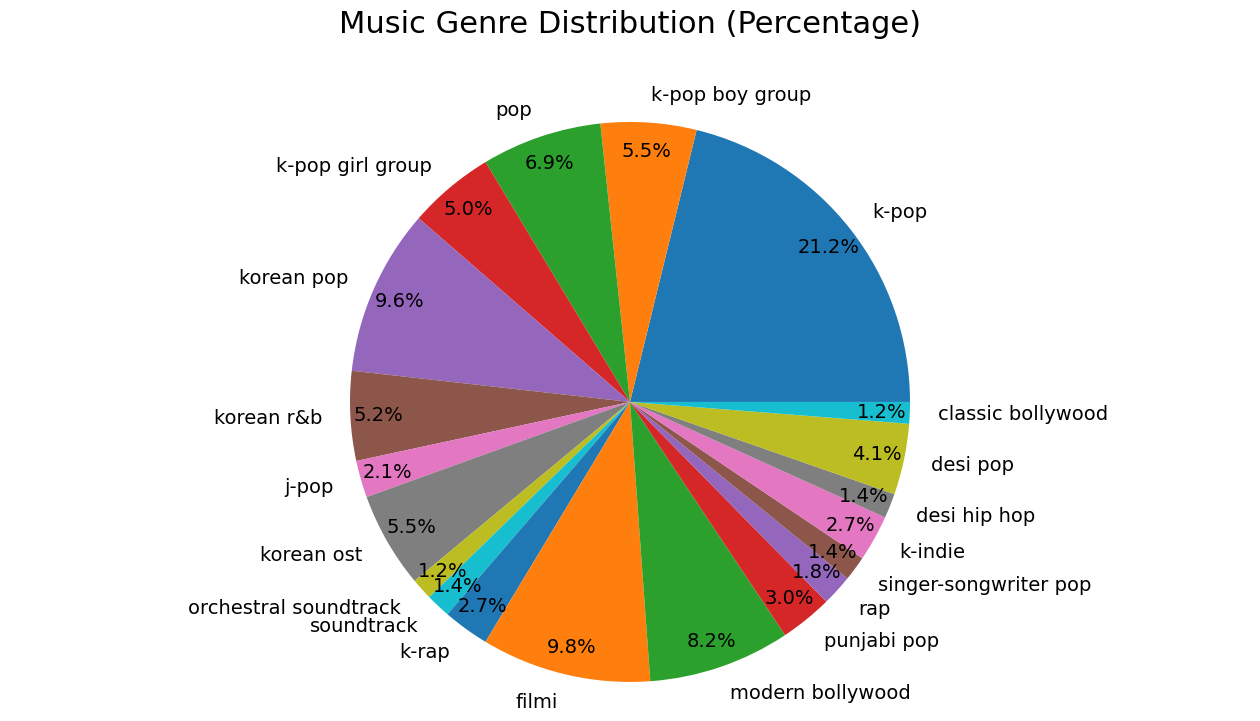

In [162]:
labels = list(top_genre.keys())
values = list(top_genre.values())

plt.figure(figsize=(16,8))
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=0, 
        pctdistance=0.9, textprops={'fontsize': 14})

plt.annotate("Music Genre Distribution (Percentage)", xy=(0.5, 1.1),  # Adjust x, y for placement
             xycoords='axes fraction', horizontalalignment='center',
             fontsize=22)
# plt.title("Music Genre Distribution (Percentage)", fontdict={'fontsize': 20})
plt.axis("equal")
plt.show()